Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM
Initializing sim with 20000 people for 60 days
  Running 2020-03-01 ( 0/60) (0.05 s)  ———————————————————— 2%
  Running 2020-03-11 (10/60) (0.06 s)  •••————————————————— 18%
  Running 2020-03-21 (20/60) (0.08 s)  ••••••—————————————— 34%
  Running 2020-03-31 (30/60) (0.09 s)  ••••••••••—————————— 51%
  Running 2020-04-10 (40/60) (0.11 s)  •••••••••••••——————— 67%
  Running 2020-04-20 (50/60) (0.13 s)  ••••••••••••••••———— 84%
  Running 2020-04-30 (60/60) (0.17 s)  •••••••••••••••••••• 100%

Simulation summary:
       12,730 cumulative infections
          596 cumulative reinfections
       10,182 cumulative infectious
        6,395 cumulative symptomatic cases
          386 cumulative severe cases
          114 cumulative critical cases
        5,159 cumulative recoveries
           14 cumulative deaths
            0 cumulative tests
            0 cumulative diagnoses
            0 cumulative known deaths
            0 cumulative quaranti

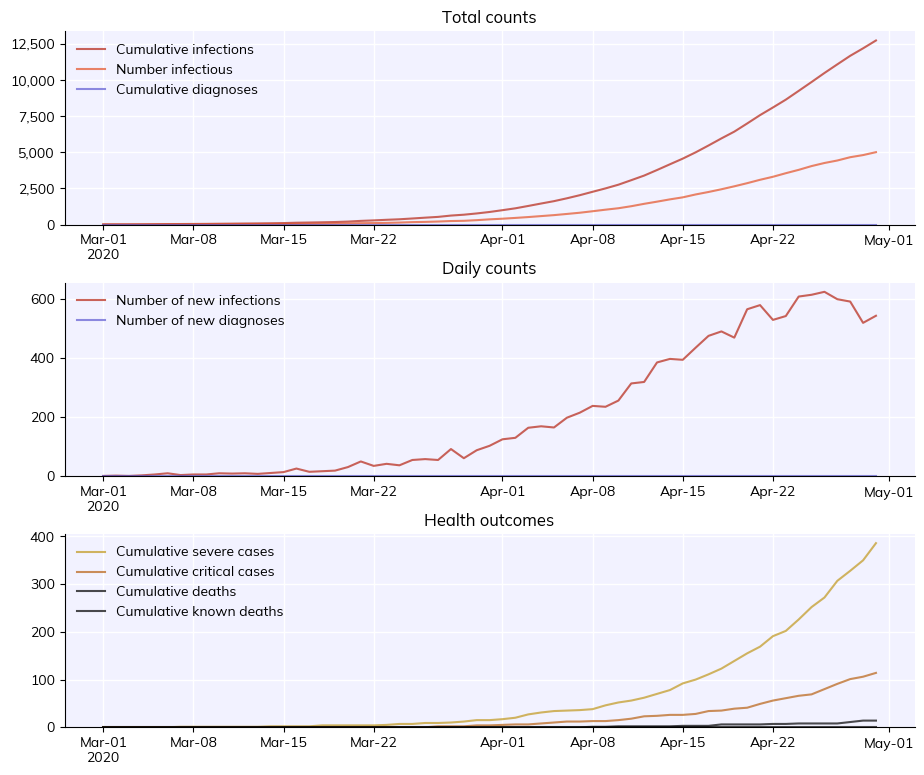

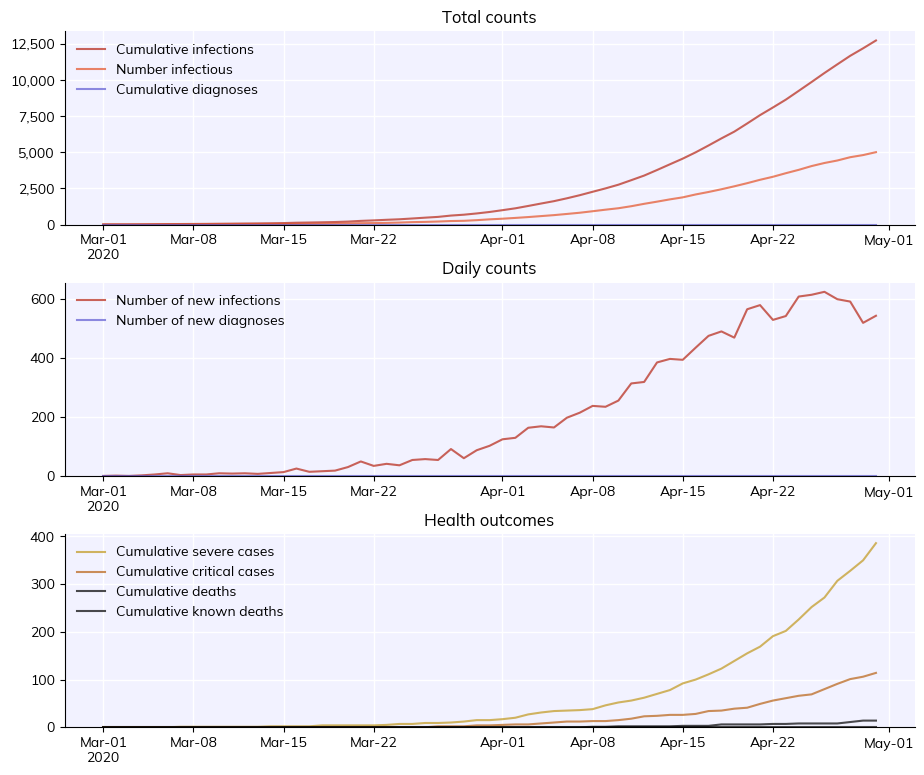

In [1]:
import covasim as cv
sim = cv.Sim()
sim.run()
sim.plot()

In [61]:
import csv
from ete3 import Tree

# ---------- Step 1: Load the CSV data ----------
def load_edges(csv_file):
    edges = []
    with open(csv_file, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            edges.append((row['Parent'], row['Child'], float(row['origin_time'])))
    return edges

# ---------- Step 2: Build tree with duplicate nodes if needed ----------
def build_tree_with_duplicates(edges):
    from collections import defaultdict
    import uuid

    children = defaultdict(list)
    origin_times = {}
    parent_history = set()
    name_mapping = {}

    for parent, child, time in edges:
        # If child was seen as a parent before, make a duplicate
        if child in parent_history:
            original_child = child
            child = f"{child}_dup_{uuid.uuid4().hex[:6]}"
            name_mapping[child] = original_child  # Keep track of the original name

        parent_history.add(parent)
        children[parent].append(child)
        origin_times[(parent, child)] = time

    return children, origin_times, name_mapping

# ---------- Step 3: Recursively build Newick ----------
def to_newick(node, children, origin_times):
    if node not in children:
        return f"{node}"
    subtrees = [to_newick(child, children, origin_times) + f":{origin_times[(node, child)]}" 
                for child in children[node]]
    return f"({','.join(subtrees)}){node}"

# ---------- Step 4: Convert to ETE Tree and visualize ----------
def build_and_show_tree(csv_file):
    edges = load_edges(csv_file)
    children, origin_times, name_mapping = build_tree_with_duplicates(edges)

    # Add a virtual root if needed
    all_nodes = set()
    all_children = set()
    for parent, kids in children.items():
        all_nodes.add(parent)
        all_children.update(kids)
    roots = list(all_nodes - all_children)
    if len(roots) > 1:
        virtual_root = "ROOT"
        for r in roots:
            children[virtual_root].append(r)
            origin_times[(virtual_root, r)] = 0.0
        root = virtual_root
    else:
        root = roots[0]

    newick_str = to_newick(root, children, origin_times) + ";"
    print("Newick format:")
    print(newick_str)

    tree = Tree(newick_str, format=1)

    # Show all node names
    for node in tree.traverse():
        node.name = name_mapping.get(node.name, node.name)
        node.add_features(name=node.name)

    tree.show()

# ---------- Run the function ----------
if __name__ == "__main__":
    build_and_show_tree("test_F.csv")  # Replace with your actual CSV file name


Newick format:
((((2_dup_e9e4a1:4.0)4:3.0)3:2.0)2:1.0)1;


In [60]:
import csv
import uuid
from collections import defaultdict
from ete3 import Tree, TreeStyle, TextFace

# ---------- Step 1: Load the CSV data ----------
def load_edges(csv_file):
    edges = []
    with open(csv_file, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            edges.append((row['Parent'], row['Child'], float(row['origin_time'])))
    return edges

# ---------- Step 2: Build tree with duplicate nodes if needed ----------
def build_tree_with_duplicates(edges):
    children = defaultdict(list)
    origin_times = {}
    parent_history = set()

    for parent, child, time in edges:
        # If child has previously appeared as a parent, create a duplicate
        if child in parent_history and child != parent:
            child = f"{child}_dup_{uuid.uuid4().hex[:6]}"

        parent_history.add(parent)
        children[parent].append(child)
        origin_times[(parent, child)] = time

    return children, origin_times

# ---------- Step 3: Recursively build Newick ----------
def to_newick(node, children, origin_times):
    if node not in children:
        return f"{node}"
    subtrees = [to_newick(child, children, origin_times) + f":{origin_times[(node, child)]}" 
                for child in children[node]]
    return f"({','.join(subtrees)}){node}"

# ---------- Step 4: Layout function to label all nodes ----------
def layout_show_all_node_labels(node):
    face = TextFace(node.name, fsize=10)
    node.add_face(face, column=0, position="aligned")
    
# ---------- Step 5: TreeStyle configuration ----------
def get_tree_style():
    ts = TreeStyle()
    ts.show_leaf_name = False  # We handle all labels manually
    ts.layout_fn = layout_show_all_node_labels
    ts.show_branch_length = True
    ts.show_branch_support = False
    ts.branch_vertical_margin = 10
    return ts

# ---------- Step 6: Convert to ETE Tree and visualize ----------
def build_and_show_tree(csv_file):
    edges = load_edges(csv_file)
    children, origin_times = build_tree_with_duplicates(edges)

    # Identify roots and add a virtual one if needed
    all_nodes = set(children.keys())
    all_children = {child for sublist in children.values() for child in sublist}
    roots = list(all_nodes - all_children)

    if len(roots) > 1:
        virtual_root = "ROOT"
        for r in roots:
            children[virtual_root].append(r)
            origin_times[(virtual_root, r)] = 0.0
        root = virtual_root
    else:
        root = roots[0]

    newick_str = to_newick(root, children, origin_times) + ";"
    print("Newick format:")
    print(newick_str)

    tree = Tree(newick_str, format=1)

    # Keep node names exactly as in Newick (no remapping)
    for node in tree.traverse():
        node.name = str(node.name)

    tree.show(tree_style=get_tree_style())

# ---------- Run the function ----------
if __name__ == "__main__":
    build_and_show_tree("test_B.csv")  # Replace with your actual CSV file name


Newick format:
((1_dup_40309b:2.0)2:1.0)1;


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM
Initializing sim with 50 people for 60 days
Loading location-specific data for "Bangladesh"
  Running 2020-03-01 ( 0/60) (0.01 s)  ———————————————————— 2%
  Running 2020-03-11 (10/60) (0.02 s)  •••————————————————— 18%
  Running 2020-03-21 (20/60) (0.02 s)  ••••••—————————————— 34%
  Running 2020-03-31 (30/60) (0.02 s)  ••••••••••—————————— 51%
  Running 2020-04-10 (40/60) (0.03 s)  •••••••••••••——————— 67%
  Running 2020-04-20 (50/60) (0.03 s)  ••••••••••••••••———— 84%
  Running 2020-04-30 (60/60) (0.03 s)  •••••••••••••••••••• 100%

Simulation summary:
           52 cumulative infections
            6 cumulative reinfections
           52 cumulative infectious
           33 cumulative symptomatic cases
            1 cumulative severe cases
            0 cumulative critical cases
           52 cumulative recoveries
            0 cumulative deaths
            0 cumulative tests
            0 cumulative diagnoses
            0 cumulative k

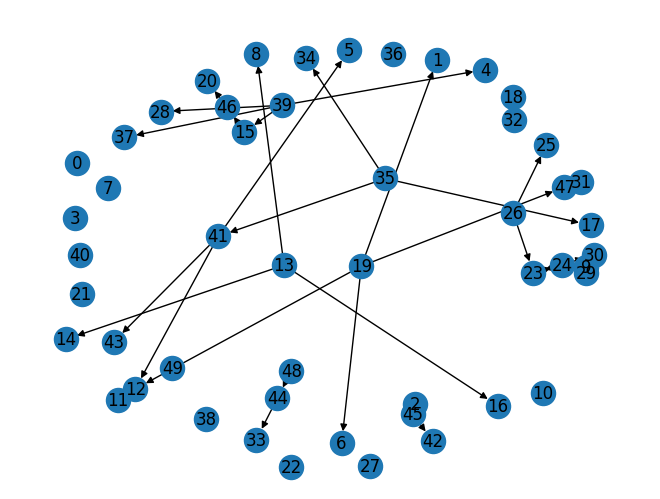

In [9]:
import covasim as cv
import networkx as nx
import matplotlib.pyplot as plt

pars = dict(
    pop_size = 50, # Alternate way of writing 10000
    pop_type = 'hybrid',
    location = 'Bangladesh', # Case insensitive
)

sim = cv.Sim(pars).run()
#sim.initialize() # Create people
#sim = cv.Sim().run()
tt = sim.make_transtree(to_networkx=True)
# a = tt.TransTree(sim, to_networkx=True)
nx.draw(tt.graph, with_labels = True, pos=nx.spring_layout(tt.graph))
plt.show()

# ppl1 = cv.People(100)
# sim = cv.Sim(pop_size=100).run()
#tt = sim.make_transtree(to_networkx=True)

In [3]:
temp = tt.graph
tempNode = list(temp.nodes)
for node in tempNode:
    if temp.degree(node) == 0:
        temp.remove_node(node)

In [4]:
import pandas as pd
from collections import defaultdict
from ete3 import Tree, TreeStyle, TextFace

# --- Load CSV ---
df = pd.read_csv("nodelist1.csv")  # Change to your actual filename
df.columns = df.columns.str.strip()

# --- Build tree relationships ---
children = defaultdict(list)
parents = set()
all_nodes = set()
times = {}

for _, row in df.iterrows():
    parent = str(row['Parent'])
    child = str(row['Child'])
    time = float(row['origin_time'])

    children[parent].append(child)
    times[child] = time
    parents.add(parent)
    all_nodes.update([parent, child])

# --- Find roots (nodes that never appear as children) ---
child_nodes = set(df['Child'].astype(str))
roots = list(parents - child_nodes)
for r in roots:
    times[r] = 0

# --- Newick builder ---
def build_newick(node, visited=None):
    if visited is None:
        visited = set()
    if node in visited:
        raise ValueError(f"Cycle detected or node reused: {node}")
    visited.add(node)

    if node not in children:
        return f"{node}:0"

    subtrees = []
    for child in children[node]:
        if child not in times or node not in times:
            raise ValueError(f"Missing time info for node {node} or child {child}")
        branch_length = times[child] - times[node]
        if branch_length < 0:
            raise ValueError(f"Negative branch length from {node} to {child}")
        subtree = build_newick(child, visited.copy())  # pass a copy for each child path
        subtree = subtree.rstrip(';')
        subtree = f"{subtree}:{branch_length:.6f}"
        subtrees.append(subtree)

    return f"({','.join(subtrees)}){node}"

# --- Combine all disconnected trees under a dummy root ---
forest = [build_newick(root) for root in roots]
newick = f"({','.join(forest)})0;"

# Save Newick
with open("output_tree.newick", "w") as f:
    f.write(newick)

# --- Visualize using ete3 ---
tree = Tree(newick)

ts = TreeStyle()
ts.show_leaf_name = True
ts.title.add_face(TextFace("Full Tree with Dummy Root (0)", fsize=14), column=0)
ts.scale = 50

# Render to image file
tree.render("output_tree.png", tree_style=ts)
print("✅ Tree saved as: output_tree.png")


NewickError: Unexpected newick format '30:0:26.000000' 
You may want to check other newick loading flags like 'format' or 'quoted_node_names'.

In [5]:
import pandas as pd
from collections import defaultdict

# Load your CSV
df = pd.read_csv("nodelist1.csv")  # Replace with your actual filename
df.columns = df.columns.str.strip()  # In case there are extra spaces

# Build parent-child relationships and time mapping
children = defaultdict(list)
parents = set()
all_nodes = set()
times = {}

for _, row in df.iterrows():
    parent = str(row['Parent'])
    child = str(row['Child'])
    time = float(row['origin_time'])

    children[parent].append(child)
    times[child] = time
    parents.add(parent)
    all_nodes.update([parent, child])

# Identify root nodes (never appear as children)
child_nodes = set(df['Child'].astype(str))
roots = list(parents - child_nodes)
for r in roots:
    times[r] = 0  # Set their time to 0

# Recursive Newick builder
def build_newick(node, visited=None):
    if visited is None:
        visited = set()
    if node in visited:
        raise ValueError(f"Cycle detected or node reused: {node}")
    visited.add(node)

    if node not in children:
        return f"{node}"

    subtrees = []
    for child in children[node]:
        if child not in times or node not in times:
            raise ValueError(f"Missing time info for node {node} or child {child}")
        branch_length = times[child] - times[node]
        if branch_length < 0:
            raise ValueError(f"Negative branch length from {node} to {child}")
        subtree = build_newick(child, visited.copy())
        subtree = subtree.rstrip(';')
        subtree = f"{subtree}:{branch_length:.6f}"
        subtrees.append(subtree)

    return f"({','.join(subtrees)}){node}"


# Build the forest and join under root "0"
forest = [build_newick(root) for root in roots]
newick = f"({','.join(forest)})0;"

# Output Newick string
print("Newick format:")
print(newick)

# Optionally, save to file
with open("output_tree.newick", "w") as f:
    f.write(newick)


Newick format:
((30:26.000000)24,(16:6.000000,8:6.000000,14:11.000000)13,((33:7.000000)44:6.000000)48,(30:26.000000,9:5.000000)29,(25:2.000000,23:5.000000)26,(((20:5.000000)46:13.000000)15:4.000000,28:4.000000,4:5.000000,37:6.000000)39,((31:13.000000)47:4.000000,(11:4.000000)12:18.000000,6:5.000000,1:6.000000)19,((42:11.000000)45:11.000000)2,(17:7.000000,34:8.000000,(43:5.000000,(11:4.000000)12:5.000000,5:9.000000)41:13.000000)35)0;


In [6]:
# --- Visualize using ete3 ---
tree = Tree(newick)

ts = TreeStyle()
ts.show_leaf_name = True
ts.title.add_face(TextFace("Full Tree with Dummy Root (0)", fsize=14), column=0)
ts.scale = 50

# Render to image file
tree.render("output_tree.png", tree_style=ts)
print("✅ Tree saved as: output_tree.png")

✅ Tree saved as: output_tree.png


In [7]:
tree.show()

In [20]:
import pandas as pd
from collections import defaultdict
import uuid

# Load CSV
#df = pd.read_csv("nodelist2.csv")
#df = pd.read_csv("test_A.csv")
df = pd.read_csv("test_B.csv")
# df = pd.read_csv("test_C.csv")
# df = pd.read_csv("test_D.csv")
# df = pd.read_csv("test_E.csv")
# df = pd.read_csv("test_F.csv")
df.columns = df.columns.str.strip()

# Detect bidirectional edges and fix by creating unique duplicate nodes
edges = set((str(row['Parent']), str(row['Child'])) for _, row in df.iterrows())
new_rows = []

for _, row in df.iterrows():
    parent = str(row['Parent'])
    child = str(row['Child'])
    time = float(row['origin_time'])

    if (child, parent) in edges:
        new_child = f"{child}_dup_{uuid.uuid4().hex[:4]}"
        new_rows.append({'Parent': parent, 'Child': new_child, 'origin_time': time})
    else:
        new_rows.append({'Parent': parent, 'Child': child, 'origin_time': time})

clean_df = pd.DataFrame(new_rows)

# Build tree structures
children = defaultdict(list)
times = {}
parents = set()
all_nodes = set()

for _, row in clean_df.iterrows():
    parent = str(row['Parent'])
    child = str(row['Child'])
    time = float(row['origin_time'])

    children[parent].append(child)
    times[child] = time
    parents.add(parent)
    all_nodes.update([parent, child])

child_nodes = set(clean_df['Child'].astype(str))
roots = list(parents - child_nodes)
for r in roots:
    times[r] = 0

# Recursive Newick builder
def build_newick(node, visited=None):
    if visited is None:
        visited = set()
    if node in visited:
        raise ValueError(f"Cycle detected or node reused: {node}")
    visited.add(node)

    if node not in children:
        return f"{node}"

    subtrees = []
    for child in children[node]:
        branch_length = times[child] - times[node]
        subtree = build_newick(child, visited.copy())
        subtree = subtree.rstrip(';')
        subtrees.append(f"{subtree}:{branch_length:.6f}")
    return f"({','.join(subtrees)}){node}"

# Generate Newick string
forest = [build_newick(root) for root in roots]
newick = f"({','.join(forest)})0;"

# Save to file
with open("output_tree.newick", "w") as f:
    f.write(newick)

print("Newick tree saved to output_tree.newick")


Newick tree saved to output_tree.newick


In [21]:
# --- Visualize using ete3 ---
tree = Tree(newick)

ts = TreeStyle()
ts.show_leaf_name = True
ts.title.add_face(TextFace("Full Tree with Dummy Root (0)", fsize=14), column=0)
ts.scale = 50

# Render to image file
tree.render("output_tree.png", tree_style=ts)
print("✅ Tree saved as: output_tree.png")
tree.show()

✅ Tree saved as: output_tree.png


In [16]:
# Add a cache so shared children don’t trigger recursion
subtree_cache = {}

def build_newick_2(node, visited=None):
    if visited is None:
        visited = set()
    if node in subtree_cache:
        return subtree_cache[node]
    if node in visited:
        return node  # Allow re-use without duplication

    visited.add(node)

    if node not in children:
        subtree = f"{node}"
    else:
        subtrees = []
        for child in children[node]:
            if child not in times or node not in times:
                raise ValueError(f"Missing time info for node {node} or child {child}")
            branch_length = times[child] - times[node]
            if branch_length < 0:
                raise ValueError(f"Negative branch length from {node} to {child}")
            subtree = build_newick(child, visited.copy())
            subtree = subtree.rstrip(';')
            subtrees.append(f"{subtree}:{branch_length:.6f}")
        subtree = f"({','.join(subtrees)}){node}"

    subtree_cache[node] = subtree
    return subtree

In [44]:
import pandas as pd
from collections import defaultdict
import uuid

# Load CSV
#df = pd.read_csv("nodelist2.csv")
#df = pd.read_csv("test_A.csv")
#df = pd.read_csv("test_B.csv")
#df = pd.read_csv("test_C.csv")
#df = pd.read_csv("test_D.csv")
#df = pd.read_csv("test_E.csv")
df = pd.read_csv("test_F.csv")
df.columns = df.columns.str.strip()

# Detect bidirectional edges and fix by creating unique duplicate nodes
edges = set((str(row['Parent']), str(row['Child'])) for _, row in df.iterrows())
new_rows = []

for _, row in df.iterrows():
    parent = str(row['Parent'])
    child = str(row['Child'])
    time = float(row['origin_time'])

    if (child, parent) in edges:
        new_child = f"{child}_dup_{uuid.uuid4().hex[:4]}"
        new_rows.append({'Parent': parent, 'Child': new_child, 'origin_time': time})
    else:
        new_rows.append({'Parent': parent, 'Child': child, 'origin_time': time})

clean_df = pd.DataFrame(new_rows)

# Build tree structures
children = defaultdict(list)
times = {}
parents = set()
all_nodes = set()

for _, row in clean_df.iterrows():
    parent = str(row['Parent'])
    child = str(row['Child'])
    time = float(row['origin_time'])

    children[parent].append(child)
    times[child] = time
    parents.add(parent)
    all_nodes.update([parent, child])

child_nodes = set(clean_df['Child'].astype(str))
roots = list(parents - child_nodes)
for r in roots:
    times[r] = 0

def build_newick(node, visited=None):
    if visited is None:
        visited = set()
    if node in visited:
        raise ValueError(f"Cycle detected or node reused: {node}")
    visited.add(node)

    if node not in children:
        return f"{node}"  # leaf node

    subtrees = []
    for child in children[node]:
        if child not in times or node not in times:
            raise ValueError(f"Missing time info for node {node} or child {child}")
        branch_length = times[child] - times[node]
        if branch_length < 0:
            raise ValueError(f"Negative branch length from {node} to {child}")
        subtree = build_newick(child, visited.copy())
        subtree = subtree.rstrip(';')
        subtree = f"{subtree}:{branch_length:.6f}"
        subtrees.append(subtree)

    return f"({','.join(subtrees)}){node}"  # <--- include internal node label here


# Generate Newick string
forest = [build_newick(root) for root in roots]
newick = f"({','.join(forest)})0;"  # Label for virtual root "0"

# Save to file
with open("output_tree.newick", "w") as f:
    f.write(newick)

print("Newick tree saved to output_tree.newick")

# --- Visualize using ete3 ---
tree = Tree(newick)

ts = TreeStyle()
ts.show_leaf_name = True
ts.title.add_face(TextFace("Full Tree with Dummy Root (0)", fsize=14), column=0)
ts.scale = 50

# Render to image file
tree.render("output_tree.png", tree_style=ts)
print("✅ Tree saved as: output_tree.png")
tree.show()

Newick tree saved to output_tree.newick
✅ Tree saved as: output_tree.png


In [45]:
from ete3 import Tree, TreeStyle, TextFace

# Load your tree
t = Tree(newick, format=1)

# Add names to *all* nodes including internal ones
for node in t.traverse():
    if node.name:
        name_face = TextFace(node.name, fsize=10)
        node.add_face(name_face, column=0, position="branch-right")

# Create and configure tree style
ts = TreeStyle()
ts.show_leaf_name = False  # disable default leaf names
ts.scale = 120

# Show the tree
t.show(tree_style=ts)


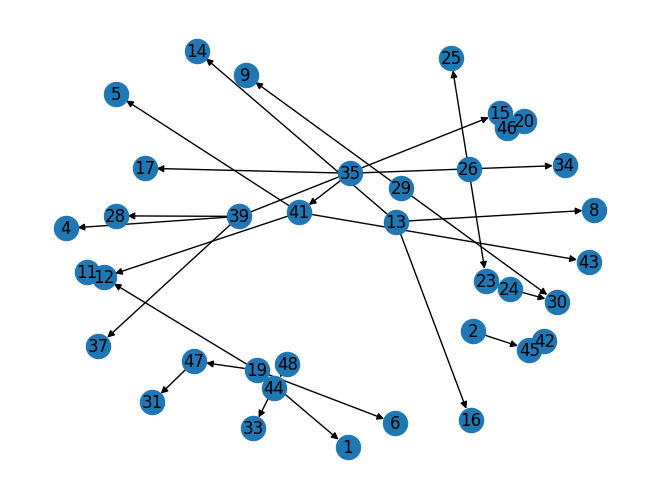

In [73]:
nx.draw(temp, with_labels = True)#, pos=nx.spring_layout(temp))
plt.show()

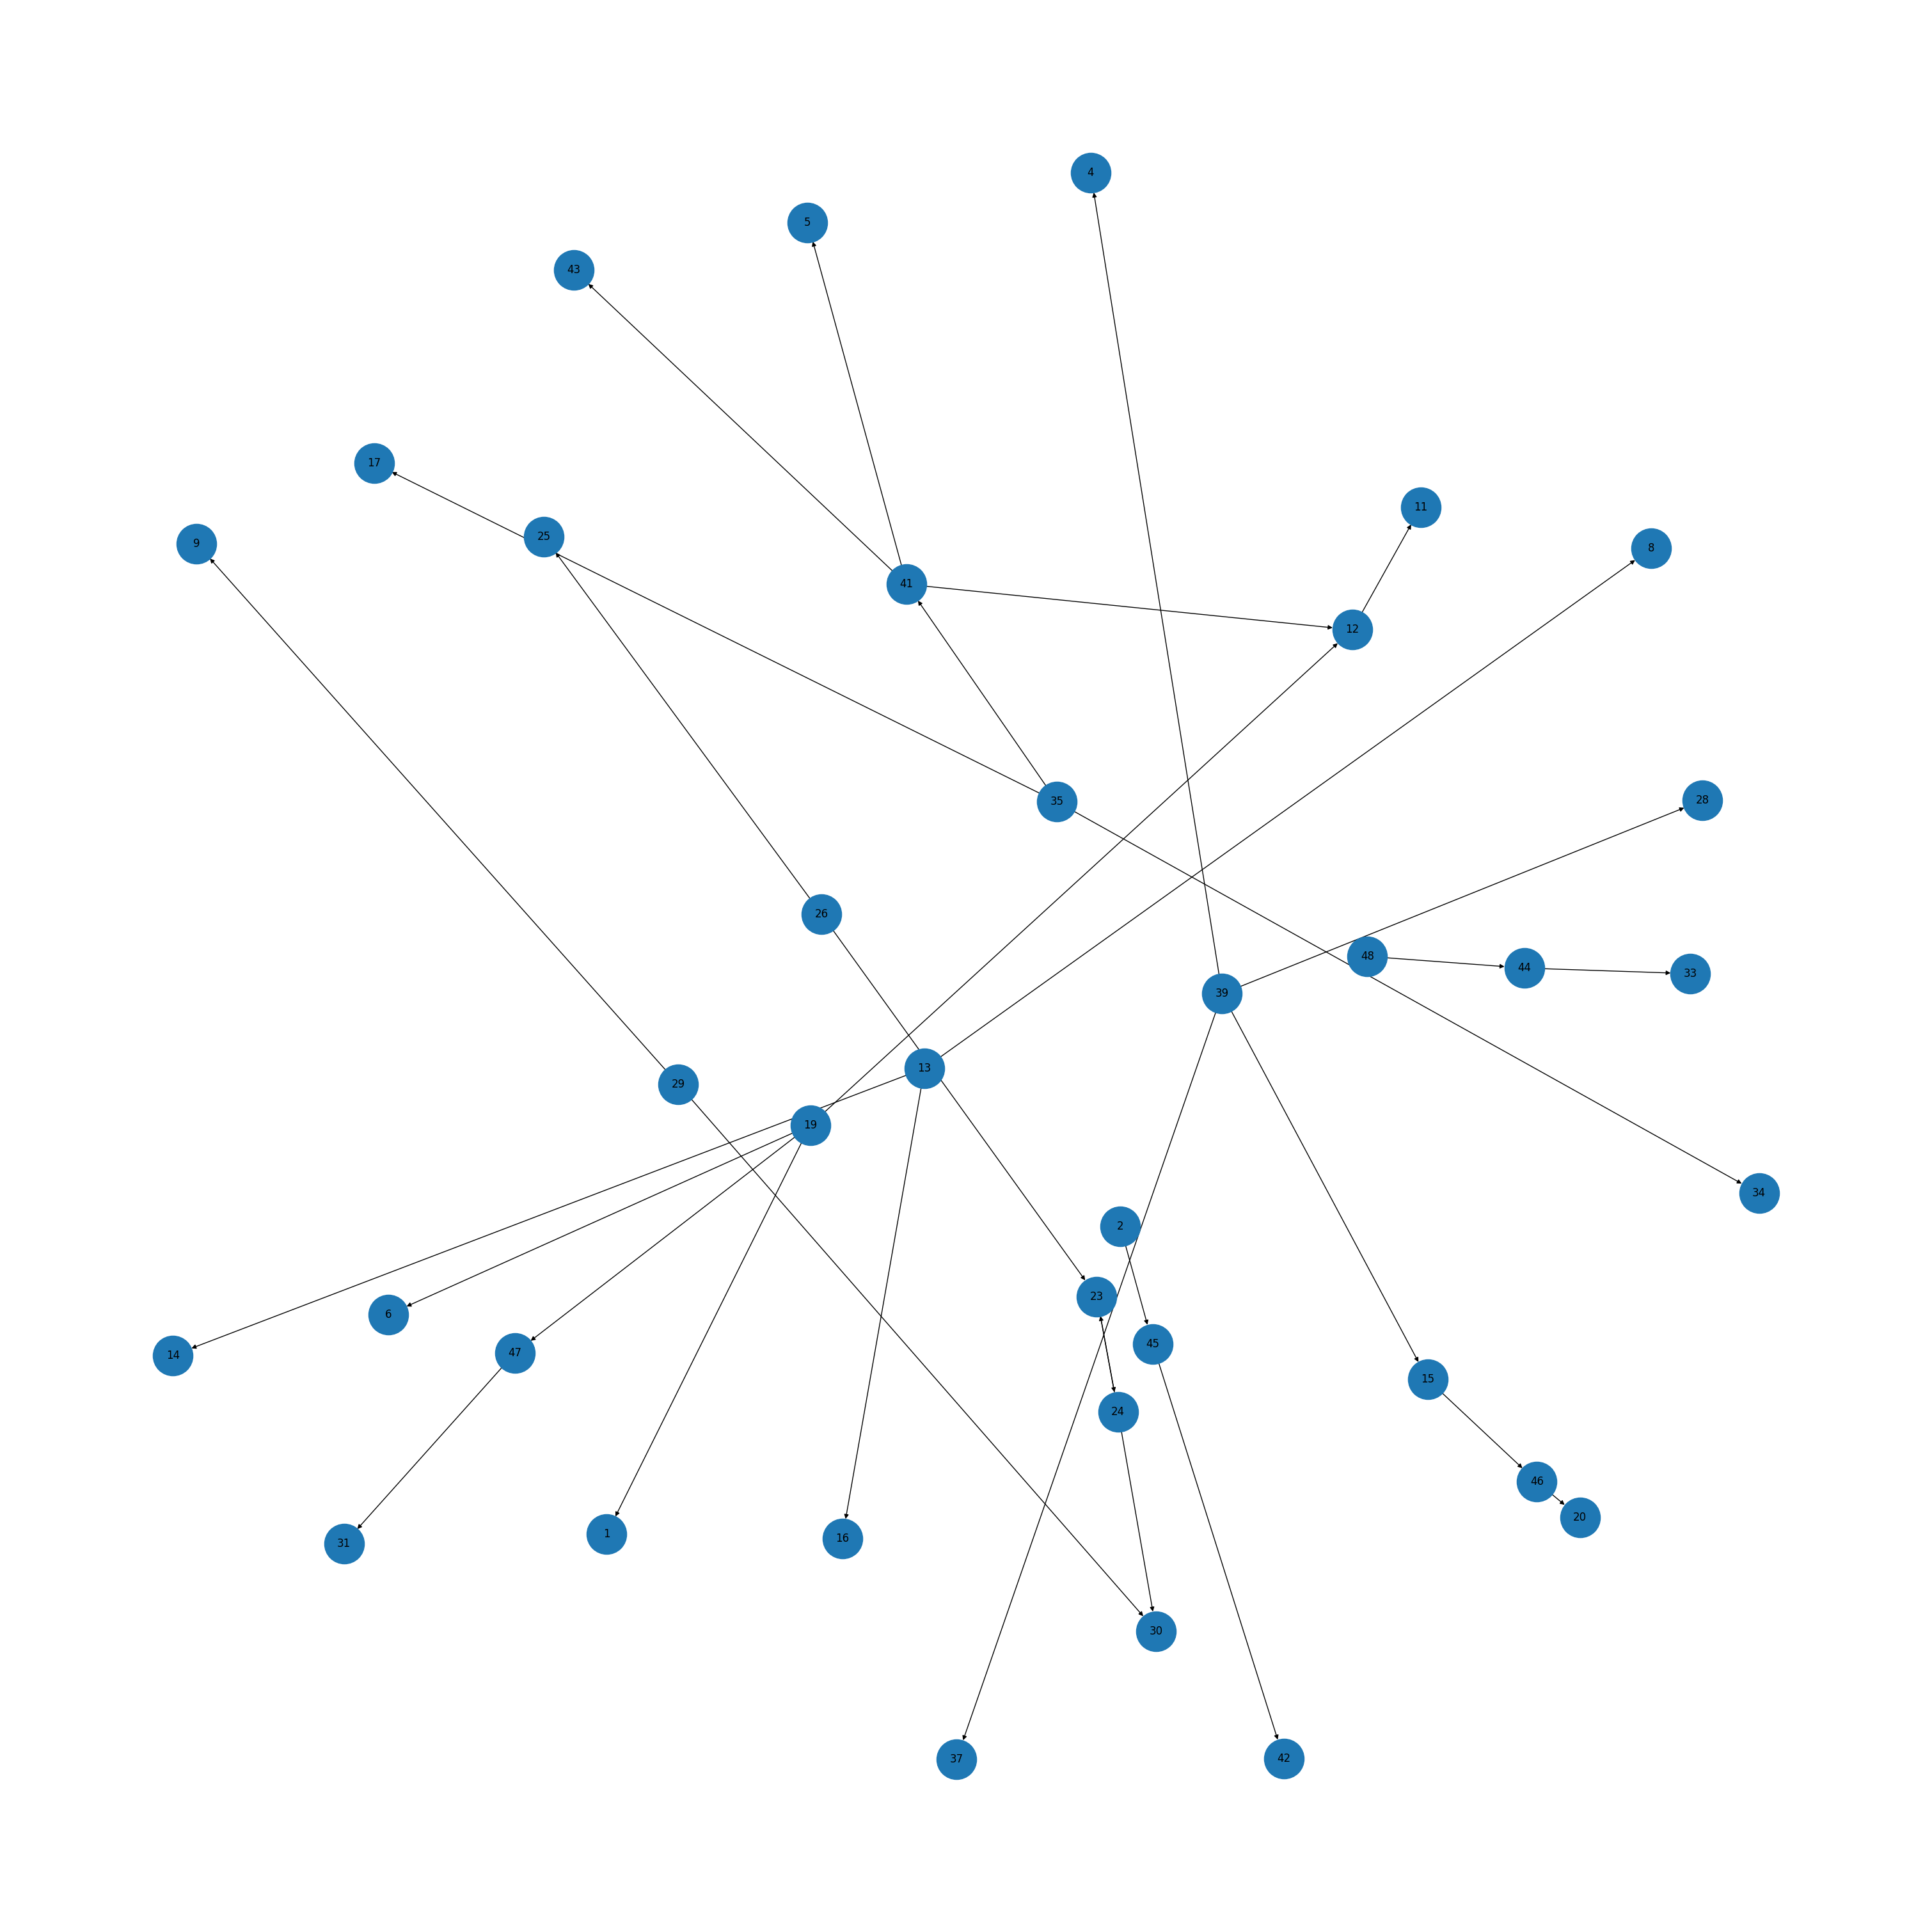

In [65]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


# plot
pos = nx.spring_layout(temp, k=0.3*1/np.sqrt(len(temp.nodes())), iterations=20)
plt.figure(3, figsize=(30, 30))
nx.draw(temp, pos=pos, node_size=2000)
nx.draw_networkx_labels(temp, pos=pos)
plt.show()

In [3]:
print(tt.graph.edges())

[(2, 45), (12, 11), (13, 16), (13, 8), (13, 14), (15, 46), (19, 47), (19, 12), (19, 6), (19, 1), (23, 24), (24, 23), (24, 30), (26, 25), (26, 23), (29, 30), (29, 9), (35, 17), (35, 34), (35, 41), (39, 15), (39, 28), (39, 4), (39, 37), (41, 43), (41, 12), (41, 5), (44, 33), (45, 42), (46, 20), (47, 31), (48, 44)]


In [11]:
import pickle

with open('test.gpickle', 'wb') as f:
    pickle.dump(tt.graph, f, pickle.HIGHEST_PROTOCOL)

In [4]:
import phylotrackpy
import alifedata_phyloinformatics_convert as apc
d = tt.graph.reverse(copy=True)
converter = apc.RosettaTree(d)

In [12]:
tt

[<class 'covasim.analysis.TransTree'>, <class 'covasim.analysis.Analyzer'>, <class 'sciris.sc_printing.prettyobj'>]
————————————————————————————————————————————————————————————————————————
Methods:
  animate()               finalize()              r0()                    
  apply()                 initialize()            shrink()                
  count_targets()         make_detailed()         to_json()               
  count_transmissions()   plot()                  day()                   
  plot_histograms()       
————————————————————————————————————————————————————————————————————————
     detailed:     source  target  date           layer    trg_age
               src_age  \
               0 [...]
           df:      Day layer  s_asymp  s_presymp  s_sev  s_crit
               s_diag  s_quar   [...]
    finalized: False
        graph: <networkx.classes.digraph.DiGraph object at
               0x13c6aed60>
infection_log: [{'source': None, 'target': 2, 'date': 0, 'layer':
         

In [5]:
tt.make_detailed(1)

In [15]:
ttt = tt.to_json()

In [11]:
print(ttt['infection_log'])

[{'source': None, 'target': 2, 'date': 0, 'layer': 'seed_infection', 'variant': 'wild'}, {'source': None, 'target': 3, 'date': 0, 'layer': 'seed_infection', 'variant': 'wild'}, {'source': None, 'target': 13, 'date': 0, 'layer': 'seed_infection', 'variant': 'wild'}, {'source': None, 'target': 19, 'date': 0, 'layer': 'seed_infection', 'variant': 'wild'}, {'source': None, 'target': 21, 'date': 0, 'layer': 'seed_infection', 'variant': 'wild'}, {'source': None, 'target': 22, 'date': 0, 'layer': 'seed_infection', 'variant': 'wild'}, {'source': None, 'target': 26, 'date': 0, 'layer': 'seed_infection', 'variant': 'wild'}, {'source': None, 'target': 27, 'date': 0, 'layer': 'seed_infection', 'variant': 'wild'}, {'source': None, 'target': 29, 'date': 0, 'layer': 'seed_infection', 'variant': 'wild'}, {'source': None, 'target': 31, 'date': 0, 'layer': 'seed_infection', 'variant': 'wild'}, {'source': None, 'target': 32, 'date': 0, 'layer': 'seed_infection', 'variant': 'wild'}, {'source': None, 'targ

In [16]:
ttt['infection_log']

nodelist = []
for i in range(len(ttt['infection_log'])):
    if ttt['infection_log'][i]['source'] == None: continue
    
    temp = [int(ttt['infection_log'][i]['source']), int(ttt['infection_log'][i]['target']), int(ttt['infection_log'][i]['date'])]
    nodelist.append(temp)

In [17]:
import csv
with open('nodelist2.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerow(['Parent', 'Child', 'origin_time'])
    for i in nodelist:
        # if (i[0] == 23 and i[1] == 24) or (i[0] == 24 and i[1] == 23):
        #     continue
        spamwriter.writerow([i[0], i[1], i[2]])

In [4]:
import csv

# A = [[1,2,1], [1,3,1]]
# B = [[1,2,1], [2,1,2]]
# C = [[1,3,1], [2,3,1]]
# D = [[1,2,1], [3,4,1]]
# E = [[0,1,0], [0,2,0], [1,3,1], [2,4,1], [4,3,2]]
F = [[1,2,1], [2,3,2], [3,4,3], [4,2,4]]

nodelist = F
with open('test_F.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerow(['Parent', 'Child', 'origin_time'])
    for i in nodelist:
        # if (i[0] == 23 and i[1] == 24) or (i[0] == 24 and i[1] == 23):
        #     continue
        spamwriter.writerow([i[0], i[1], i[2]])

In [31]:
import csv

# dictionary with string keys and set() values
tree = {}

with open('nodelist.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            # skip header
            line_count +=1
        else:
            # grab the first column, split by |, strip whitespace
            nodes = [node for node in row]#.split('|')]
            for i in range(len(nodes) - 1):
                tree.setdefault(int(nodes[i]), set()).add(int(nodes[i+1]))
            line_count += 1

print(tree)
# output: {'A': {'A3', 'A2', 'A1'}, 'A2': {'A23', 'A22', 'A21'}, 'A3': {'A31', 'A32'}}


{26: {25, 23}, 25: {2}, 39: {37, 28, 4, 15}, 15: {4, 46}, 28: {4}, 19: {1, 12, 6, 47}, 47: {4, 31}, 12: {18, 11, 4}, 23: {24, 18, 5}, 29: {9, 30}, 30: {26, 5}, 4: {5}, 6: {5}, 9: {5}, 13: {16, 8, 14}, 16: {6}, 37: {6}, 1: {6}, 8: {6}, 48: {44}, 44: {33, 6}, 35: {17, 34, 41}, 17: {7}, 34: {8}, 14: {11}, 2: {45}, 45: {42, 11}, 24: {12, 30, 23}, 33: {13}, 41: {5, 43, 12, 13}, 31: {17}, 46: {17, 20}, 43: {18}, 11: {22}, 42: {22}, 20: {22}, 5: {22}}


In [36]:
notRoot = set()
for i in tree:
    for j in tree[i]:
        notRoot.add(j)
print(notRoot)
for i in tree:
    print(i)
    if i in notRoot:
        notRoot.remove(i)

notRoot

{1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 28, 30, 31, 33, 34, 37, 41, 42, 43, 44, 45, 46, 47}
26
25
39
15
28
19
47
12
23
29
30
4
6
9
13
16
37
1
8
48
44
35
17
34
14
2
45
24
33
41
31
46
43
11
42
20
5


{7, 18, 22}

In [34]:
for i in notRoot:
    print(tree[i])

KeyError: 7

In [20]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
from Bio.Phylo import draw_ascii

# Create a simple distance matrix
matrix = DistanceMatrix(names=["A", "B", "C", "D"], matrix=[
    [0],        # A
    [5, 0],     # B
    [9, 10, 0], # C
    [7, 8, 6, 0]# D
])

# Use UPGMA to build the tree
constructor = DistanceTreeConstructor()
tree = constructor.upgma(matrix)

# Print the tree in ASCII
draw_ascii(tree)

                        _____________________________________________________ D
  _____________________|
 |                     |_____________________________________________________ C
_|
 |                               ____________________________________________ B
 |______________________________|
                                |____________________________________________ A



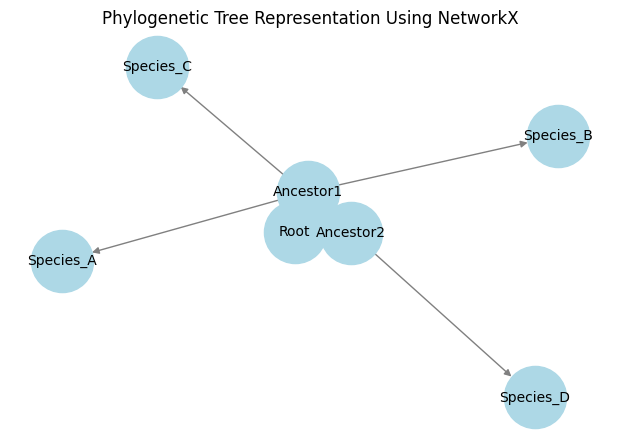

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges representing evolutionary relationships
edges = [
    ("Root", "Ancestor1"),
    ("Root", "Ancestor2"),
    ("Ancestor1", "Species_A"),
    ("Ancestor1", "Species_B"),
    ("Ancestor2", "Species_C"),
    ("Ancestor2", "Species_D")
]

G.add_edges_from(edges)

# Draw the tree
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)  # Layout for visualization
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10)
plt.title("Phylogenetic Tree Representation Using NetworkX")
plt.show()


In [12]:
r = {'is_claimed': 'True', 'rating': 3.5}
r = json.dumps(r)
loaded_r = json.loads(r)
loaded_r['rating'] #Output 3.5
type(r) #Output str
type(loaded_r)

dict

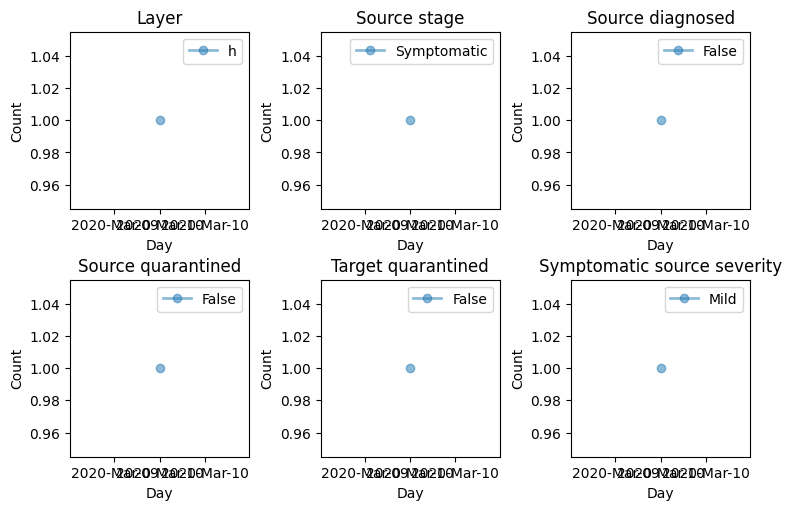

/Users/sanaz/Library/Python/3.9/lib/python/site-packages/covasim/analysis.py:2278: RuntimeWarning: invalid value encountered in divide
  sorted_sum = sorted_sum/sorted_sum.max()*100
/Users/sanaz/Library/Python/3.9/lib/python/site-packages/sciris/sc_colors.py:261: RuntimeWarning: invalid value encountered in divide
  vector = (vector - minval)/diff # Normalize vector
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


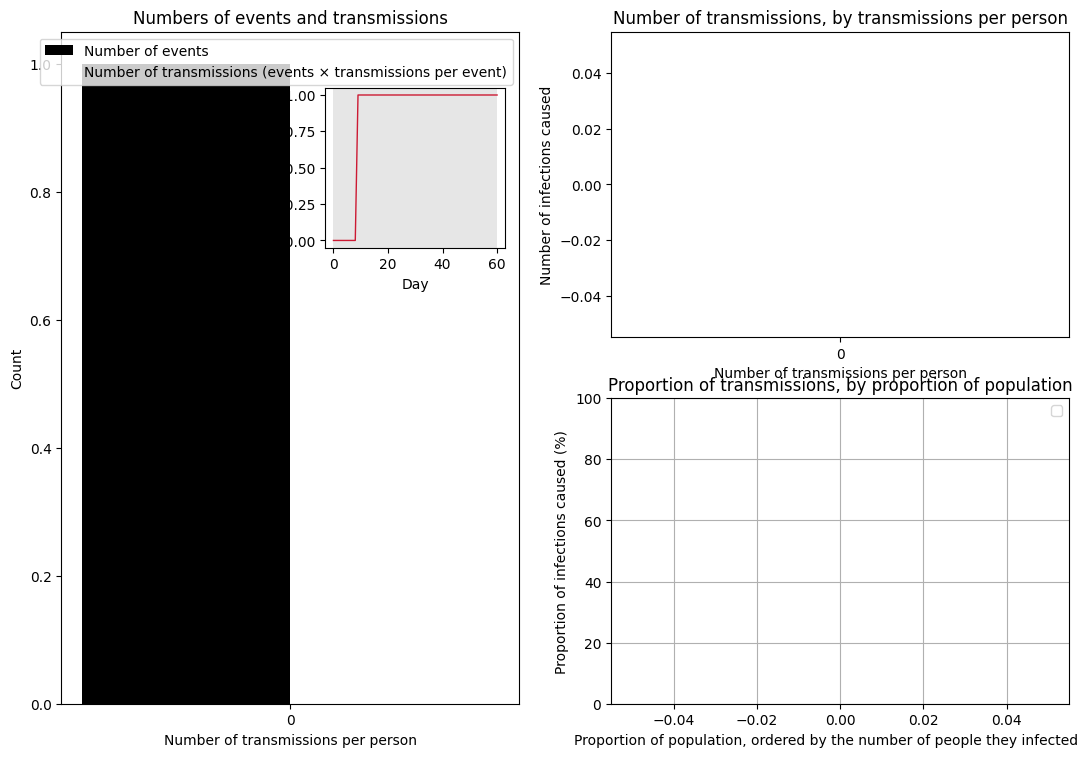

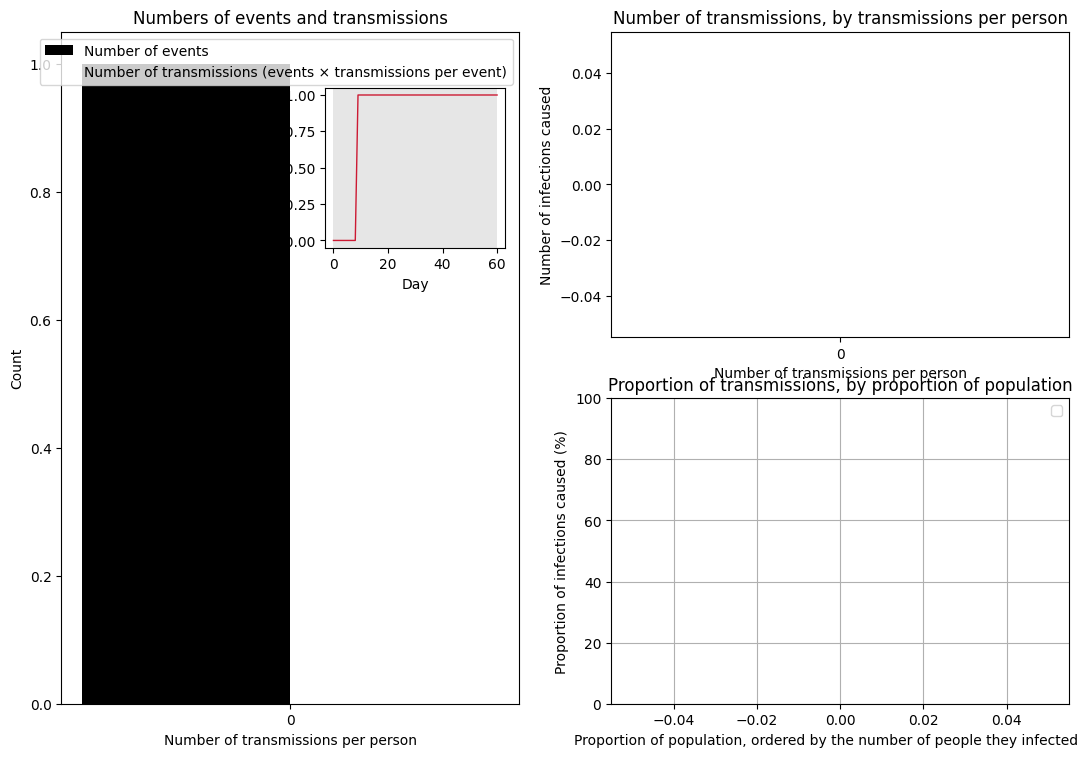

In [9]:
tt.plot()
tt.plot_histograms()

In [5]:
import json
from ete3 import Tree

r = ttt['infection_log']
r = json.dumps(r)
loaded_r = json.loads(r)

# Load JSON file
with open(loaded_r, "r") as f:
    data = json.load(f)

# Assuming JSON stores a Newick string:
newick_str = data["newick"]  # Ensure your JSON structure has a Newick key
tree = Tree(newick_str)

# Show tree structure
print(tree.get_ascii(show_internal=True))

TypeError: unhashable type: 'list'

In [10]:
r

'[{"source": null, "target": 0, "date": 0, "layer": "seed_infection", "variant": "wild"}, {"source": null, "target": 1, "date": 0, "layer": "seed_infection", "variant": "wild"}, {"source": null, "target": 2, "date": 0, "layer": "seed_infection", "variant": "wild"}, {"source": null, "target": 3, "date": 0, "layer": "seed_infection", "variant": "wild"}, {"source": null, "target": 4, "date": 0, "layer": "seed_infection", "variant": "wild"}, {"source": null, "target": 5, "date": 0, "layer": "seed_infection", "variant": "wild"}, {"source": null, "target": 6, "date": 0, "layer": "seed_infection", "variant": "wild"}, {"source": null, "target": 7, "date": 0, "layer": "seed_infection", "variant": "wild"}, {"source": null, "target": 8, "date": 0, "layer": "seed_infection", "variant": "wild"}, {"source": null, "target": 9, "date": 0, "layer": "seed_infection", "variant": "wild"}, {"source": null, "target": 10, "date": 0, "layer": "seed_infection", "variant": "wild"}, {"source": null, "target": 11

In [11]:
r = tt.to_json()
# r = json.dumps(r)
# loaded_r = json.loads(r)
type(loaded_r)

dict

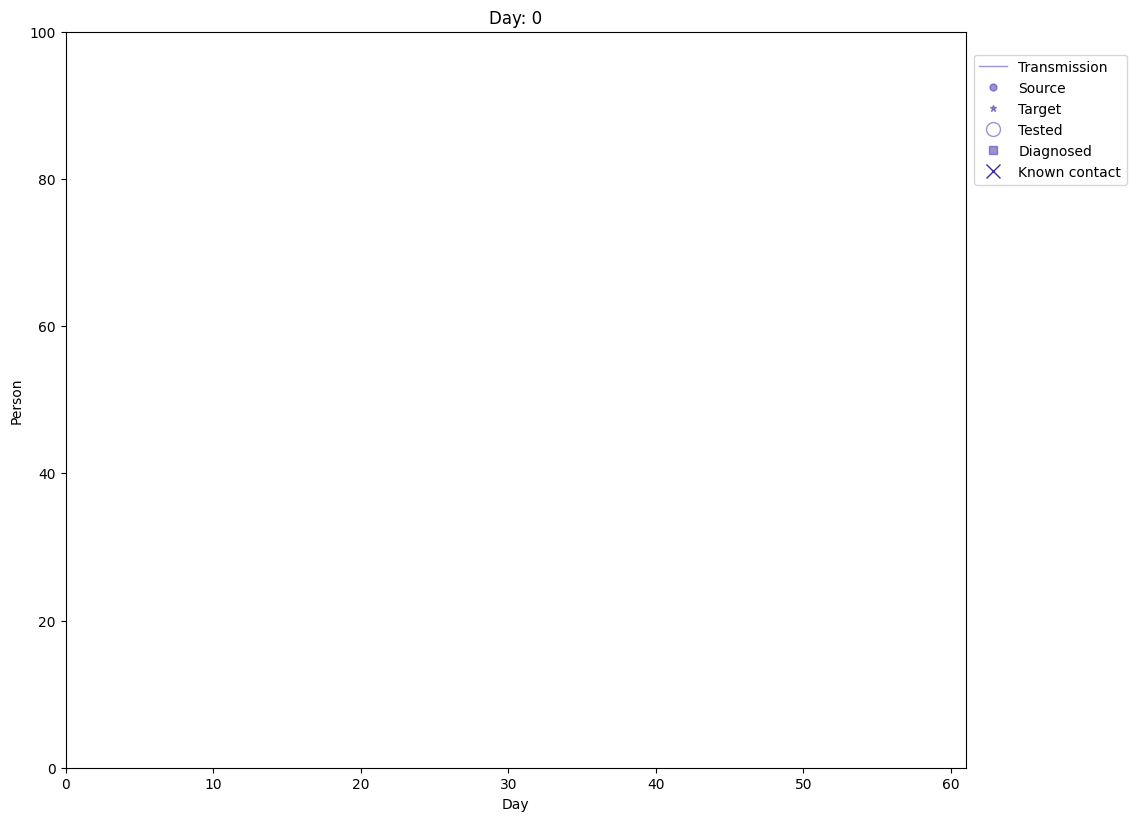

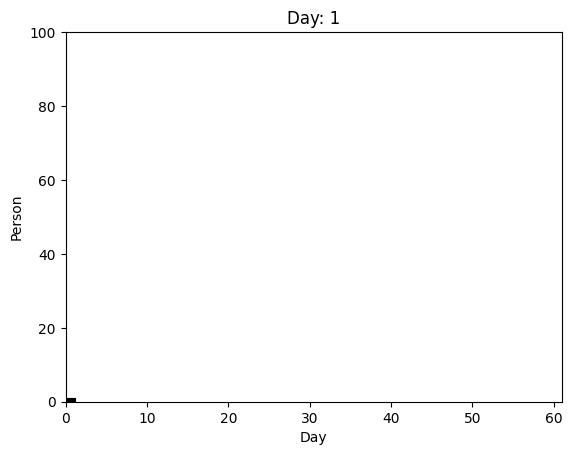

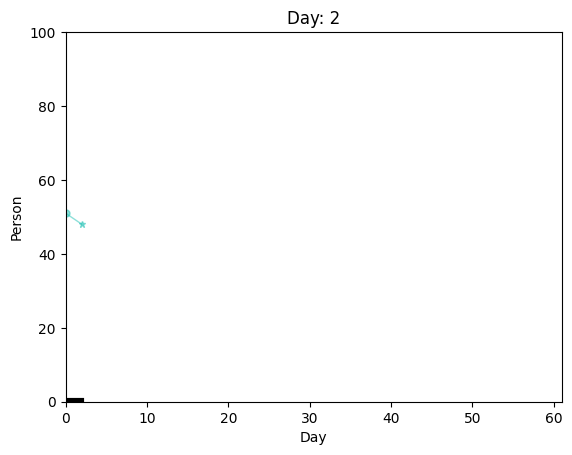

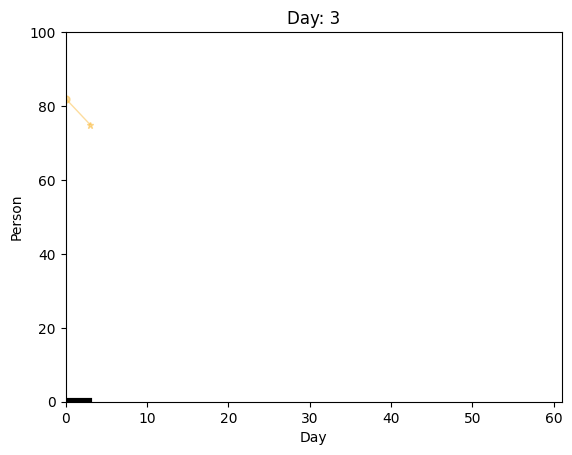

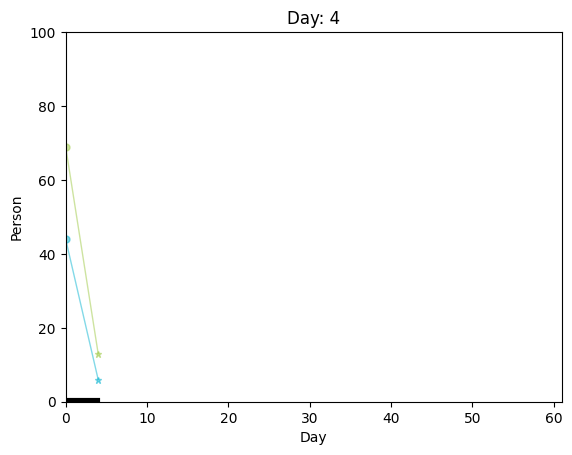

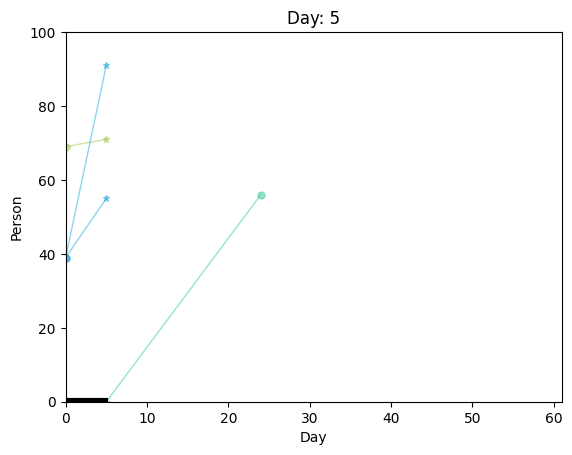

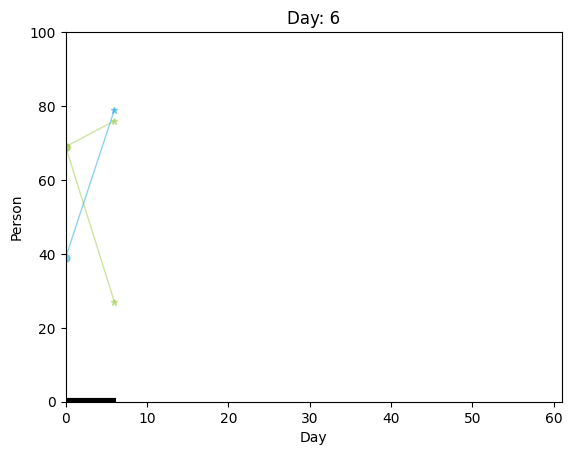

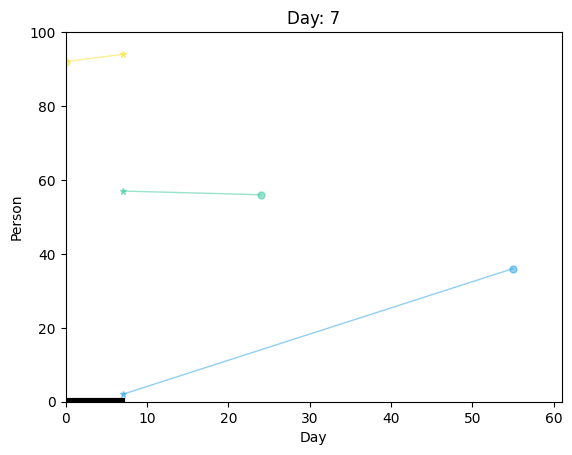

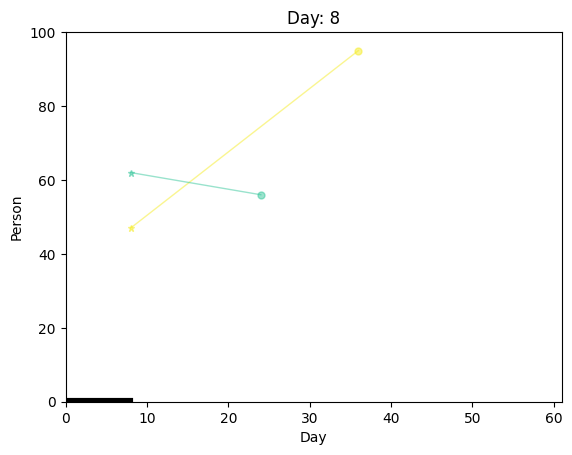

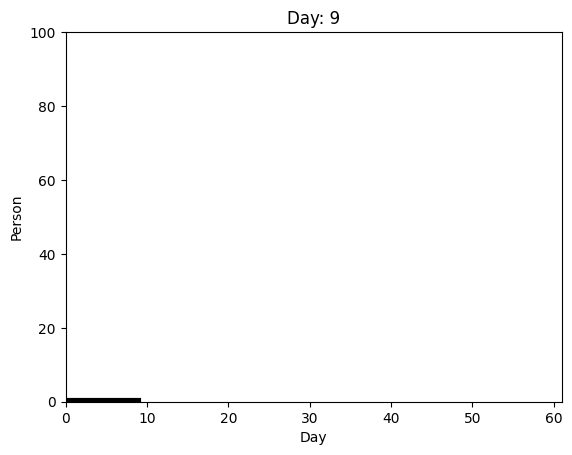

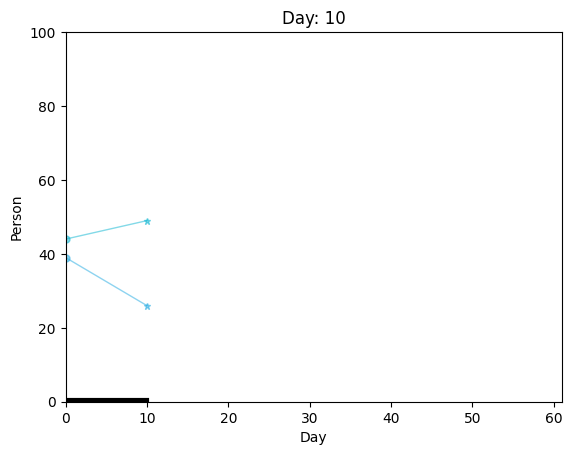

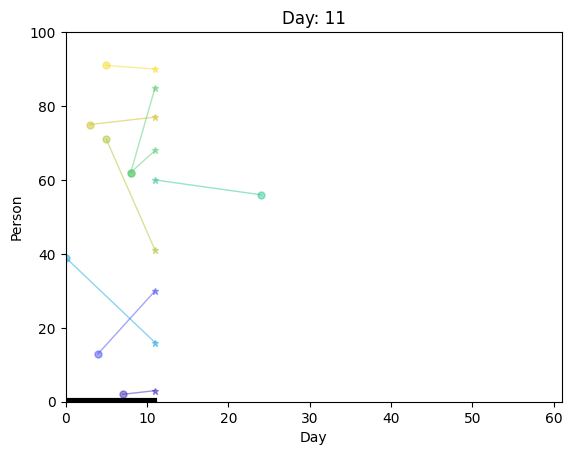

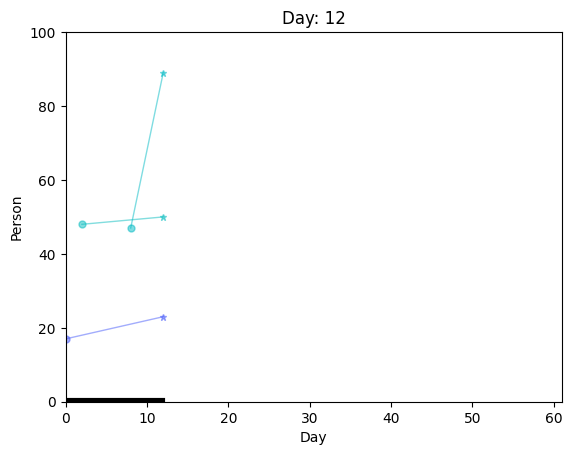

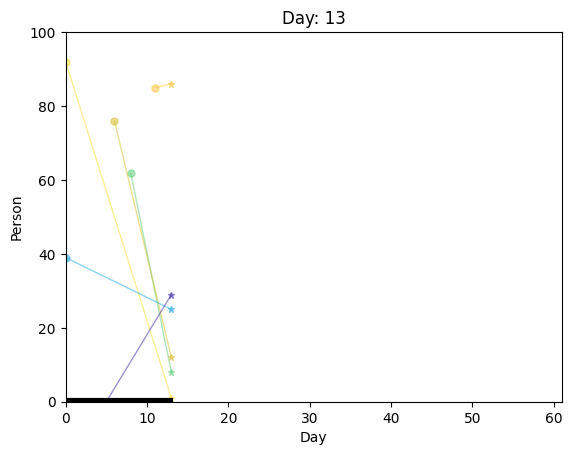

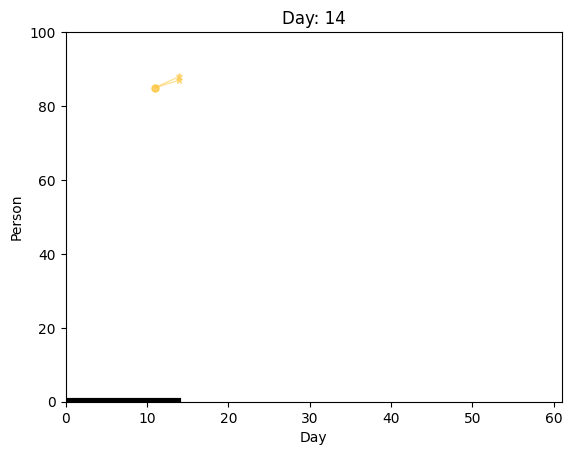

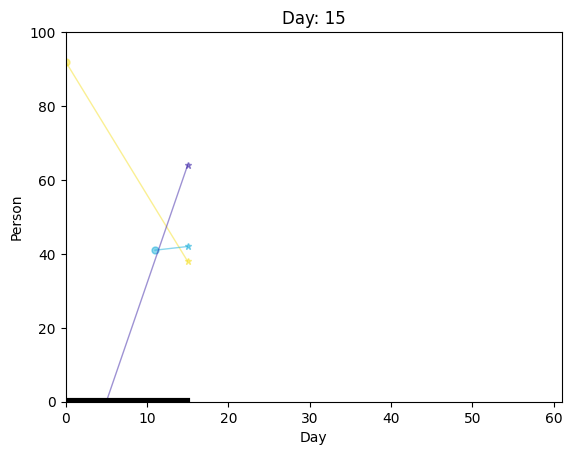

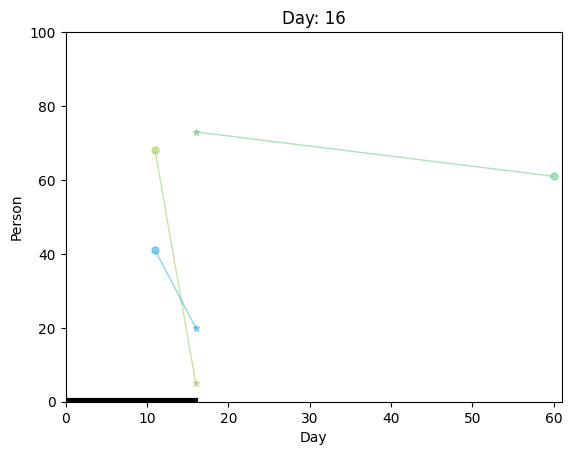

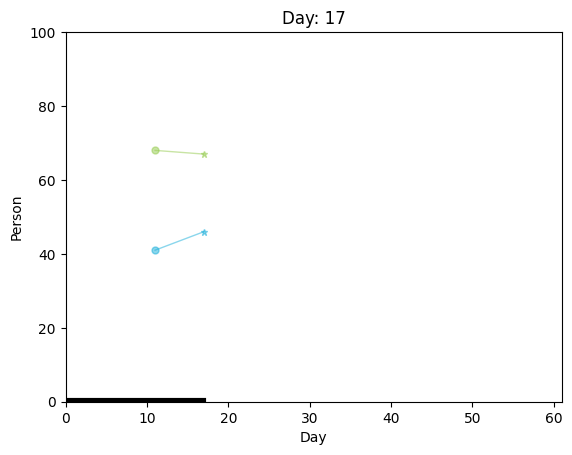

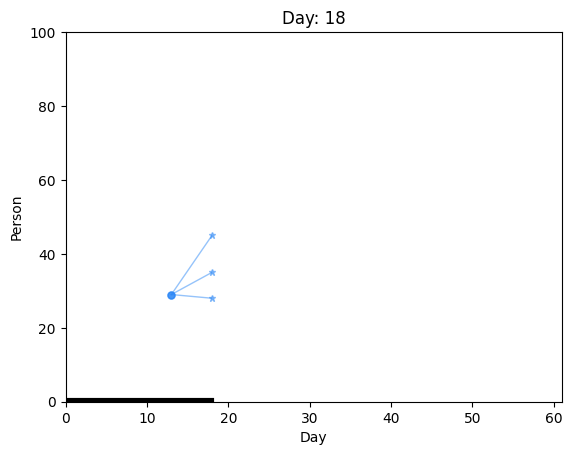

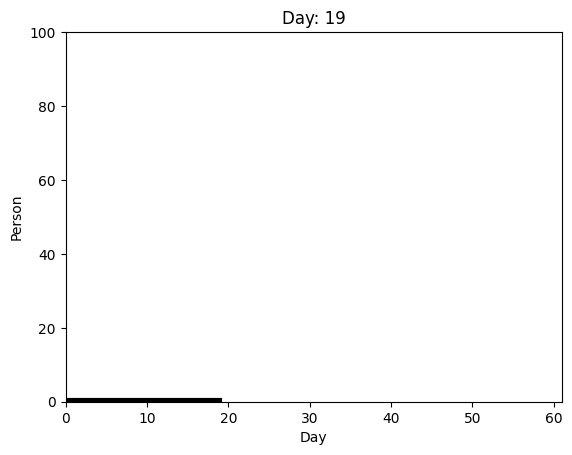

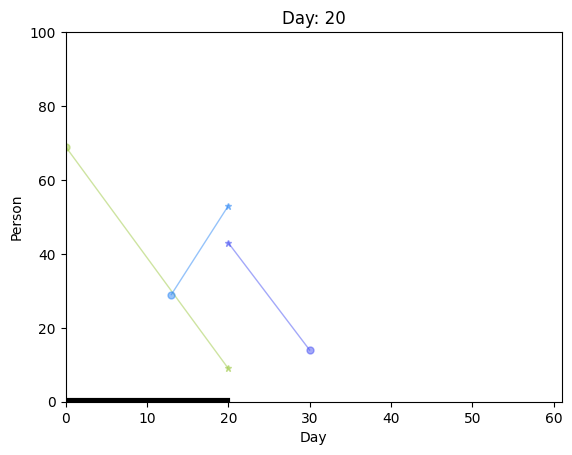

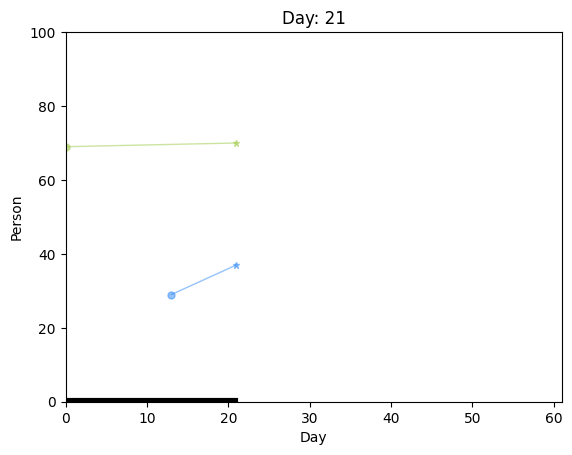

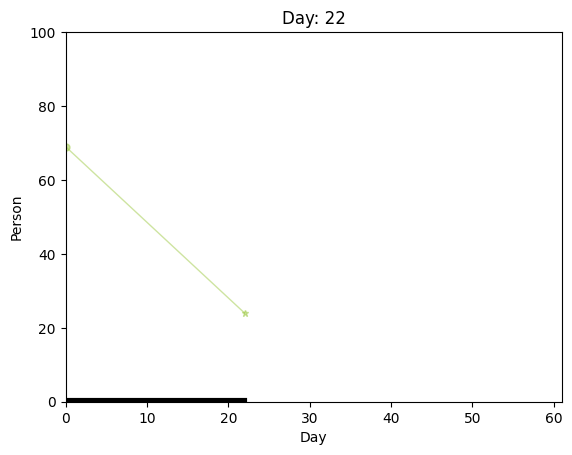

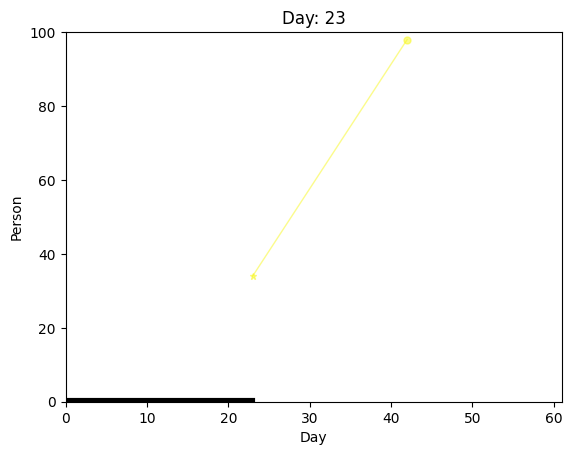

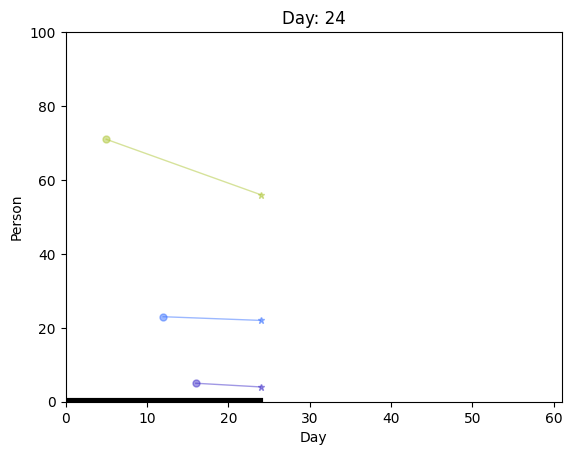

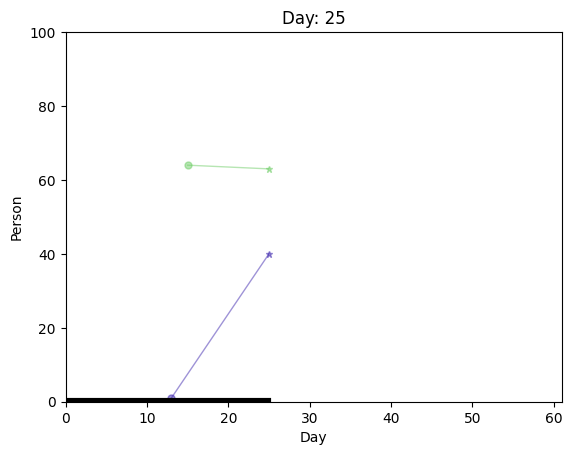

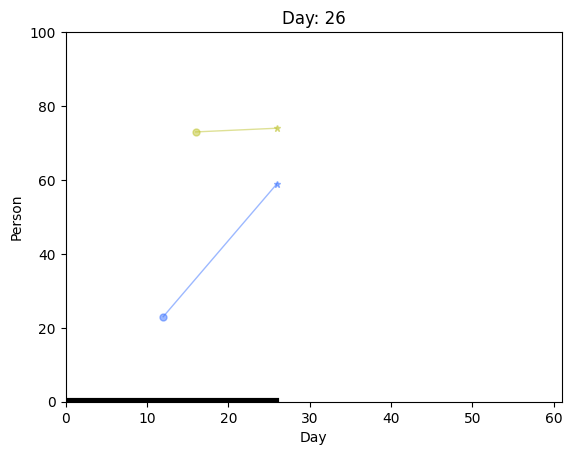

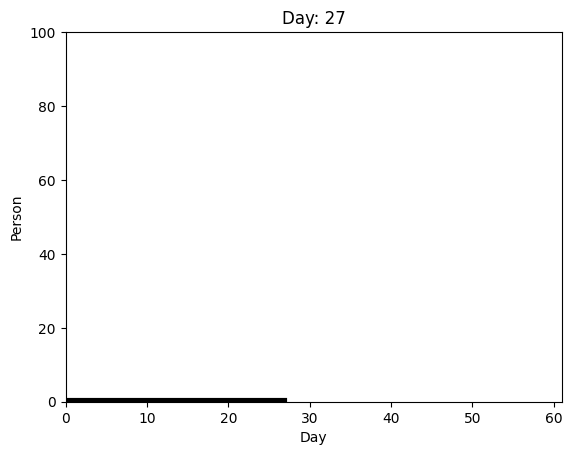

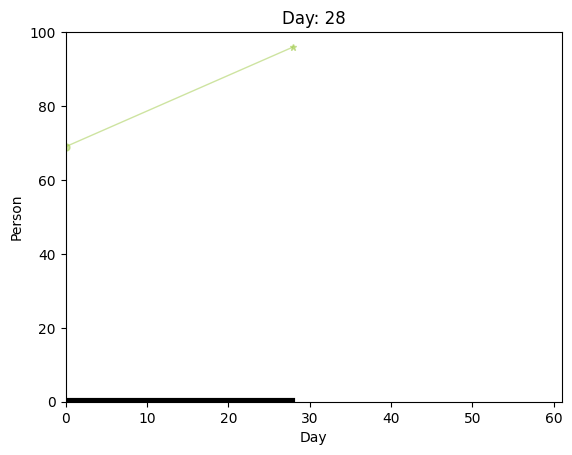

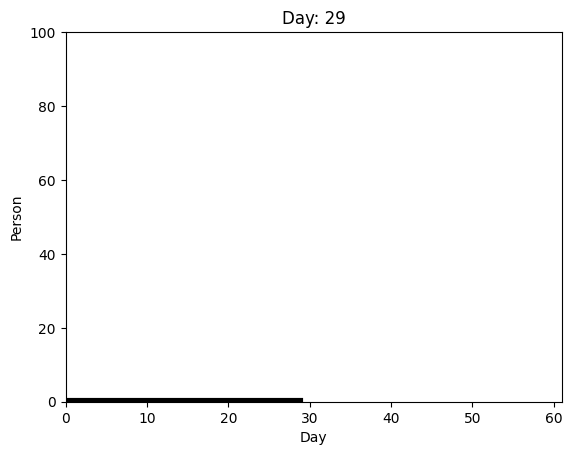

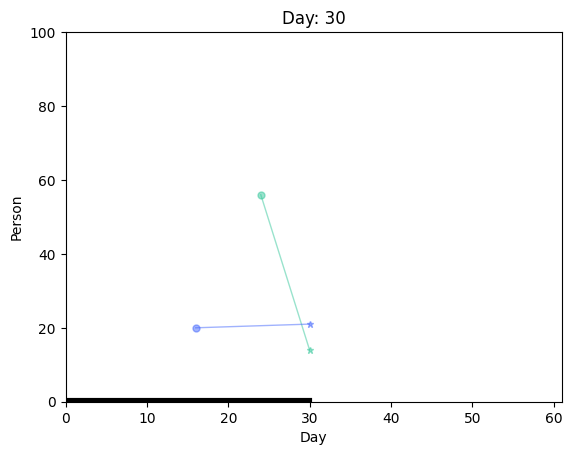

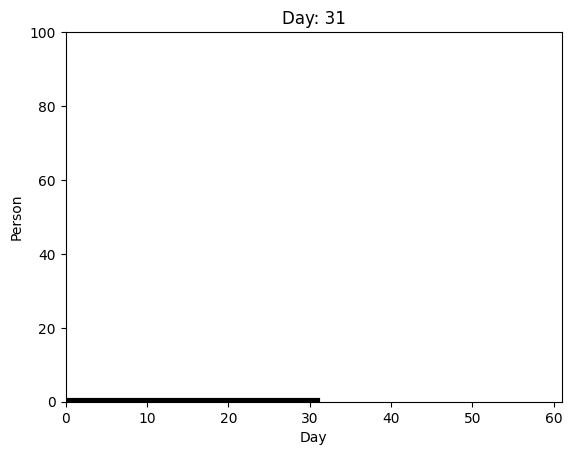

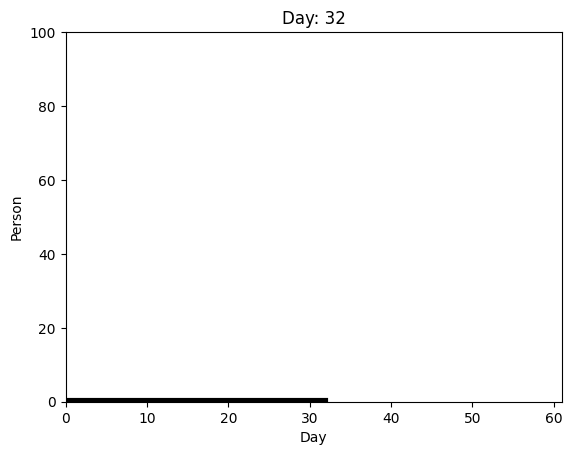

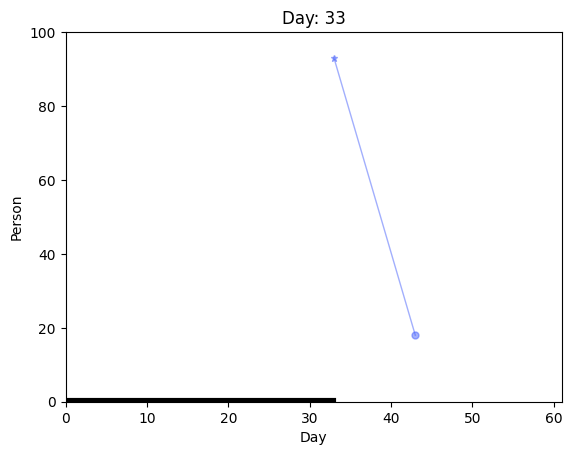

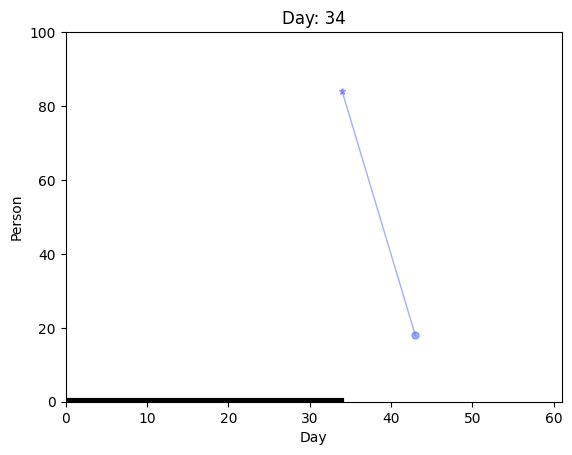

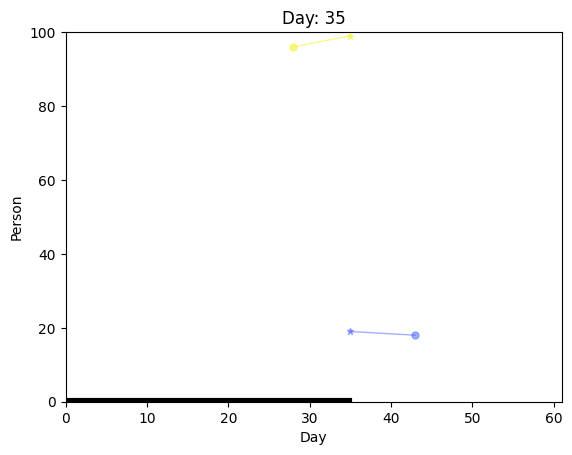

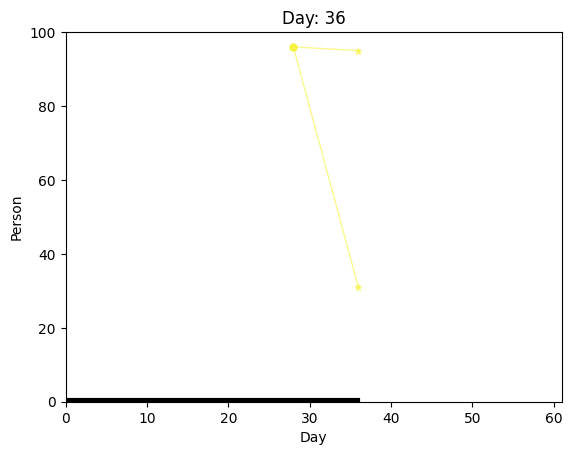

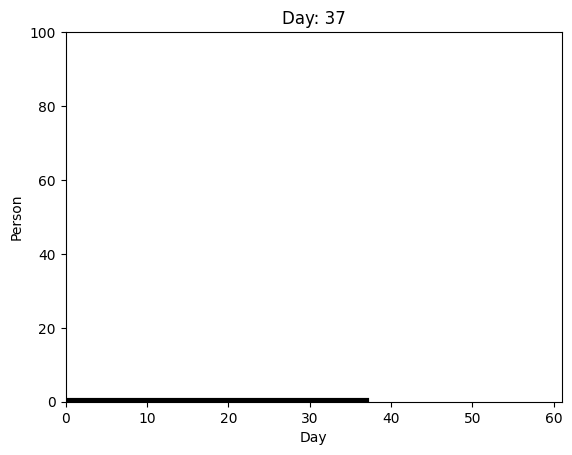

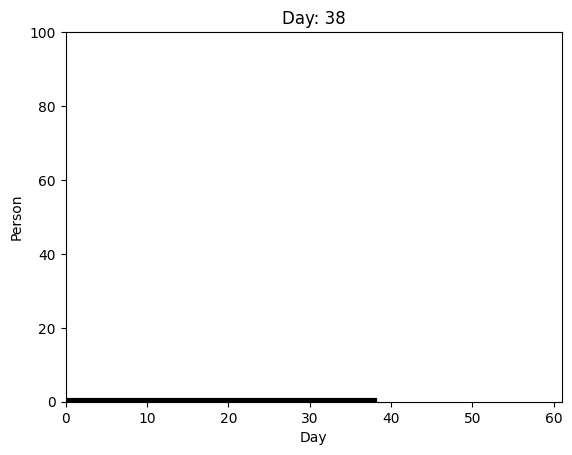

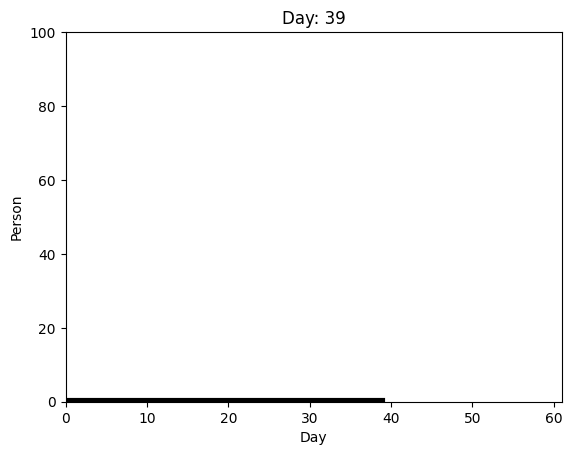

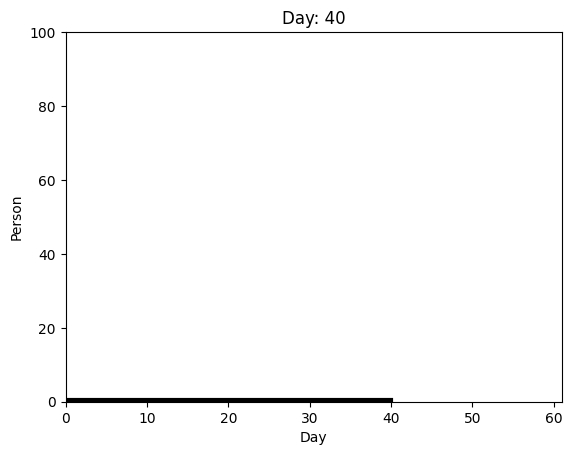

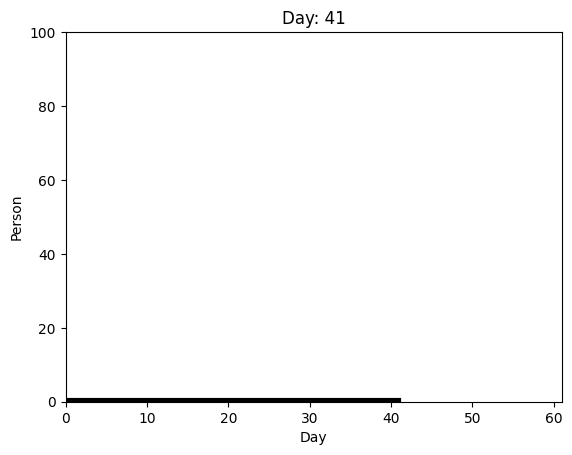

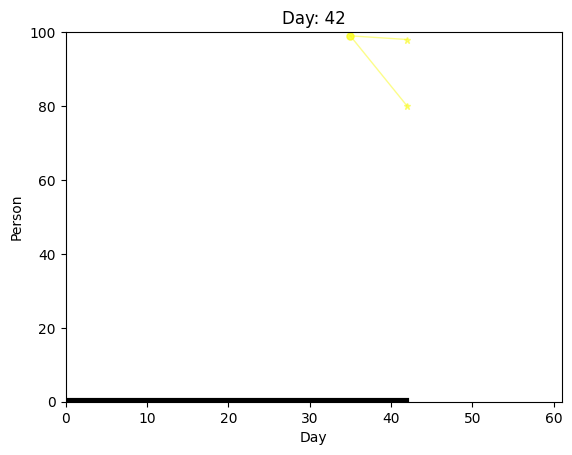

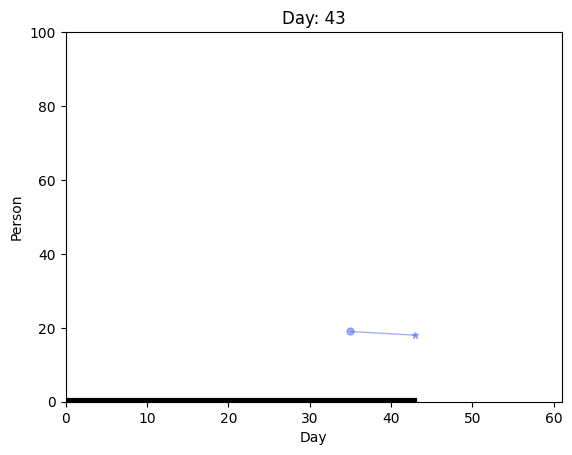

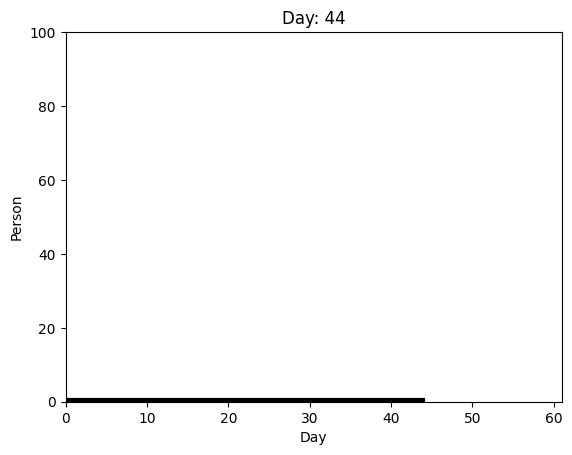

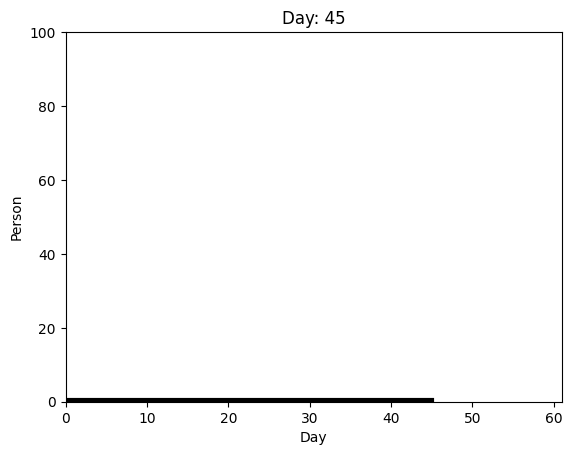

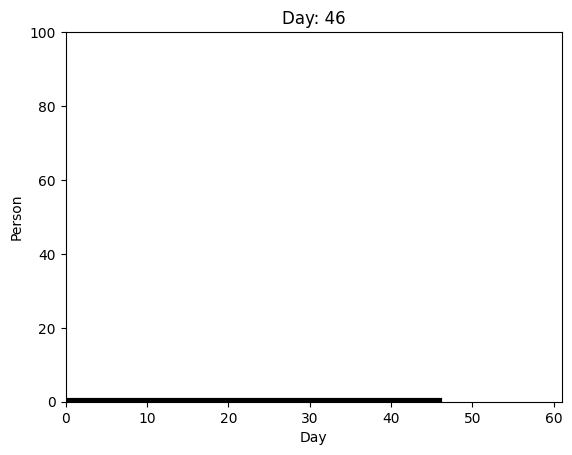

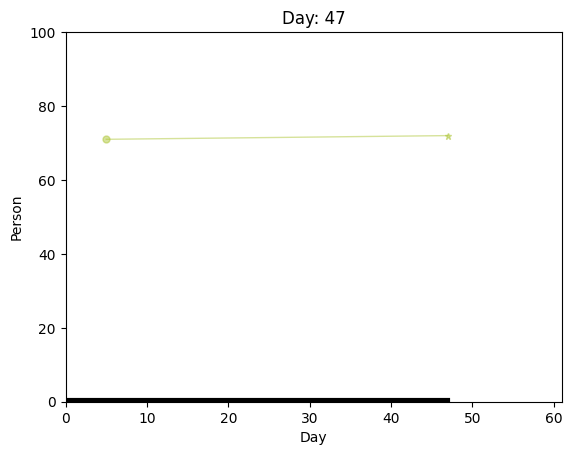

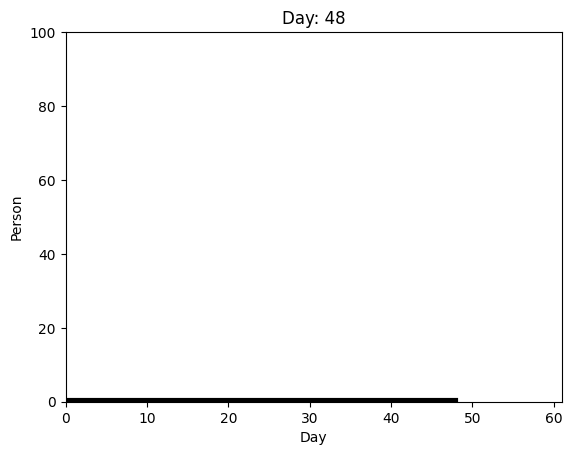

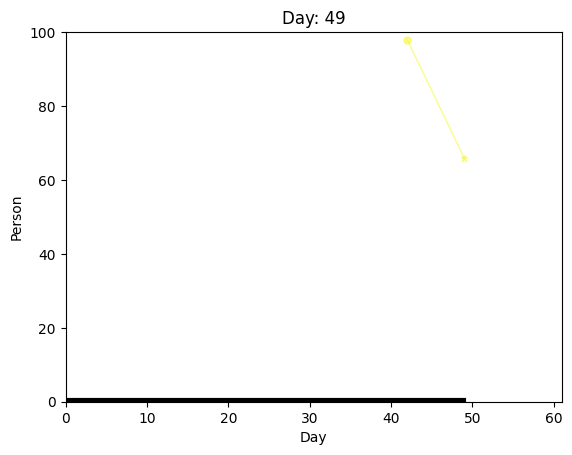

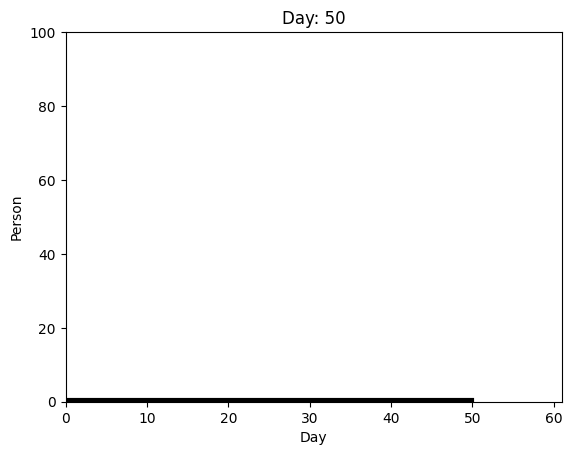

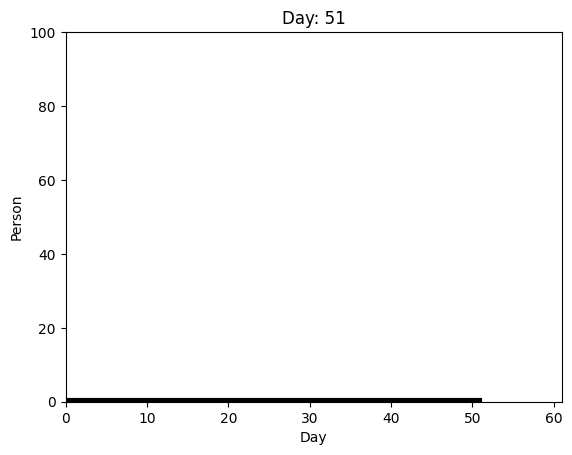

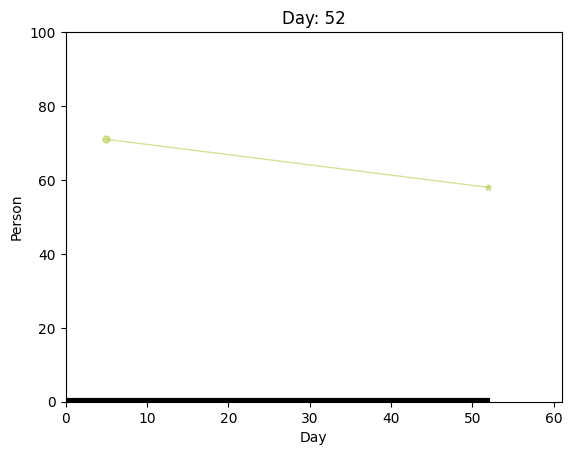

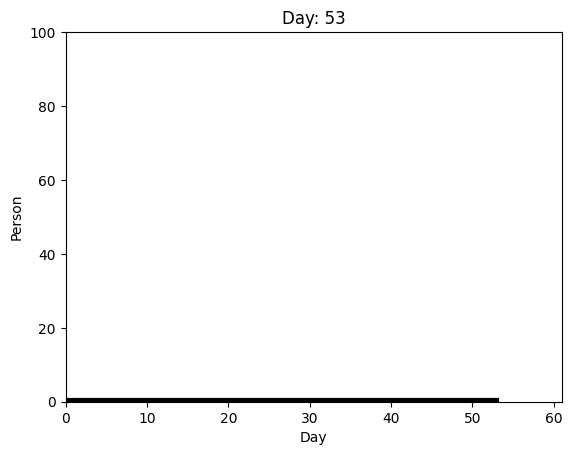

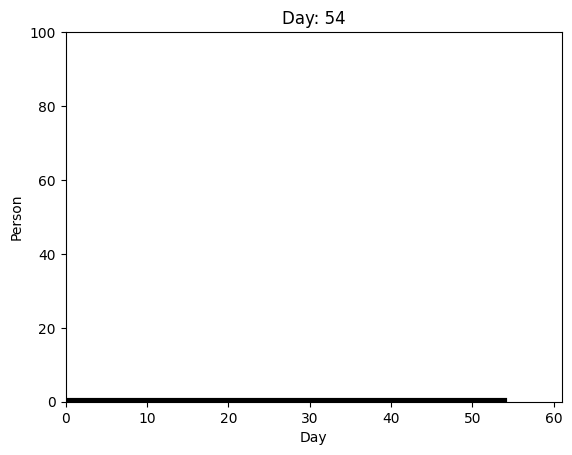

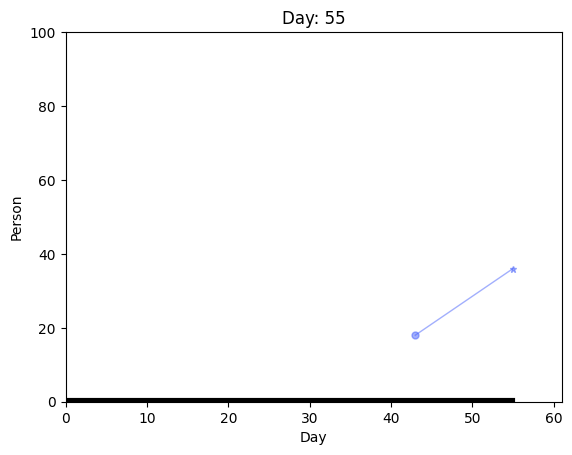

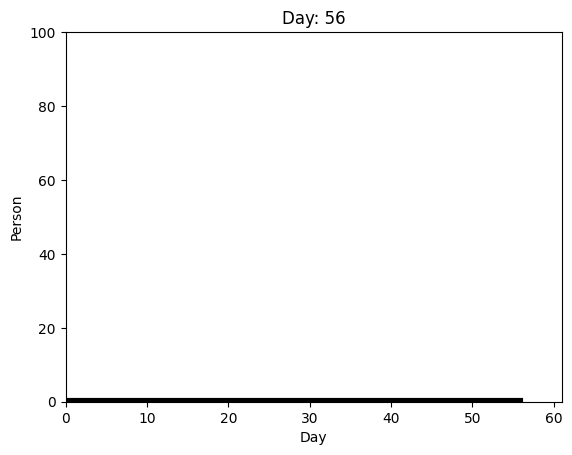

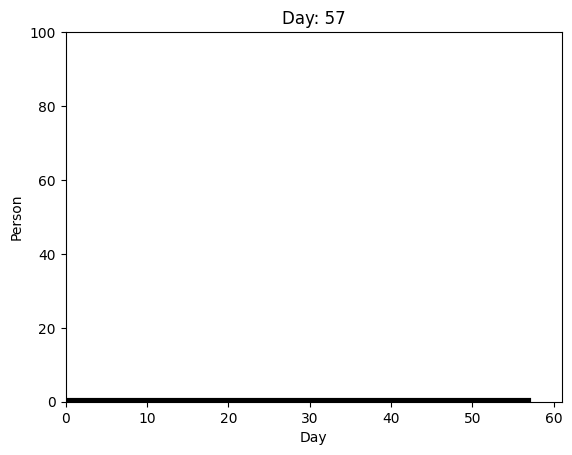

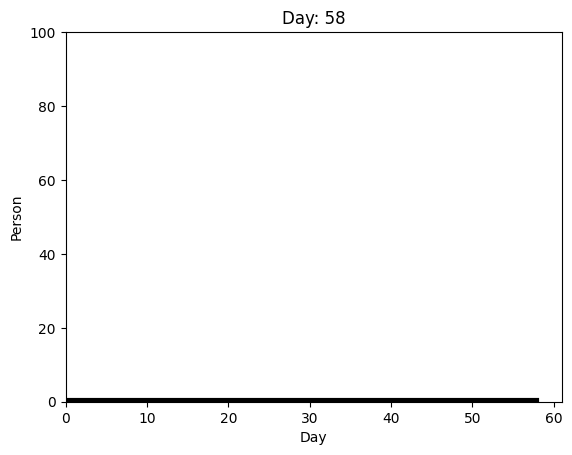

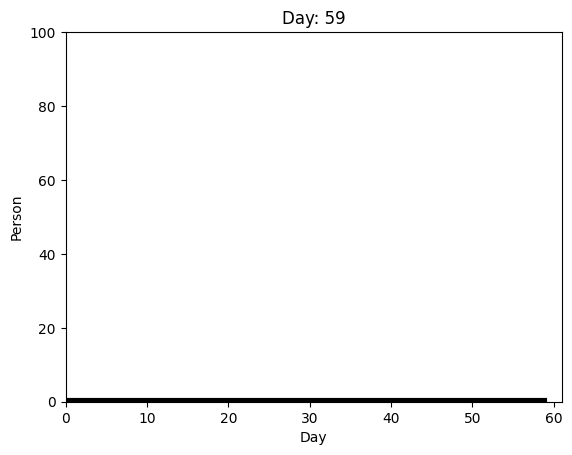

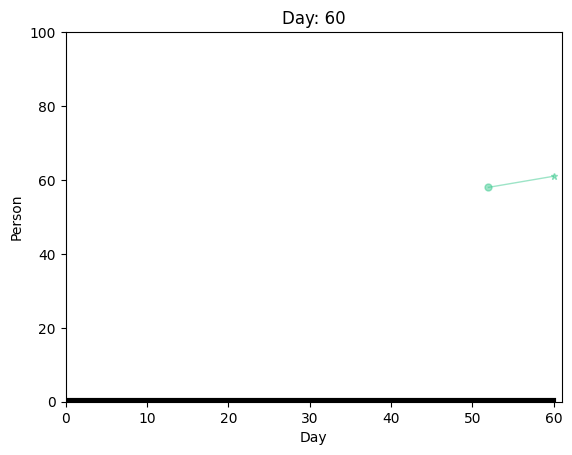

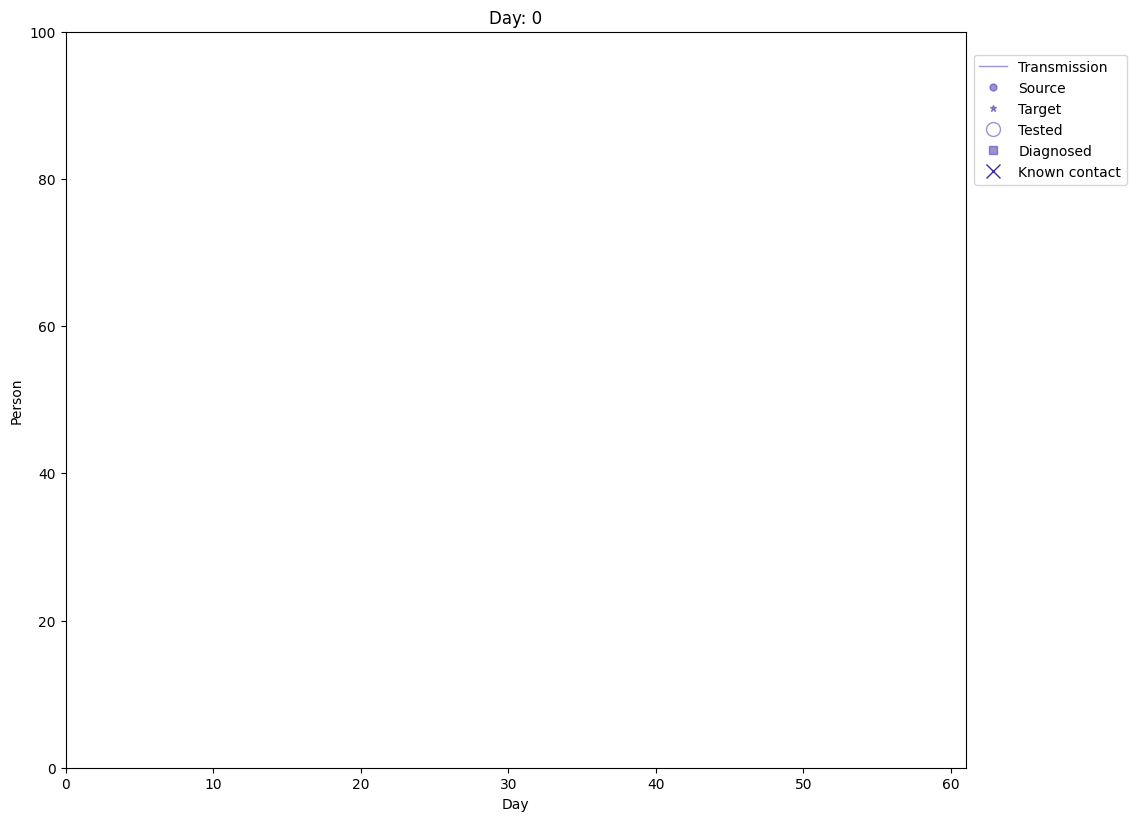

In [44]:
tt.animate()

In [43]:
max(i for i in a if i != None)

60

In [1]:
from ete3 import PhyloTree, TreeStyle

alg = """
 >Dme_001
 MAEIPDETIQQFMALT---HNIAVQYLSEFGDLNEAL--YYASQTDDIKDRREEAH
 >Dme_002
 MAEIPDATIQQFMALTNVSHNIAVQY--EFGDLNEALNSYYAYQTDDQKDRREEAH
 >Cfa_001
 MAEIPDATIQ---ALTNVSHNIAVQYLSEFGDLNEALNSYYASQTDDQPDRREEAH
 >Mms_001
 MAEAPDETIQQFMALTNVSHNIAVQYLSEFGDLNEAL--------------REEAH
 >Hsa_001
 MAEIPDETIQQFMALT---HNIAVQYLSEFGDLNEALNSYYASQTDDIKDRREEAH
 >Ptr_002
 MAEIPDATIQ-FMALTNVSHNIAVQY--EFGDLNEALNSY--YQTDDQKDRREEAH
 >Mmu_002
 MAEIPDATIQ---ALTNVSHNIAVQYLSEFGDLNEALNSYYASQTDDQPDRREEAH
 >Hsa_002
 MAEAPDETIQQFM-LTNVSHNIAVQYLSEFGDLNEAL--------------REEAH
 >Mmu_001
 MAEIPDETIQQFMALT---HNIAVQYLSEFGDLNEALNSYYASQTDDIKDRREEAH
 >Ptr_001
 MAEIPDATIQ-FMALTNVSHNIAVQY--EFGDLNEALNSY--YQTDDQKDRREEAH
 >Mmu_001
 MAEIPDATIQ---ALTNVSHNIAVQYLSEFGDLNEALNSYYASQTDDQPDRREEAH
"""

def get_example_tree():

    # Performs a tree reconciliation analysis
    gene_tree_nw = '((Dme_001,Dme_002),(((Cfa_001,Mms_001),((Hsa_001,Ptr_001),Mmu_001)),(Ptr_002,(Hsa_002,Mmu_002))));'
    species_tree_nw = "((((Hsa, Ptr), Mmu), (Mms, Cfa)), Dme);"
    genetree = PhyloTree(gene_tree_nw)
    sptree = PhyloTree(species_tree_nw)
    recon_tree, events = genetree.reconcile(sptree)
    recon_tree.link_to_alignment(alg)
    return recon_tree, TreeStyle()

if __name__ == "__main__":
    # Visualize the reconciled tree
    t, ts = get_example_tree()
    t.show(tree_style=ts)
    #recon_tree.render("phylotree.png", w=750)

Duplicated entry [Mmu_001] was renamed to [1_Mmu_001]
Warnning: [5] terminal nodes could not be found in the alignment.
qt.qpa.fonts: Populating font family aliases took 167 ms. Replace uses of missing font family "Courier" with one that exists to avoid this cost. 


Initializing sim with 20000 people for 60 days
  Running 2020-03-01 ( 0/60) (0.09 s)  ———————————————————— 2%
  Running 2020-03-11 (10/60) (0.11 s)  •••————————————————— 18%
  Running 2020-03-21 (20/60) (0.12 s)  ••••••—————————————— 34%
  Running 2020-03-31 (30/60) (0.14 s)  ••••••••••—————————— 51%
  Running 2020-04-10 (40/60) (0.16 s)  •••••••••••••——————— 67%
  Running 2020-04-20 (50/60) (0.18 s)  ••••••••••••••••———— 84%
  Running 2020-04-30 (60/60) (0.22 s)  •••••••••••••••••••• 100%

Simulation summary:
       12,730 cumulative infections
          596 cumulative reinfections
       10,182 cumulative infectious
        6,395 cumulative symptomatic cases
          386 cumulative severe cases
          114 cumulative critical cases
        5,159 cumulative recoveries
           14 cumulative deaths
            0 cumulative tests
            0 cumulative diagnoses
            0 cumulative known deaths
            0 cumulative quarantined people
            0 cumulative isolated peo

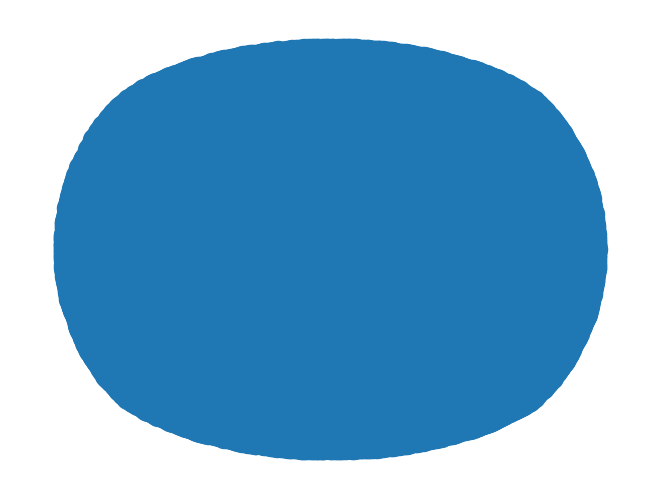

In [16]:
import covasim as cv
import networkx as nx
import matplotlib.pyplot as plt

sim = cv.Sim().run()
a = cv.TransTree(sim, to_networkx=True)

nx.draw(a.graph)
plt.show()

# tt = sim.make_transtree()
# tt.plot()
# tt.plot_histograms()
# tt.detailed.to_dict('records')

In [2]:
pars = dict(
    pop_size = 50e3,
    pop_infected = 100,
    start_day = '2020-04-01',
    end_day = '2020-06-01',
)

In [3]:
sim = cv.Sim(pars)
sim.run()

Initializing sim with 50000 people for 61 days
  Running 2020-04-01 ( 0/61) (0.14 s)  ———————————————————— 2%
  Running 2020-04-11 (10/61) (0.17 s)  •••————————————————— 18%
  Running 2020-04-21 (20/61) (0.20 s)  ••••••—————————————— 34%
  Running 2020-05-01 (30/61) (0.25 s)  ••••••••••—————————— 50%
  Running 2020-05-11 (40/61) (0.30 s)  •••••••••••••——————— 66%
  Running 2020-05-21 (50/61) (0.38 s)  ••••••••••••••••———— 82%
  Running 2020-05-31 (60/61) (0.47 s)  •••••••••••••••••••— 98%
Simulation summary:
       41,466 cumulative infections
        3,679 cumulative reinfections
       36,997 cumulative infectious
       24,043 cumulative symptomatic cases
        1,542 cumulative severe cases
          475 cumulative critical cases
       24,320 cumulative recoveries
           86 cumulative deaths
            0 cumulative tests
            0 cumulative diagnoses
            0 cumulative known deaths
            0 cumulative quarantined people
            0 cumulative isolated peopl

Sim(<no label>; 2020-04-01 to 2020-06-01; pop: 50000 random; epi: 41466⚙, 86☠)

In [4]:
####### new infections per day
sim.results['new_infections']

[<class 'covasim.base.Result'>]
————————————————————————————————————————————————————————————————————————
Properties:
  npts                    
————————————————————————————————————————————————————————————————————————
color: #b62413
 name: Number of new infections
scale: True
————————————————————————————————————————————————————————————————————————
values:
array([   0.,    0.,    3.,   12.,   30.,   30.,   35.,   41.,   37.,
         58.,   65.,   84.,   78.,   83.,   97.,  110.,  134.,  154.,
        185.,  203.,  222.,  188.,  237.,  263.,  327.,  355.,  383.,
        421.,  461.,  556.,  562.,  609.,  730.,  755.,  830.,  837.,
        897.,  963., 1010., 1157., 1156., 1233., 1340., 1418., 1369.,
       1386., 1469., 1526., 1448., 1547., 1489., 1440., 1425., 1312.,
       1276., 1192., 1195., 1104., 1050.,  962.,  982.,  845.])

In [5]:
sim = cv.Sim(pop_size=50e3, pop_infected=100, start_day='2020-04-01', end_day='2020-06-01')
sim.run()

Initializing sim with 50000 people for 61 days
  Running 2020-04-01 ( 0/61) (0.11 s)  ———————————————————— 2%
  Running 2020-04-11 (10/61) (0.14 s)  •••————————————————— 18%
  Running 2020-04-21 (20/61) (0.18 s)  ••••••—————————————— 34%
  Running 2020-05-01 (30/61) (0.22 s)  ••••••••••—————————— 50%
  Running 2020-05-11 (40/61) (0.28 s)  •••••••••••••——————— 66%
  Running 2020-05-21 (50/61) (0.35 s)  ••••••••••••••••———— 82%
  Running 2020-05-31 (60/61) (0.45 s)  •••••••••••••••••••— 98%
Simulation summary:
       41,466 cumulative infections
        3,679 cumulative reinfections
       36,997 cumulative infectious
       24,043 cumulative symptomatic cases
        1,542 cumulative severe cases
          475 cumulative critical cases
       24,320 cumulative recoveries
           86 cumulative deaths
            0 cumulative tests
            0 cumulative diagnoses
            0 cumulative known deaths
            0 cumulative quarantined people
            0 cumulative isolated peopl

Sim(<no label>; 2020-04-01 to 2020-06-01; pop: 50000 random; epi: 41466⚙, 86☠)

In [6]:
sim = cv.Sim(pars, pop_infected=10) # Use parameters defined above, except start with 10 infected people
sim.run()

Initializing sim with 50000 people for 61 days
  Running 2020-04-01 ( 0/61) (0.11 s)  ———————————————————— 2%
  Running 2020-04-11 (10/61) (0.14 s)  •••————————————————— 18%
  Running 2020-04-21 (20/61) (0.17 s)  ••••••—————————————— 34%
  Running 2020-05-01 (30/61) (0.20 s)  ••••••••••—————————— 50%
  Running 2020-05-11 (40/61) (0.23 s)  •••••••••••••——————— 66%
  Running 2020-05-21 (50/61) (0.27 s)  ••••••••••••••••———— 82%
  Running 2020-05-31 (60/61) (0.31 s)  •••••••••••••••••••— 98%
Simulation summary:
       10,392 cumulative infections
          128 cumulative reinfections
        6,710 cumulative infectious
        4,185 cumulative symptomatic cases
          195 cumulative severe cases
           51 cumulative critical cases
        2,473 cumulative recoveries
            7 cumulative deaths
            0 cumulative tests
            0 cumulative diagnoses
            0 cumulative known deaths
            0 cumulative quarantined people
            0 cumulative isolated peopl

Sim(<no label>; 2020-04-01 to 2020-06-01; pop: 50000 random; epi: 10392⚙, 7☠)

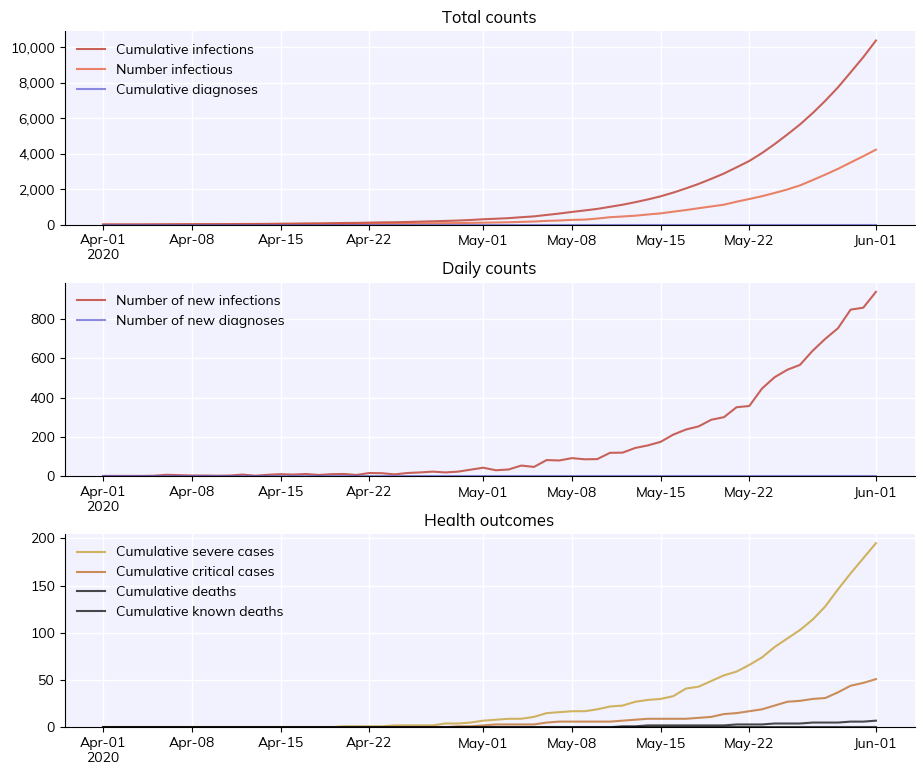

In [7]:
fig = sim.plot()

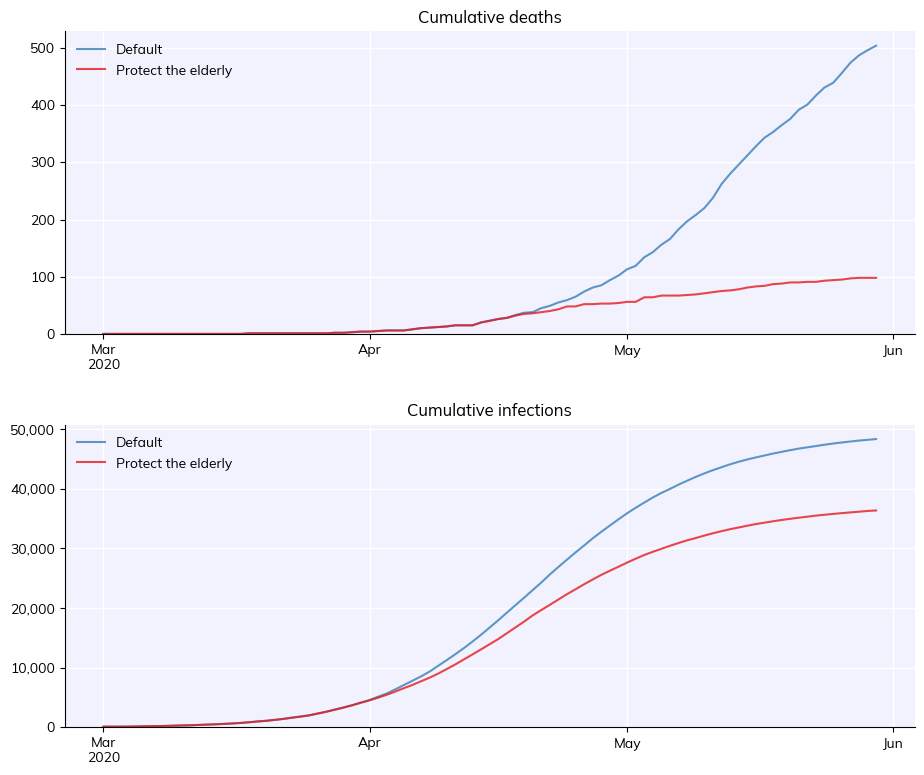

In [8]:
import covasim as cv

# Custom intervention -- see Tutorial 5
def protect_elderly(sim):
    if sim.t == sim.day('2020-04-01'):
        elderly = sim.people.age>70
        sim.people.rel_sus[elderly] = 0.0

pars = dict(
    pop_type = 'hybrid', # Use a more realistic population model
    location = 'japan', # Use population characteristics for Japan
    pop_size = 50e3, # Have 50,000 people total in the population
    pop_infected = 100, # Start with 100 infected people
    n_days = 90, # Run the simulation for 90 days
    verbose = 0, # Do not print any output
)

# Running with multisims -- see Tutorial 3
s1 = cv.Sim(pars, label='Default')
s2 = cv.Sim(pars, interventions=protect_elderly, label='Protect the elderly')
msim = cv.MultiSim([s1, s2])
msim.run()
fig = msim.plot(['cum_deaths', 'cum_infections'])

In [9]:
###### There are three levels of detail available for most objects (sims, multisims, scenarios, and people). The shortest is brief():
sim.brief()

Sim(<no label>; 2020-04-01 to 2020-06-01; pop: 50000 random; epi: 10392⚙, 7☠)


In [10]:
sim.summarize()

Simulation summary:
       10,392 cumulative infections
          128 cumulative reinfections
        6,710 cumulative infectious
        4,185 cumulative symptomatic cases
          195 cumulative severe cases
           51 cumulative critical cases
        2,473 cumulative recoveries
            7 cumulative deaths
            0 cumulative tests
            0 cumulative diagnoses
            0 cumulative known deaths
            0 cumulative quarantined people
            0 cumulative isolated people
            0 cumulative vaccine doses
            0 cumulative vaccinated people



In [11]:
#######to show the full object, including all methods and attributes, use disp():
sim.disp()

[<class 'covasim.sim.Sim'>, <class 'covasim.base.BaseSim'>, <class 'covasim.base.ParsObj'>, <class 'covasim.base.FlexPretty'>, <class 'sciris.sc_printing.prettyobj'>]
————————————————————————————————————————————————————————————————————————
Methods:
  _brief()                finalize_analyzers()    plot()                  
  _disp()                 finalize_interventi...  plot_result()           
  _get_ia()               get_analyzer()          rescale()               
  brief()                 get_analyzers()         reset_layer_pars()      
  calibrate()             get_intervention()      result_keys()           
  compute_doubling()      get_interventions()     run()                   
  compute_fit()           init_analyzers()        save()                  
  compute_gen_time()      init_immunity()         set_metadata()          
  compute_r_eff()         init_infections()       set_seed()              
  compute_results()       init_interventions()    shrink()                
 

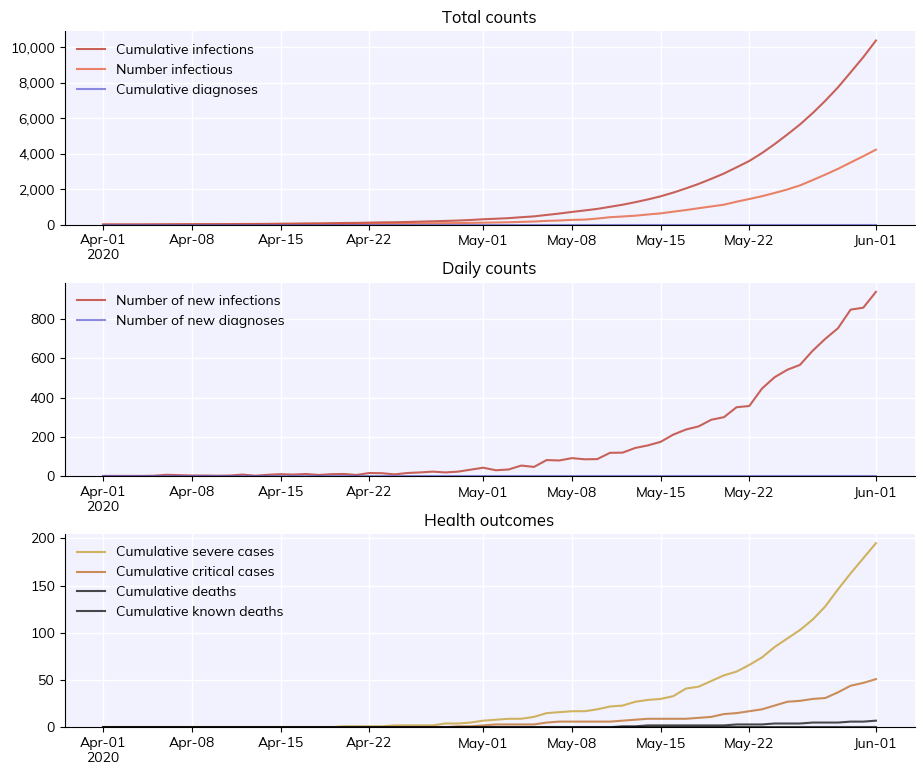

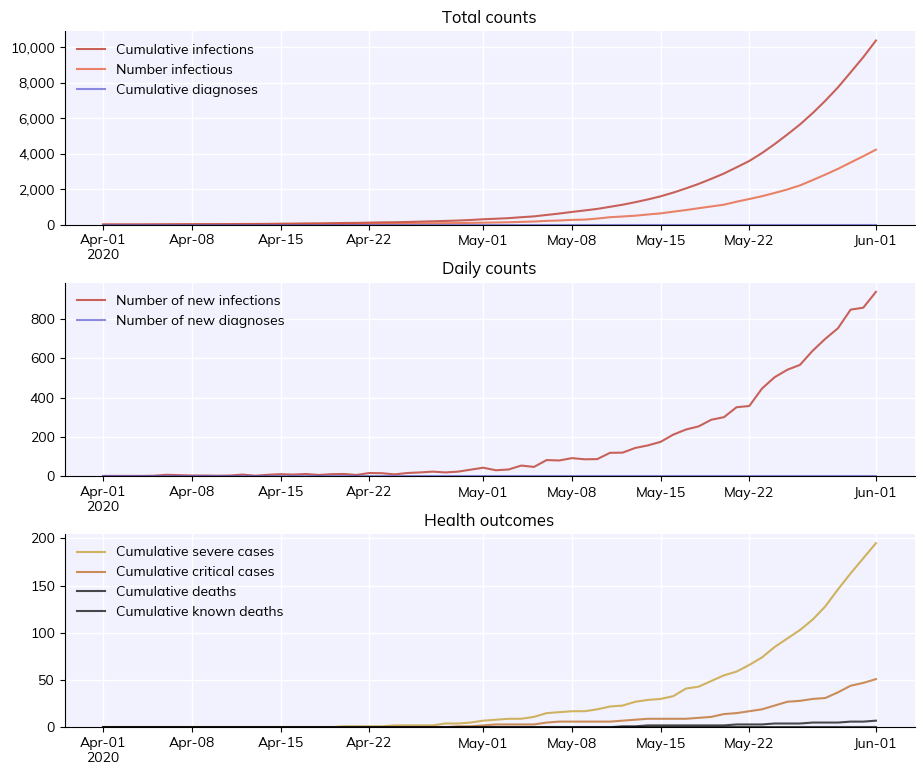

In [12]:
###### sim can be plotted using default settings simply by sim.plot()
sim.plot()

In [13]:
##### You can see what quantities are available for plotting with sim.results.keys() (remember, it’s just a dict)
sim.results.keys()

['cum_infections',
 'cum_reinfections',
 'cum_infectious',
 'cum_symptomatic',
 'cum_severe',
 'cum_critical',
 'cum_recoveries',
 'cum_deaths',
 'cum_tests',
 'cum_diagnoses',
 'cum_known_deaths',
 'cum_quarantined',
 'cum_isolated',
 'cum_doses',
 'cum_vaccinated',
 'new_infections',
 'new_reinfections',
 'new_infectious',
 'new_symptomatic',
 'new_severe',
 'new_critical',
 'new_recoveries',
 'new_deaths',
 'new_tests',
 'new_diagnoses',
 'new_known_deaths',
 'new_quarantined',
 'new_isolated',
 'new_doses',
 'new_vaccinated',
 'n_susceptible',
 'n_exposed',
 'n_infectious',
 'n_symptomatic',
 'n_severe',
 'n_critical',
 'n_recovered',
 'n_dead',
 'n_diagnosed',
 'n_known_dead',
 'n_quarantined',
 'n_isolated',
 'n_vaccinated',
 'n_imports',
 'n_alive',
 'n_naive',
 'n_preinfectious',
 'n_removed',
 'prevalence',
 'incidence',
 'r_eff',
 'doubling_time',
 'test_yield',
 'rel_test_yield',
 'frac_vaccinated',
 'pop_nabs',
 'pop_protection',
 'pop_symp_protection',
 'variant',
 'date',

In [15]:
import matplotlib.pyplot as plt
plt.plot(sim.results['date'], sim.results['new_infections'])

In [16]:
sim.results.new_infections.values

array([  0.,   0.,   0.,   0.,   1.,   6.,   4.,   2.,   2.,   1.,   2.,
         7.,   1.,   6.,   9.,   7.,  10.,   5.,   9.,  10.,   5.,  15.,
        14.,   8.,  15.,  18.,  22.,  18.,  22.,  32.,  42.,  29.,  33.,
        53.,  46.,  81.,  79.,  91.,  85.,  86., 118., 119., 143., 156.,
       174., 211., 237., 253., 287., 300., 351., 357., 446., 504., 542.,
       567., 639., 700., 754., 849., 859., 940.])

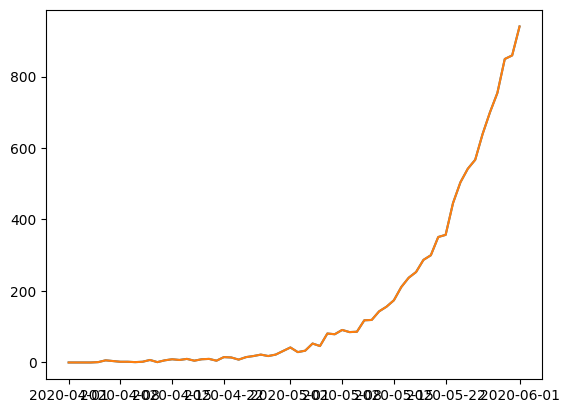

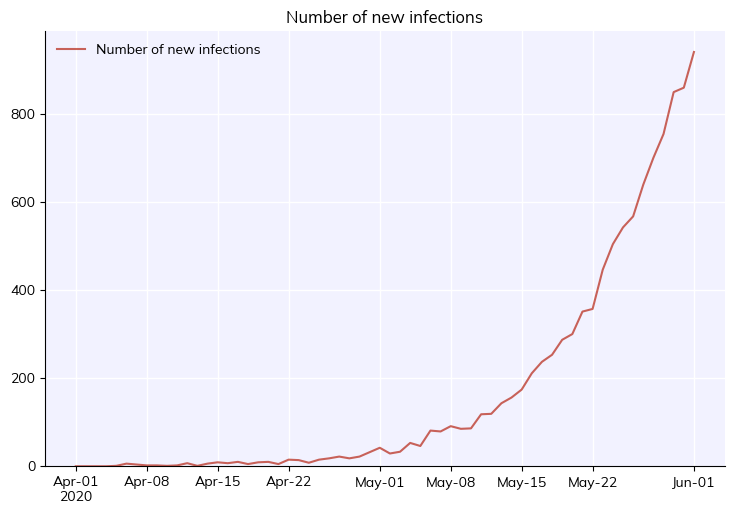

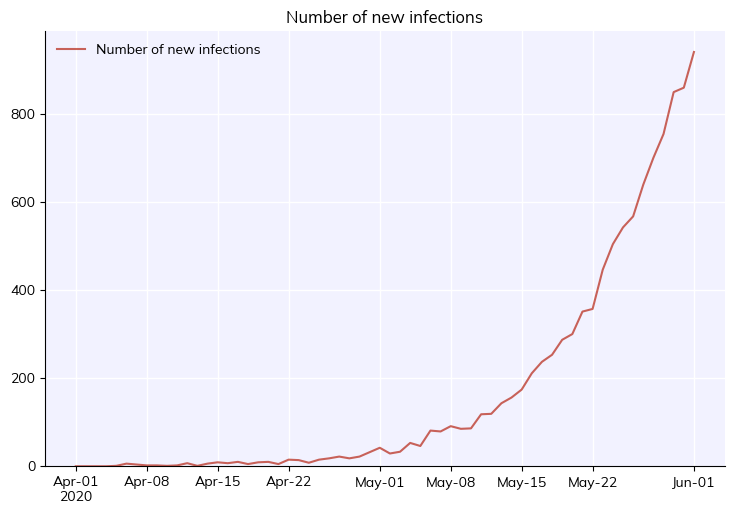

In [17]:
sim.plot_result('new_infections') ##### single result

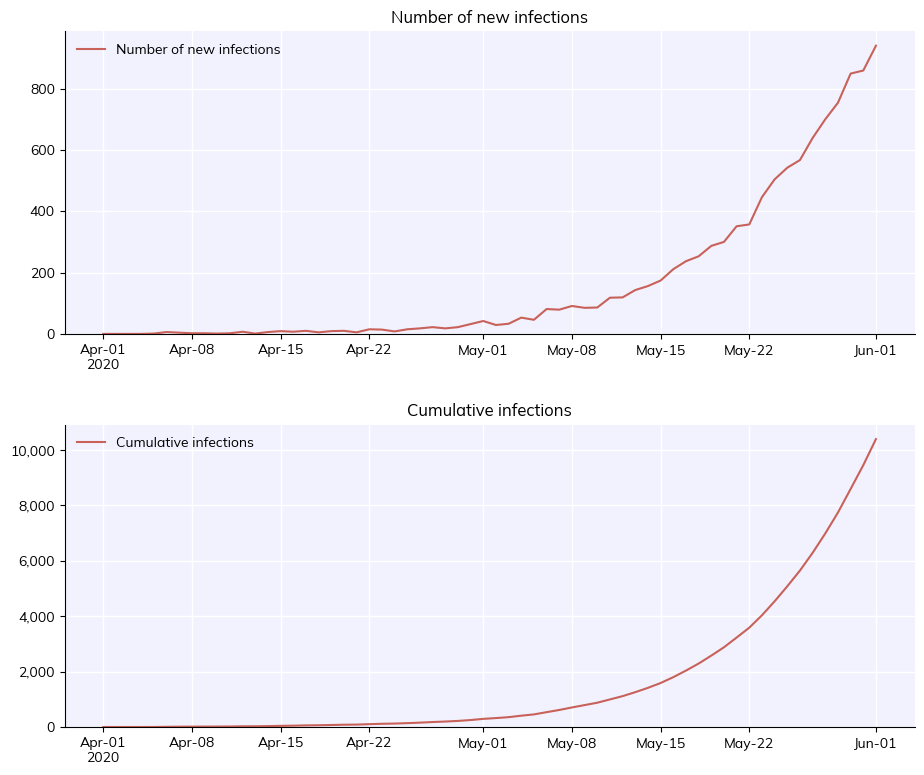

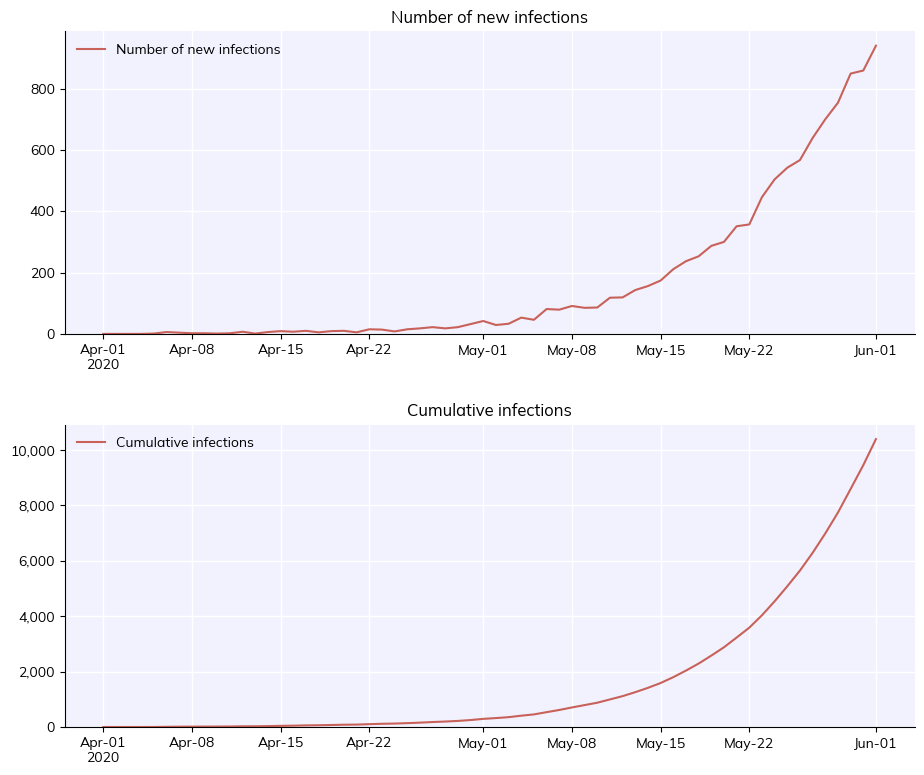

In [18]:
###### You can also select one or more quantities to plot with the first (to_plot) argument
sim.plot(to_plot=['new_infections', 'cum_infections'])

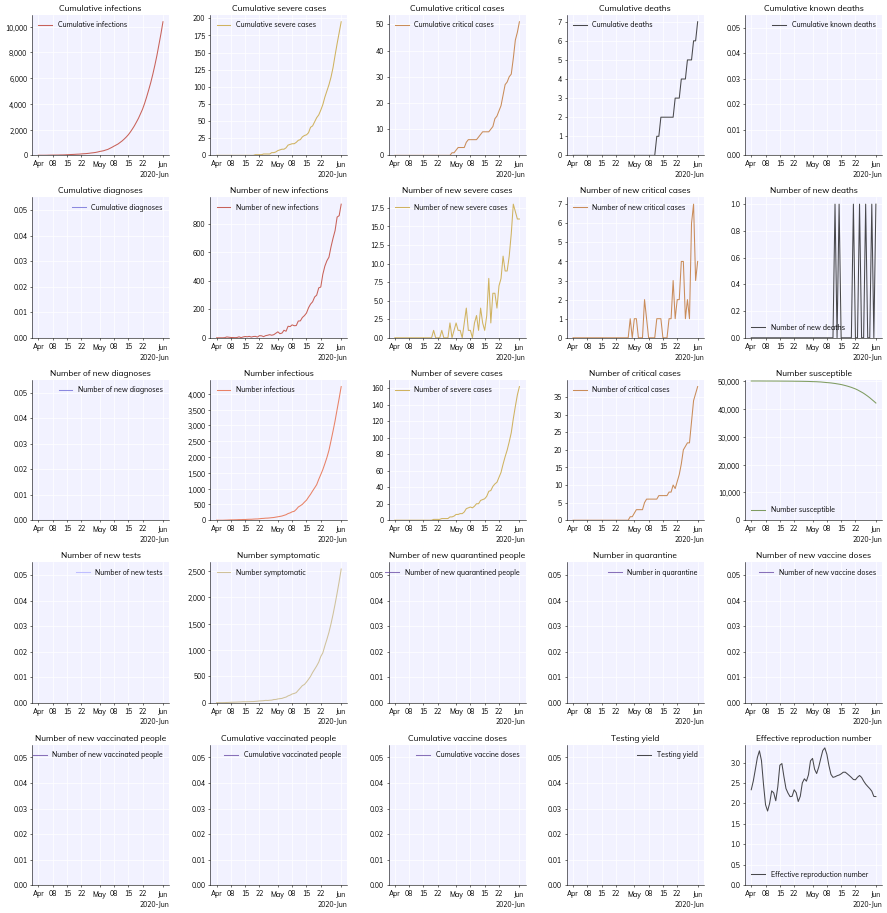

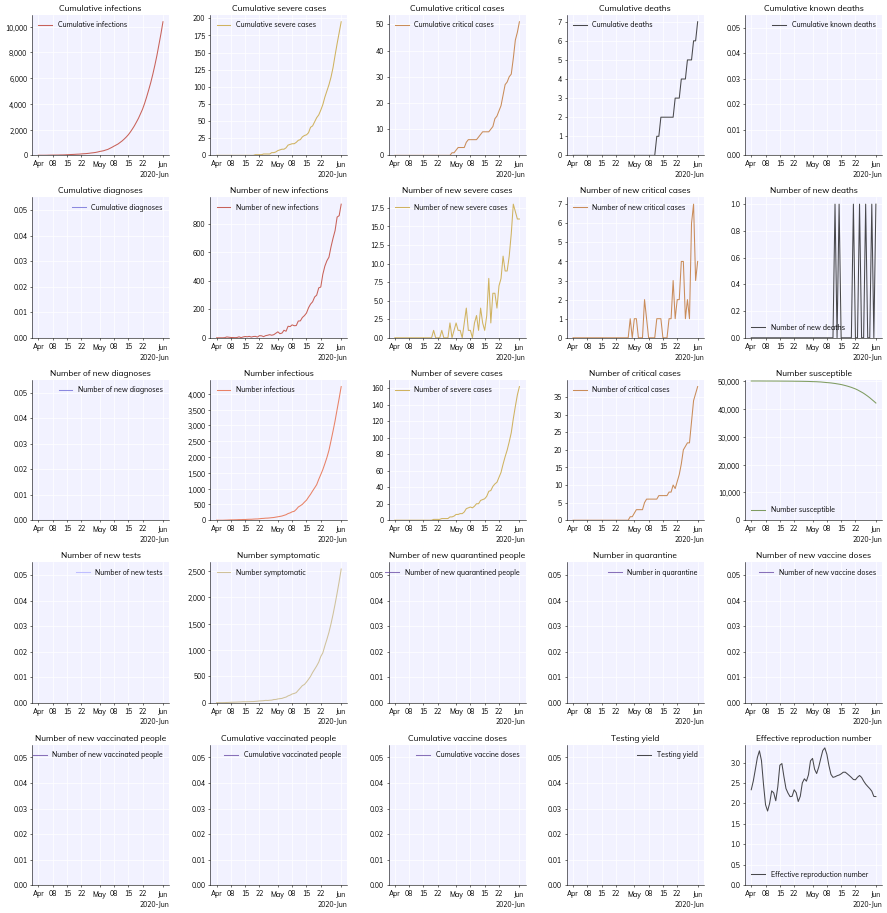

In [19]:
sim.plot('overview', n_cols=5, figsize=(20,20), dateformat='concise', dpi=50) # NB: dateformat='concise' is already the default for >2 columns

Initializing sim with 20000 people for 60 daysInitializing sim with 20000 people for 60 daysInitializing sim with 20000 people for 60 days


Initializing sim with 20000 people for 60 daysInitializing sim with 20000 people for 60 days

  Running "Sim 1": 2020-03-01 ( 0/60) (0.07 s)  ———————————————————— 2%

  Running "Sim 2": 2020-03-01 ( 0/60) (0.07 s)  ———————————————————— 2%
  Running "Sim 4": 2020-03-01 ( 0/60) (0.08 s)  ———————————————————— 2%
  Running "Sim 3": 2020-03-01 ( 0/60) (0.08 s)  ———————————————————— 2%
  Running "Sim 1": 2020-03-11 (10/60) (0.10 s)  •••————————————————— 18%

  Running "Sim 2": 2020-03-11 (10/60) (0.10 s)  •••————————————————— 18%
  Running "Sim 3": 2020-03-11 (10/60) (0.11 s)  •••————————————————— 18%
  Running "Sim 4": 2020-03-11 (10/60) (0.11 s)  •••————————————————— 18%
  Running "Sim 0": 2020-03-21 (20/60) (0.12 s)  ••••••—————————————— 34%
  Running "Sim 1": 2020-03-21 (20/60) (0.13 s)  ••••••—————————————— 34%
  Running "Sim 3": 2020-03-21 (20/60)

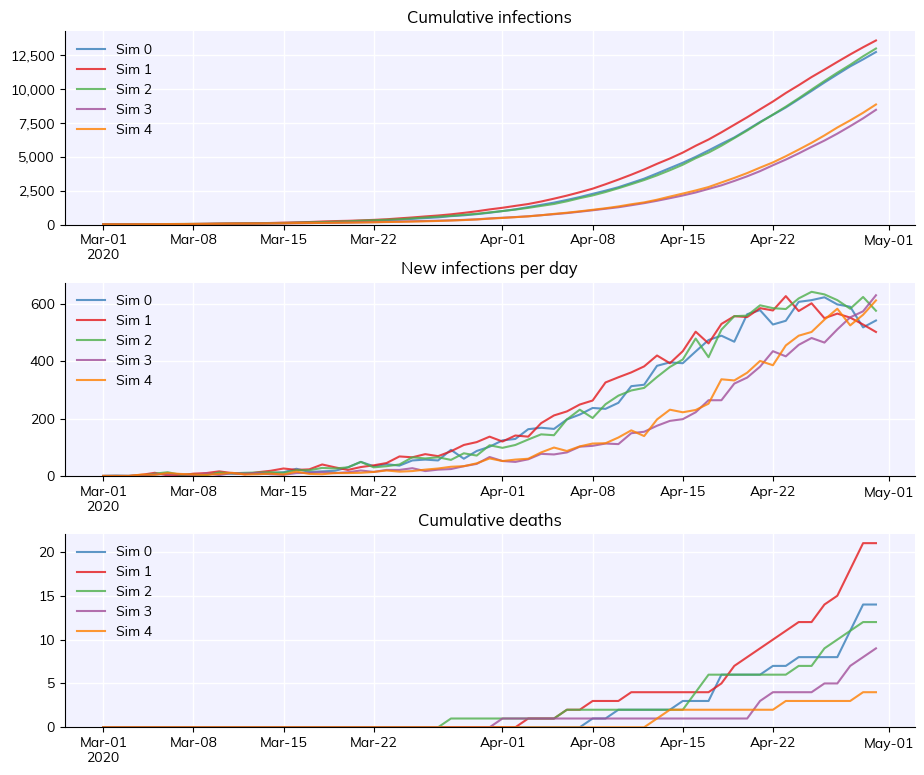

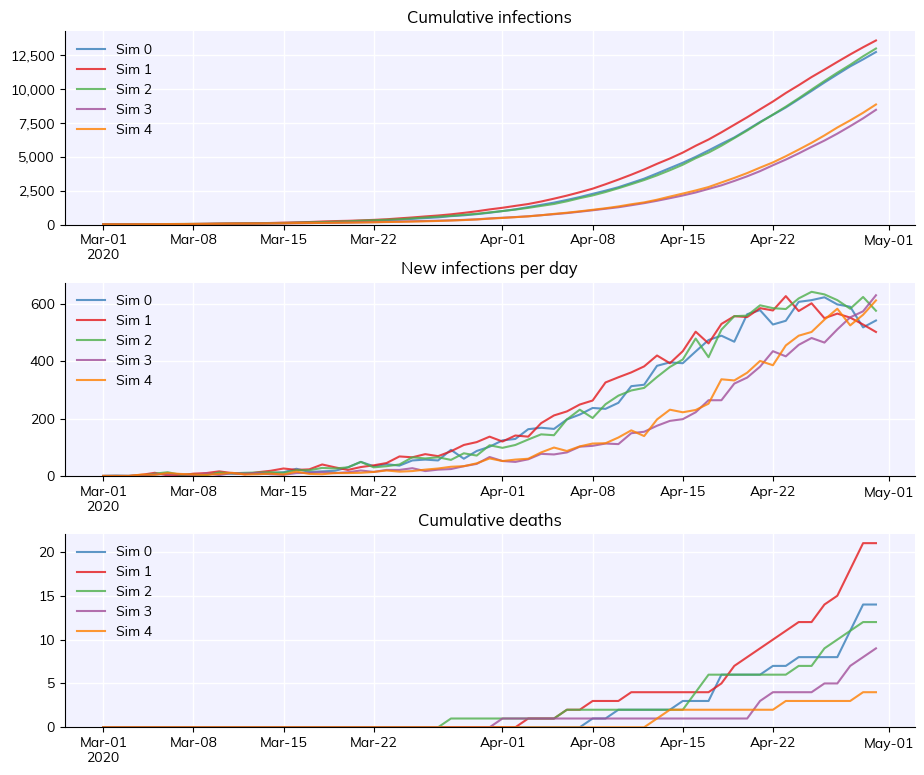

In [20]:
sim = cv.Sim()
msim = cv.MultiSim(sim)
msim.run(n_runs=5)
msim.plot()

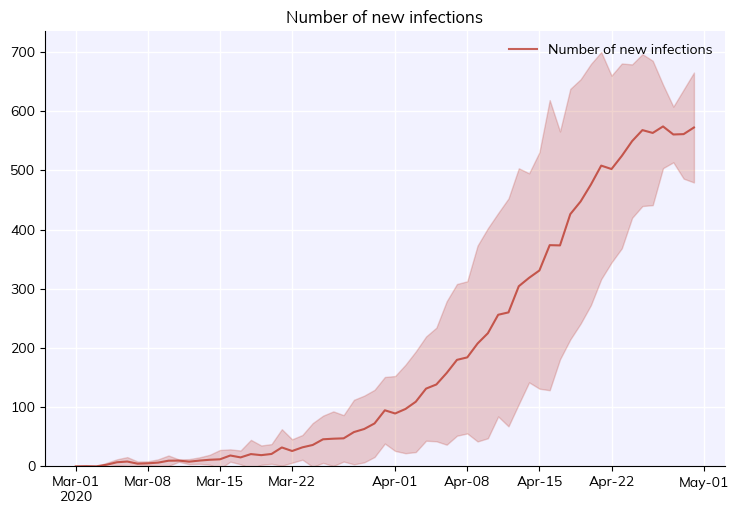

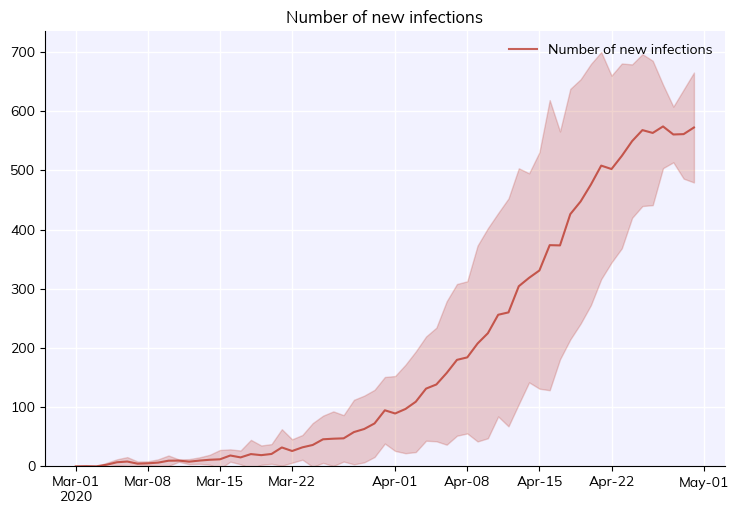

In [21]:
msim.mean()
msim.plot_result('new_infections')

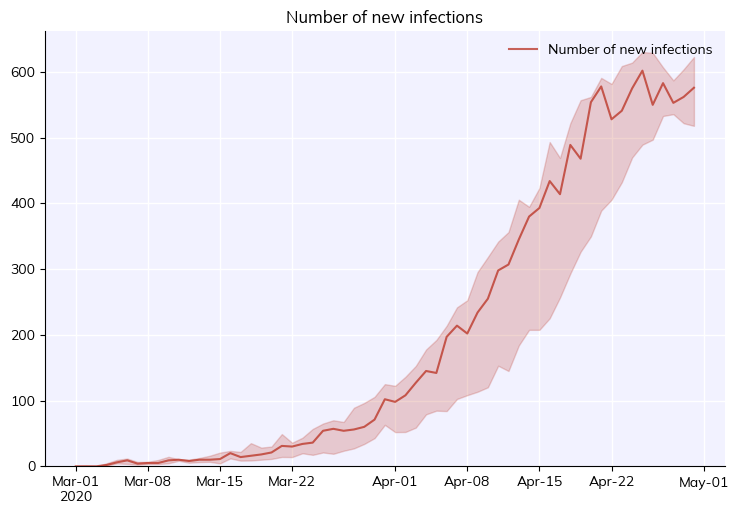

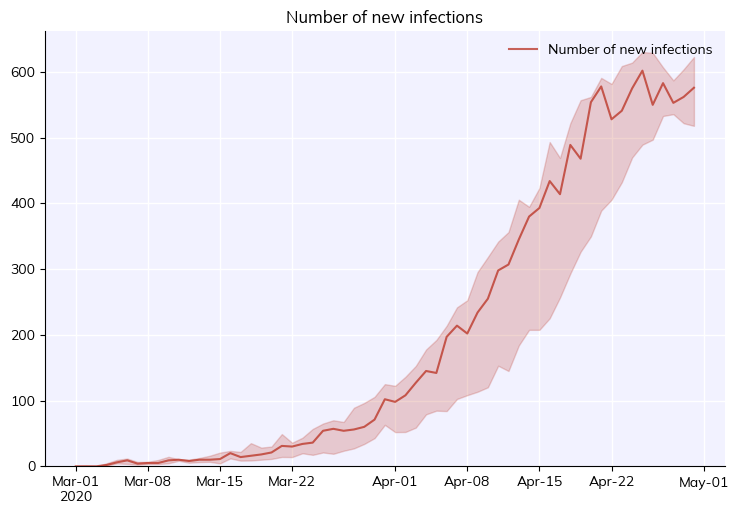

In [22]:
msim.median()
msim.plot_result('new_infections')

Initializing sim with 20000 people for 60 daysInitializing sim with 20000 people for 60 daysInitializing sim with 20000 people for 60 daysInitializing sim with 20000 people for 60 daysInitializing sim with 20000 people for 60 days




  Running "Beta = 0.0125": 2020-03-01 ( 0/60) (0.11 s)  ———————————————————— 2%

  Running "Beta = 0.0175": 2020-03-01 ( 0/60) (0.11 s)  ———————————————————— 2%
  Running "Beta = 0.015": 2020-03-01 ( 0/60) (0.11 s)  ———————————————————— 2%
  Running "Beta = 0.02": 2020-03-01 ( 0/60) (0.11 s)  ———————————————————— 2%
  Running "Beta = 0.01": 2020-03-11 (10/60) (0.13 s)  •••————————————————— 18%
  Running "Beta = 0.0175": 2020-03-11 (10/60) (0.13 s)  •••————————————————— 18%
  Running "Beta = 0.0125": 2020-03-11 (10/60) (0.15 s)  •••————————————————— 18%
  Running "Beta = 0.015": 2020-03-11 (10/60) (0.15 s)  •••————————————————— 18%
  Running "Beta = 0.02": 2020-03-11 (10/60) (0.15 s)  •••————————————————— 18%
  Running "Beta = 0.01": 2020-03-21 (20/60) (0.

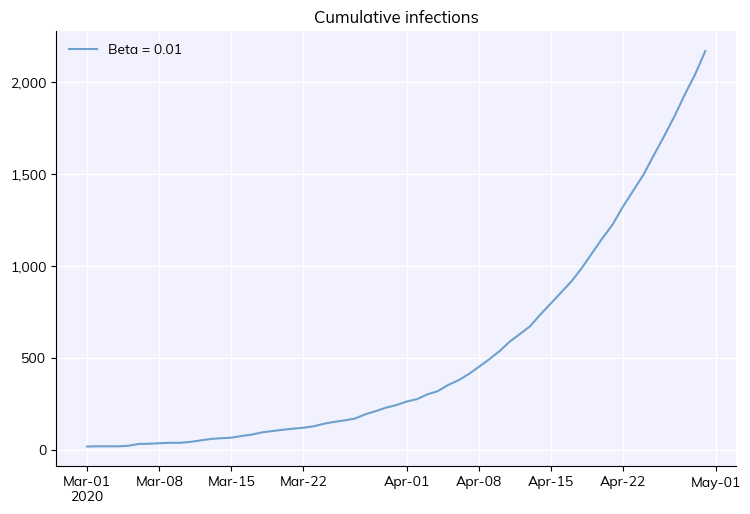

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

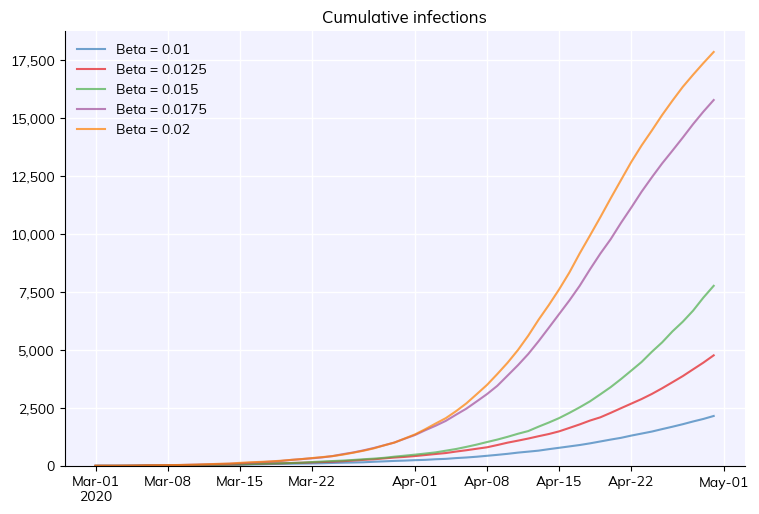

In [23]:
import numpy as np

betas = np.linspace(0.010, 0.020, 5) # Sweep beta from 0.01 to 0.02 with 5 values
sims = []
for beta in betas:
    sim = cv.Sim(beta=beta, label=f'Beta = {beta}')
    sims.append(sim)
msim = cv.MultiSim(sims)
msim.run()
msim.plot_result('cum_infections')

Initializing sim with 20000 people for 120 days
Initializing sim with 20000 people for 120 days
  Running "Default": 2021-03-01 ( 0/120) (0.07 s)  ———————————————————— 1%
  Running "Protect the elderly": 2021-03-01 ( 0/120) (0.07 s)  ———————————————————— 1%
  Running "Default": 2021-03-11 (10/120) (0.09 s)  •——————————————————— 9%
  Running "Protect the elderly": 2021-03-11 (10/120) (0.09 s)  •——————————————————— 9%
  Running "Default": 2021-03-21 (20/120) (0.13 s)  •••————————————————— 17%
  Running "Protect the elderly": 2021-03-21 (20/120) (0.13 s)  •••————————————————— 17%
  Running "Default": 2021-03-31 (30/120) (0.16 s)  •••••——————————————— 26%
  Running "Protect the elderly": 2021-03-31 (30/120) (0.16 s)  •••••——————————————— 26%
  Running "Default": 2021-04-10 (40/120) (0.19 s)  ••••••—————————————— 34%
  Running "Protect the elderly": 2021-04-10 (40/120) (0.19 s)  ••••••—————————————— 34%
  Running "Default": 2021-04-20 (50/120) (0.22 s)  ••••••••———————————— 42%
  Running "P

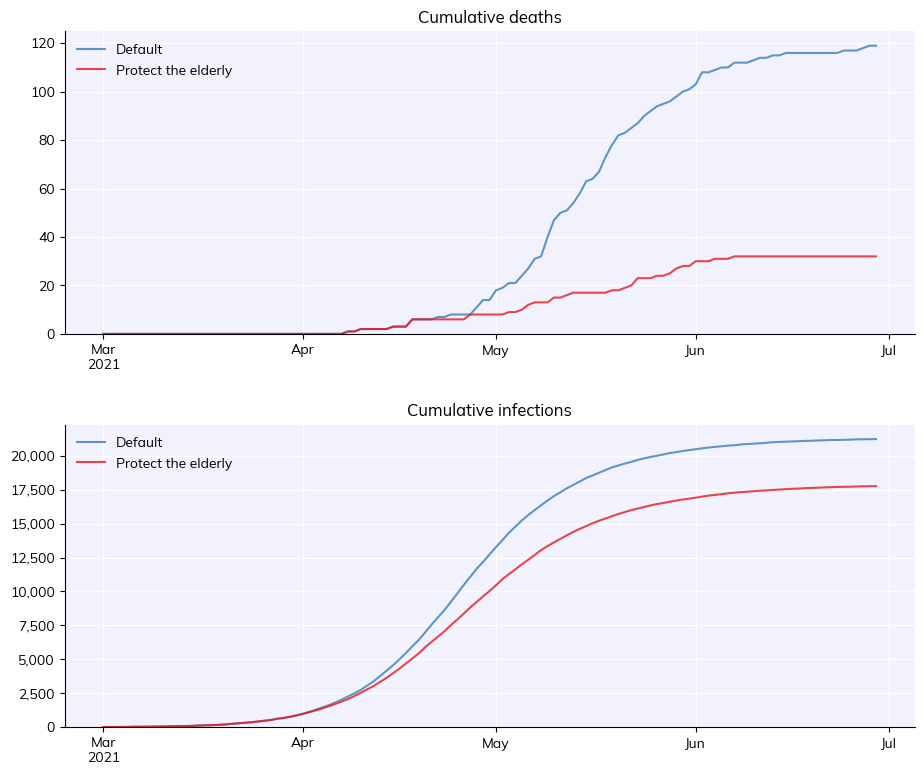

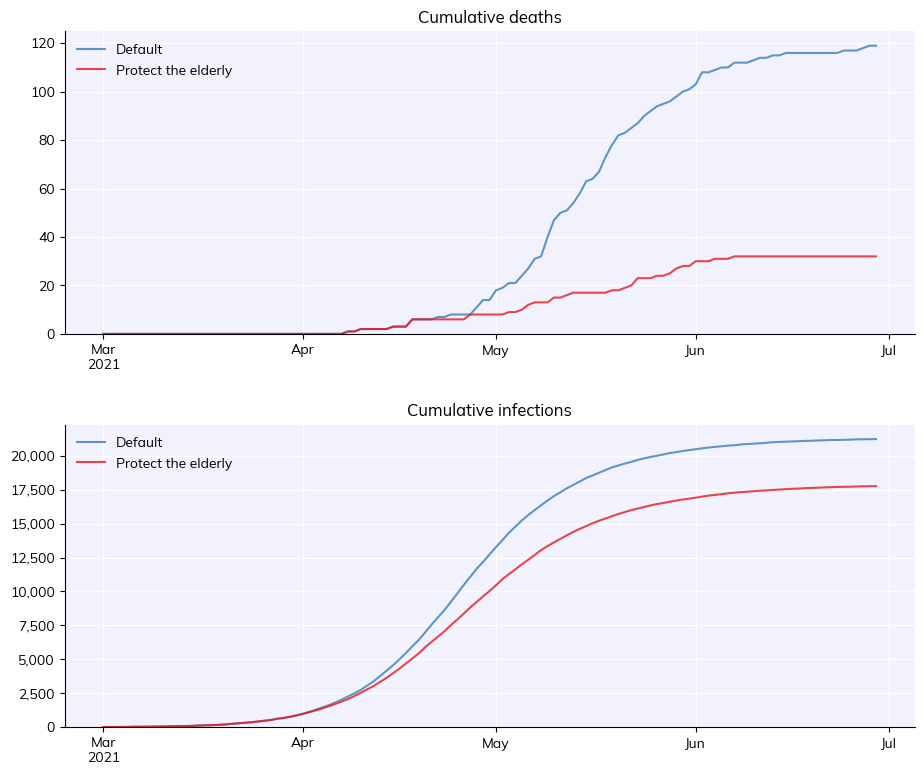

In [24]:
##### note that you can use multisims to do very compact scenario explorations – 
##### here we are using the command cv.parallel(), which is an alias for cv.MultiSim().run():
def protect_elderly(sim):
    if sim.t == sim.day('2021-04-01'):
        elderly = sim.people.age>70
        sim.people.rel_sus[elderly] = 0.0

pars = {'start_day':'2021-03-01', 'n_days':120}
s1 = cv.Sim(pars, label='Default')
s2 = cv.Sim(pars, label='Protect the elderly', interventions=protect_elderly)
cv.parallel(s1, s2).plot(['cum_deaths', 'cum_infections'])

Initializing sim with 10000 people for 60 daysInitializing sim with 10000 people for 60 daysInitializing sim with 10000 people for 60 days


  Running "Beta = 0.012": 2020-03-01 ( 0/60) (0.06 s)  ———————————————————— 2%


  Running "Beta = 0.012": 2020-03-11 (10/60) (0.08 s)  •••————————————————— 18%


  Running "Beta = 0.012": 2020-03-21 (20/60) (0.09 s)  ••••••—————————————— 34%

  Running "Beta = 0.012": 2020-03-21 (20/60) (0.09 s)  ••••••—————————————— 34%
  Running "Beta = 0.012": 2020-03-31 (30/60) (0.13 s)  ••••••••••—————————— 51%
  Running "Beta = 0.012": 2020-03-31 (30/60) (0.13 s)  ••••••••••—————————— 51%
  Running "Beta = 0.012": 2020-03-31 (30/60) (0.14 s)  ••••••••••—————————— 51%
  Running "Beta = 0.012": 2020-04-10 (40/60) (0.15 s)  •••••••••••••——————— 67%
  Running "Beta = 0.012": 2020-04-10 (40/60) (0.15 s)  •••••••••••••——————— 67%
  Running "Beta = 0.012": 2020-04-10 (40/60) (0.16 s)  •••••••••••••——————— 67%
  Running "Beta = 0.012": 2020-04-20 (50/60) (0.17 s)  

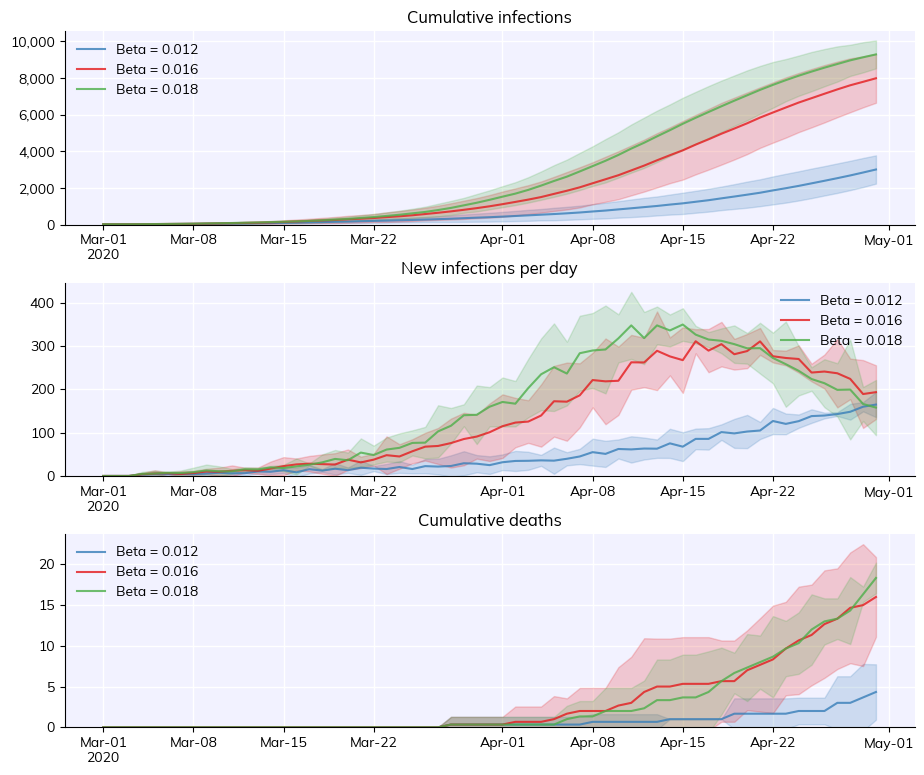

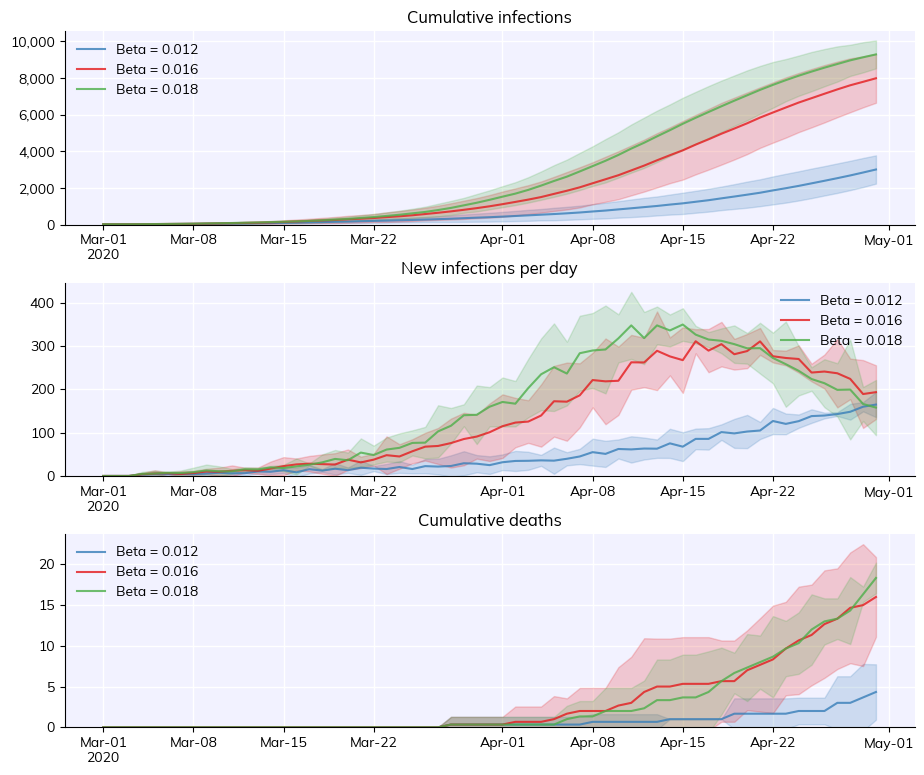

In [25]:
##### you can also merge or split different multisims together. Here’s an example 
##### that’s similar to before, except it shows how to run a multisim of different 
##### seeds for the same beta value, but then merge multisims for different beta values 
##### together into one multisim to rule them all:
n_sims = 3
betas = [0.012, 0.016, 0.018]

msims = []
for beta in betas:
    sims = []
    for s in range(n_sims):
        sim = cv.Sim(pop_size=10e3, beta=beta, rand_seed=s, label=f'Beta = {beta}')
        sims.append(sim)
    msim = cv.MultiSim(sims)
    msim.run()
    msim.mean()
    msims.append(msim)

merged = cv.MultiSim.merge(msims, base=True)
merged.plot(color_by_sim=True)

Initializing sim with 10000 people for 60 days
Initializing sim with 10000 people for 60 days
Initializing sim with 10000 people for 60 days
  Running "Baseline": 2020-03-01 ( 0/60) (0.04 s)  ———————————————————— 2%
  Running "Baseline": 2020-03-01 ( 0/60) (0.04 s)  ———————————————————— 2%
  Running "Baseline": 2020-03-01 ( 0/60) (0.04 s)  ———————————————————— 2%
  Running "Baseline": 2020-03-11 (10/60) (0.05 s)  •••————————————————— 18%
  Running "Baseline": 2020-03-11 (10/60) (0.05 s)  •••————————————————— 18%
  Running "Baseline": 2020-03-11 (10/60) (0.05 s)  •••————————————————— 18%
  Running "Baseline": 2020-03-21 (20/60) (0.06 s)  ••••••—————————————— 34%
  Running "Baseline": 2020-03-21 (20/60) (0.07 s)  ••••••—————————————— 34%
  Running "Baseline": 2020-03-21 (20/60) (0.06 s)  ••••••—————————————— 34%
  Running "Baseline": 2020-03-31 (30/60) (0.08 s)  ••••••••••—————————— 51%
  Running "Baseline": 2020-03-31 (30/60) (0.08 s)  ••••••••••—————————— 51%
  Running "Baseline": 2020

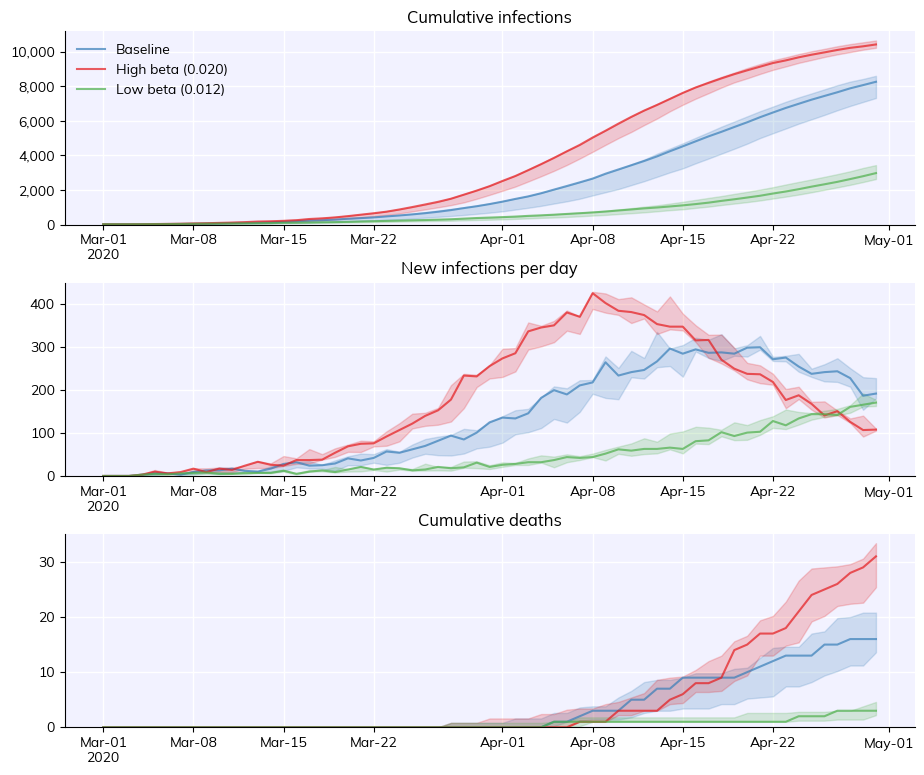

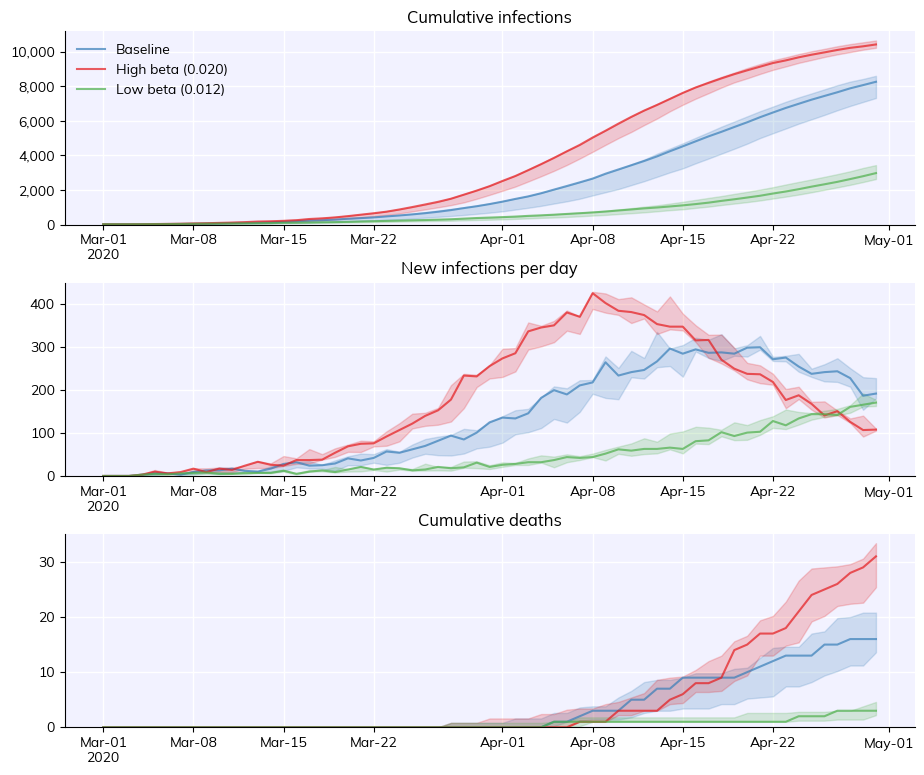

In [26]:
# Running with Scenarios
# Most of the time, you’ll want to run with multisims since they give you the most flexibility. 
# However, in certain cases, Scenario objects let you achieve the same thing more simply. Unlike MultiSims, which are completely 
# agnostic about what sims you include, scenarios always start from the same base sim. They then modify the parameters as you specify, 
# and finally add uncertainty if desired. For example, this shows how you’d use scenarios to run the example similar to the one above.
# Set base parameters -- these will be shared across all scenarios
basepars = {'pop_size':10e3}

# Configure the settings for each scenario
scenarios = {'baseline': {
              'name':'Baseline',
              'pars': {}
              },
            'high_beta': {
              'name':'High beta (0.020)',
              'pars': {
                  'beta': 0.020,
                  }
              },
            'low_beta': {
              'name':'Low beta (0.012)',
              'pars': {
                  'beta': 0.012,
                  }
              },
             }

# Run and plot the scenarios
scens = cv.Scenarios(basepars=basepars, scenarios=scenarios)
scens.run()
scens.plot()

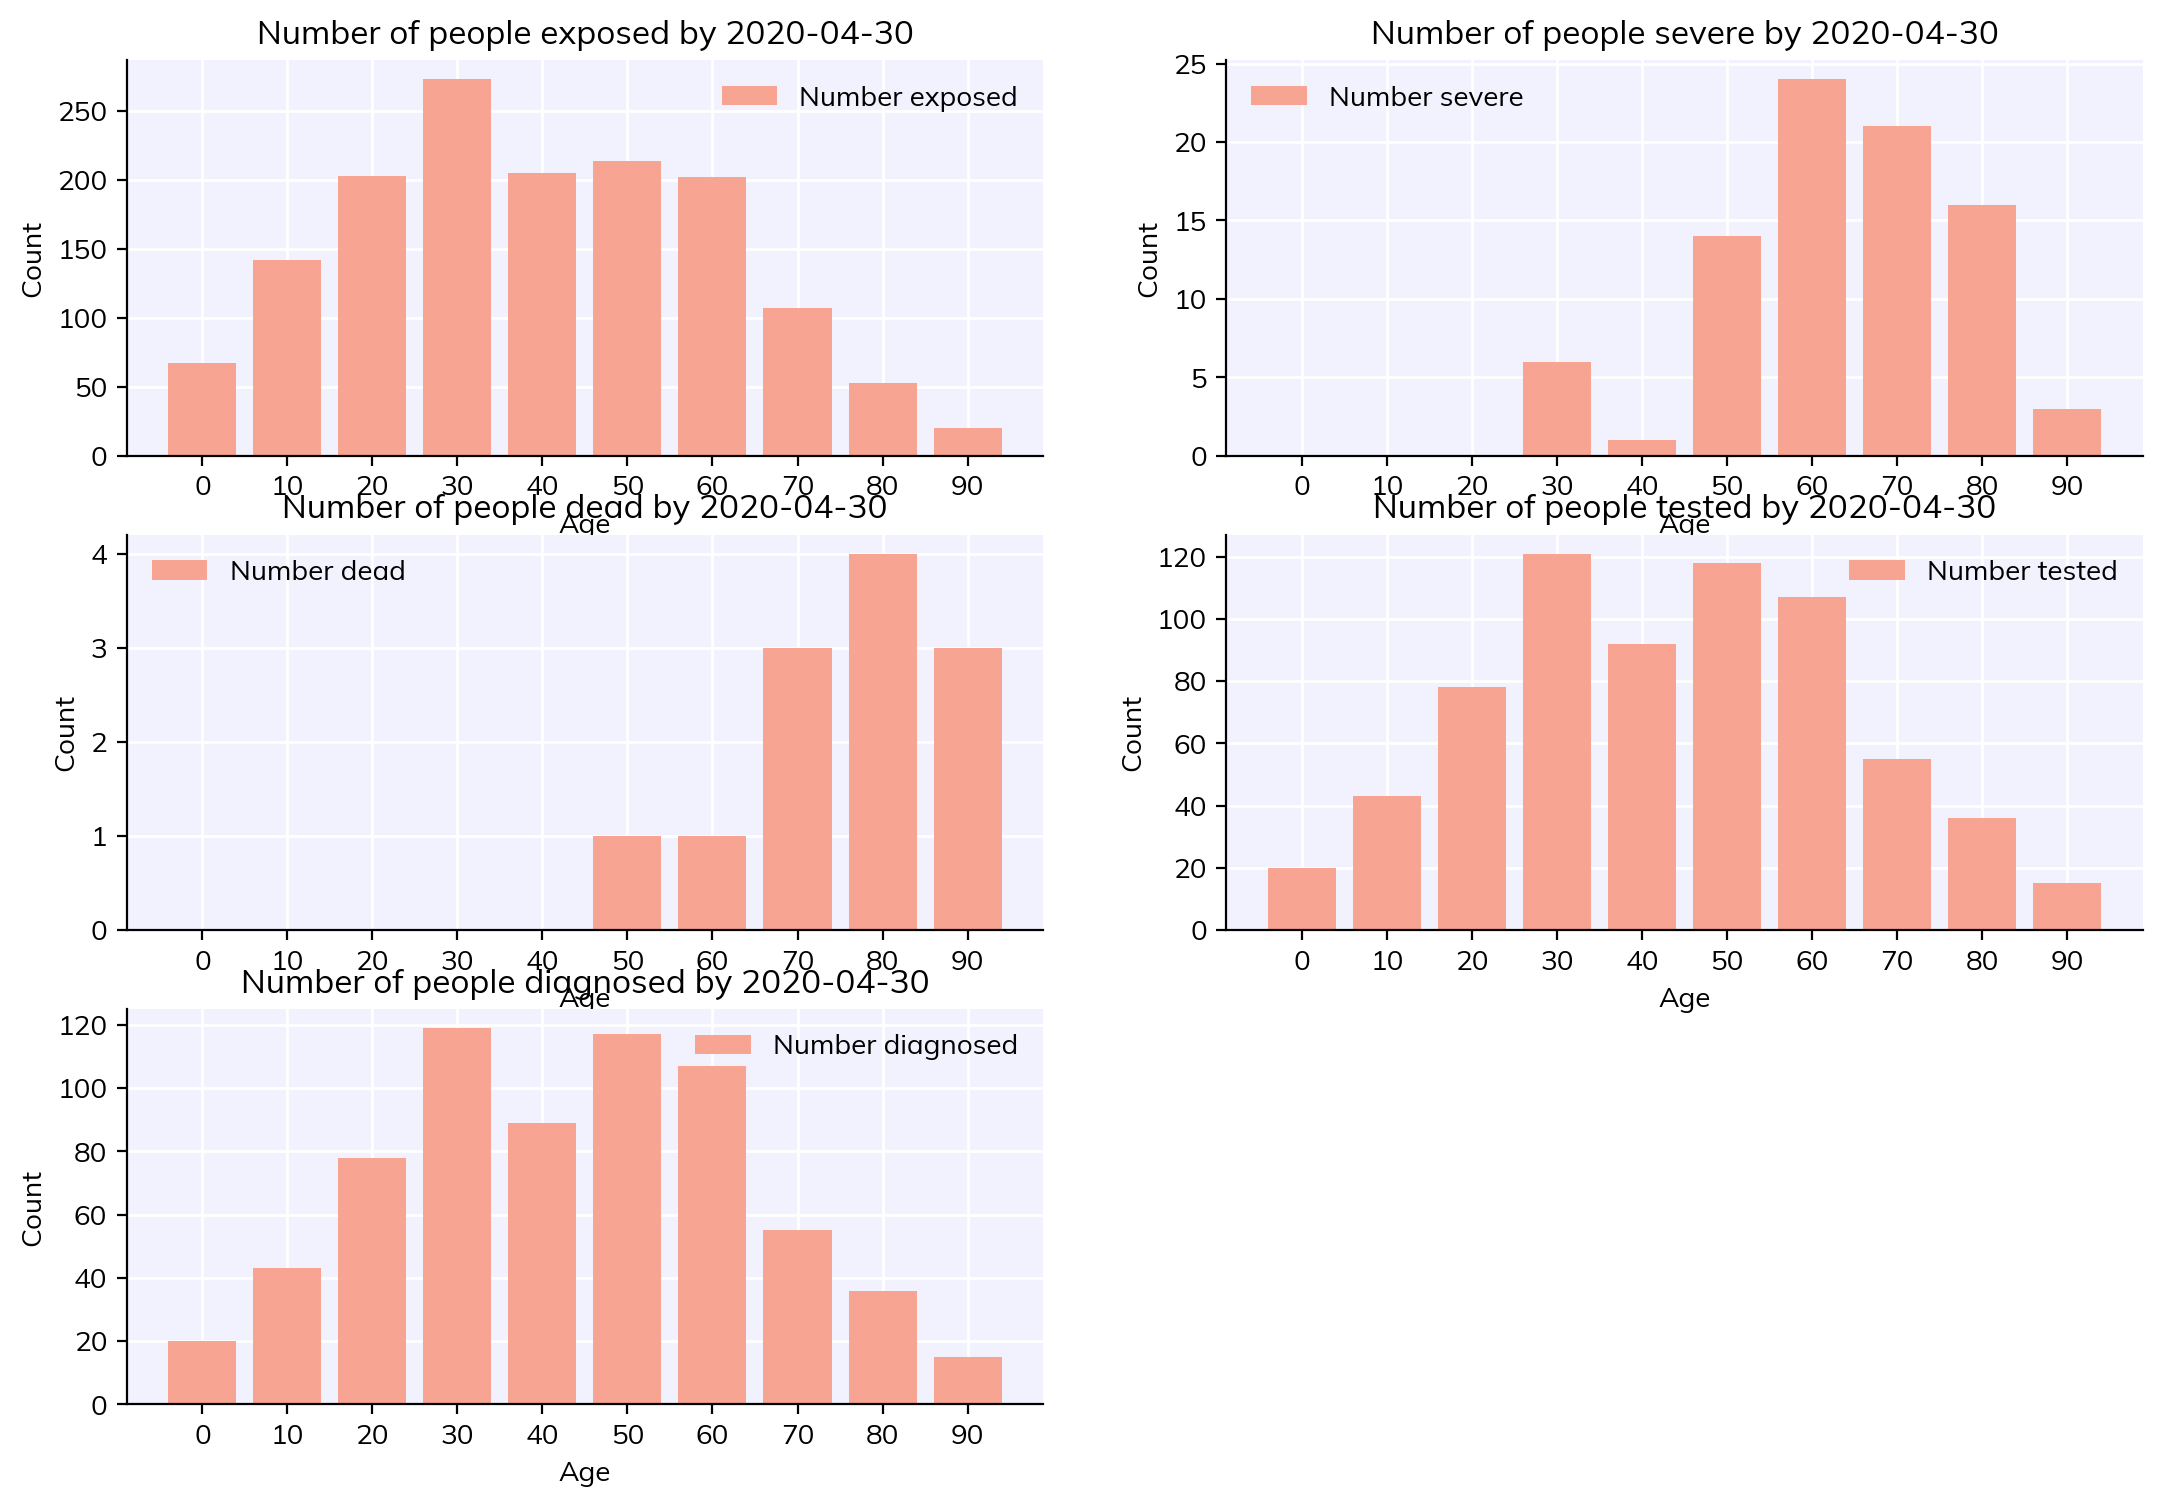

In [27]:
import covasim as cv
cv.options(jupyter=True, verbose=0)

sim = cv.Sim(interventions=cv.test_prob(0.5), analyzers=cv.age_histogram())
sim.run()
agehist = sim.get_analyzer() # Only one analyzer so we can retrieve it like this
agehist.plot()

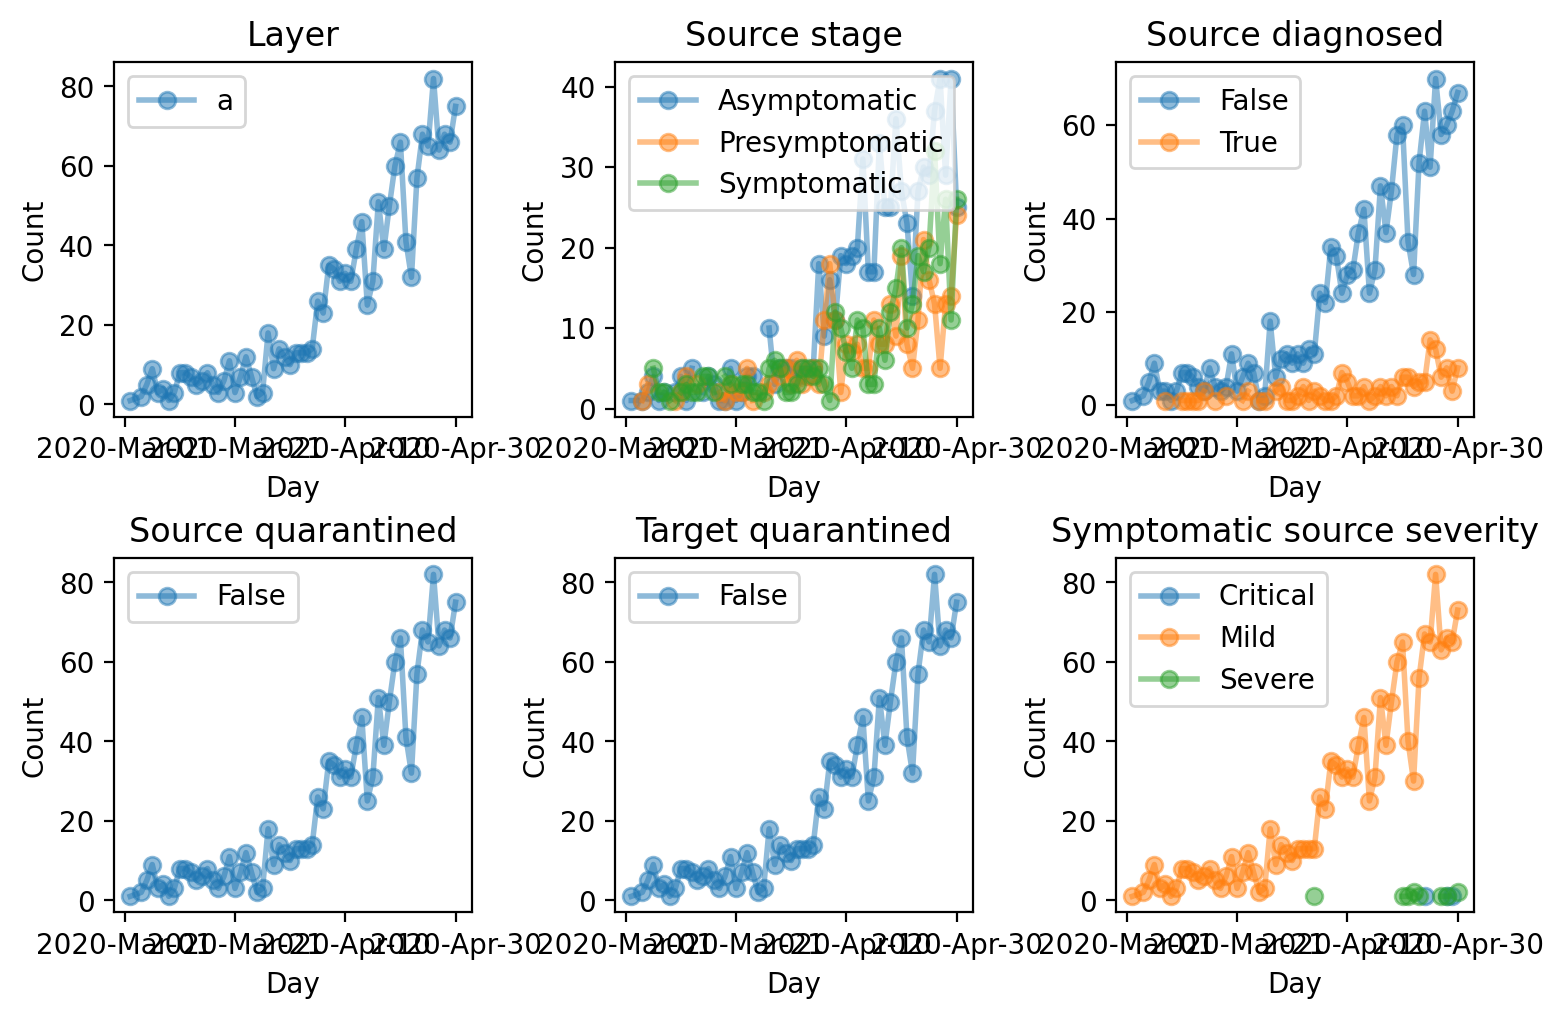

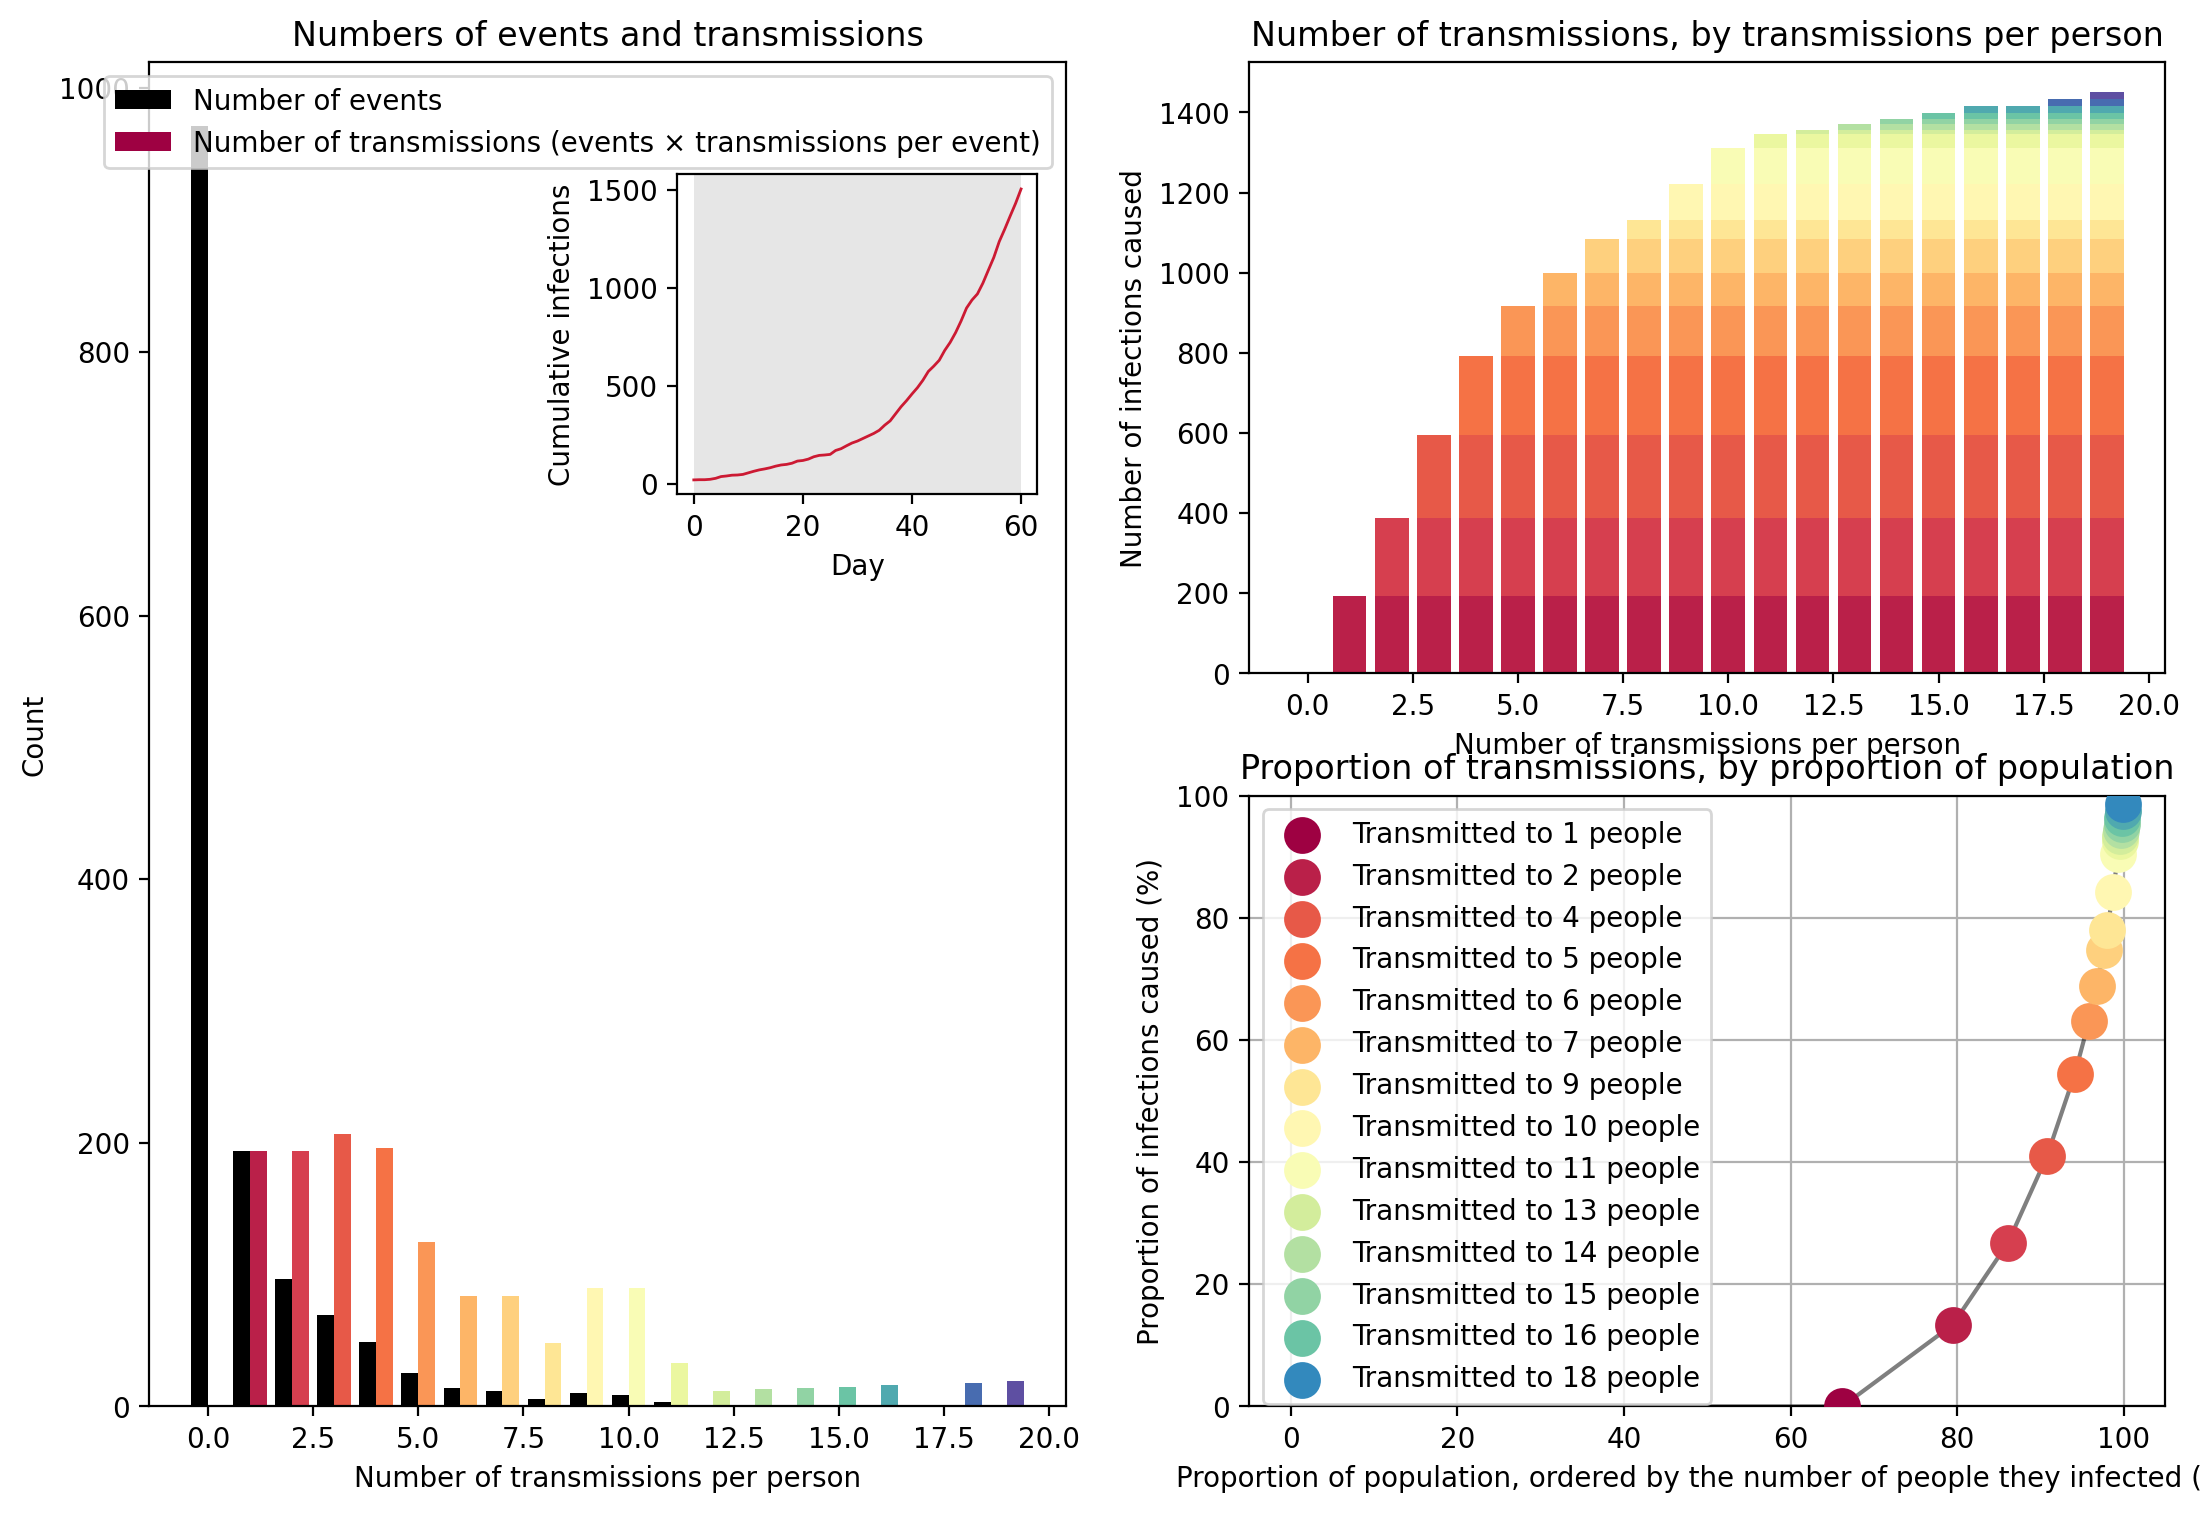

In [28]:
tt = sim.make_transtree()
fig1 = tt.plot()
fig2 = tt.plot_histograms()

In [36]:
dir(tt)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'animate',
 'apply',
 'count_targets',
 'count_transmissions',
 'day',
 'detailed',
 'df',
 'finalize',
 'finalized',
 'infection_log',
 'initialize',
 'initialized',
 'label',
 'make_detailed',
 'n_days',
 'n_targets',
 'plot',
 'plot_histograms',
 'pop_size',
 'r0',
 'shrink',
 'sim_results',
 'sim_start',
 'source_dates',
 'source_inds',
 'sources',
 'target_dates',
 'target_inds',
 'targets',
 'to_json',
 'transmissions']

In [32]:
import pylab as pl
import sciris as sc
import covasim as cv

class store_seir(cv.Analyzer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) # This is necessary to initialize the class properly
        self.t = []
        self.S = []
        self.E = []
        self.I = []
        self.R = []
        return

    def apply(self, sim):
        ppl = sim.people # Shorthand
        self.t.append(sim.t)
        self.S.append(ppl.susceptible.sum())
        self.E.append(ppl.exposed.sum() - ppl.infectious.sum())
        self.I.append(ppl.infectious.sum())
        self.R.append(ppl.recovered.sum() + ppl.dead.sum())
        return

    def plot(self):
        pl.figure()
        pl.plot(self.t, self.S, label='S')
        pl.plot(self.t, self.E, label='E')
        pl.plot(self.t, self.I, label='I')
        pl.plot(self.t, self.R, label='R')
        pl.legend()
        pl.xlabel('Day')
        pl.ylabel('People')
        sc.setylim() # Reset y-axis to start at 0
        sc.commaticks() # Use commas in the y-axis labels
        return

sim = cv.Sim(n_days=180, analyzers=store_seir(label='seir'))
sim.run()
seir = sim.get_analyzer('seir') # Retrieve by label
seir.plot()

In [33]:
def check_88(sim):
    people_who_are_88 = sim.people.age.round() == 88 # Find everyone who's aged 88 (to the nearest year)
    people_exposed = sim.people.exposed # Find everyone who's infected with COVID
    people_who_are_88_with_covid = cv.true(people_who_are_88 * people_exposed) # Multiplication is the same as logical "and"
    n = len(people_who_are_88_with_covid) # Count how many people there are
    if n:
        print(f'Oh no! {n} people aged 88 have covid on timestep {sim.t} {"🤯"*n}')
    return

sim = cv.Sim(n_days=120, analyzers=check_88, verbose=0)
sim.run()

Oh no! 2 people aged 88 have covid on timestep 20 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 21 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 22 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 23 🤯🤯
Oh no! 3 people aged 88 have covid on timestep 24 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 25 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 26 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 27 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 28 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 29 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 30 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 31 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 32 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 33 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 34 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 35 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 36 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 37 🤯🤯🤯
Oh no! 4 people aged 88 have cov

Sim(<no label>; 2020-03-01 to 2020-06-29; pop: 20000 random; epi: 21222⚙, 119☠)

In [31]:
fig3 = tt.make_detailed()

TypeError: make_detailed() missing 1 required positional argument: 'people'

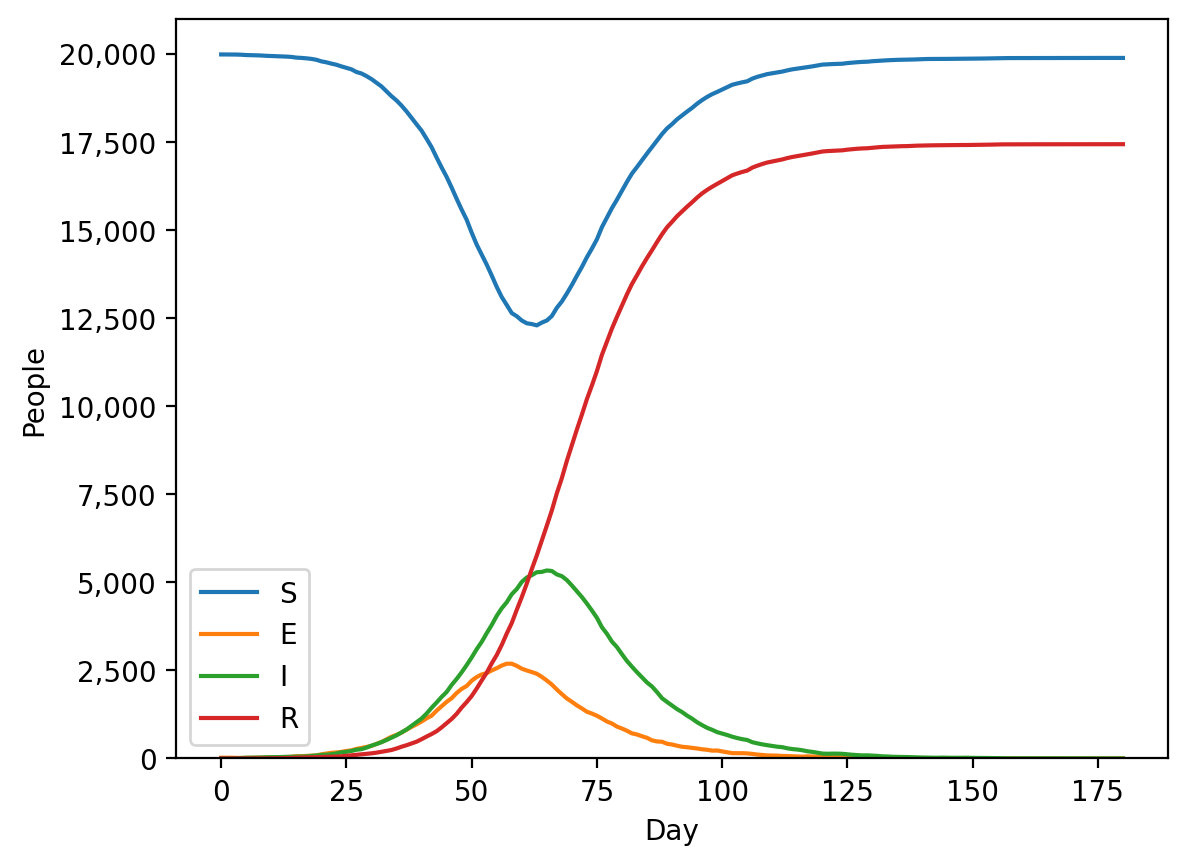

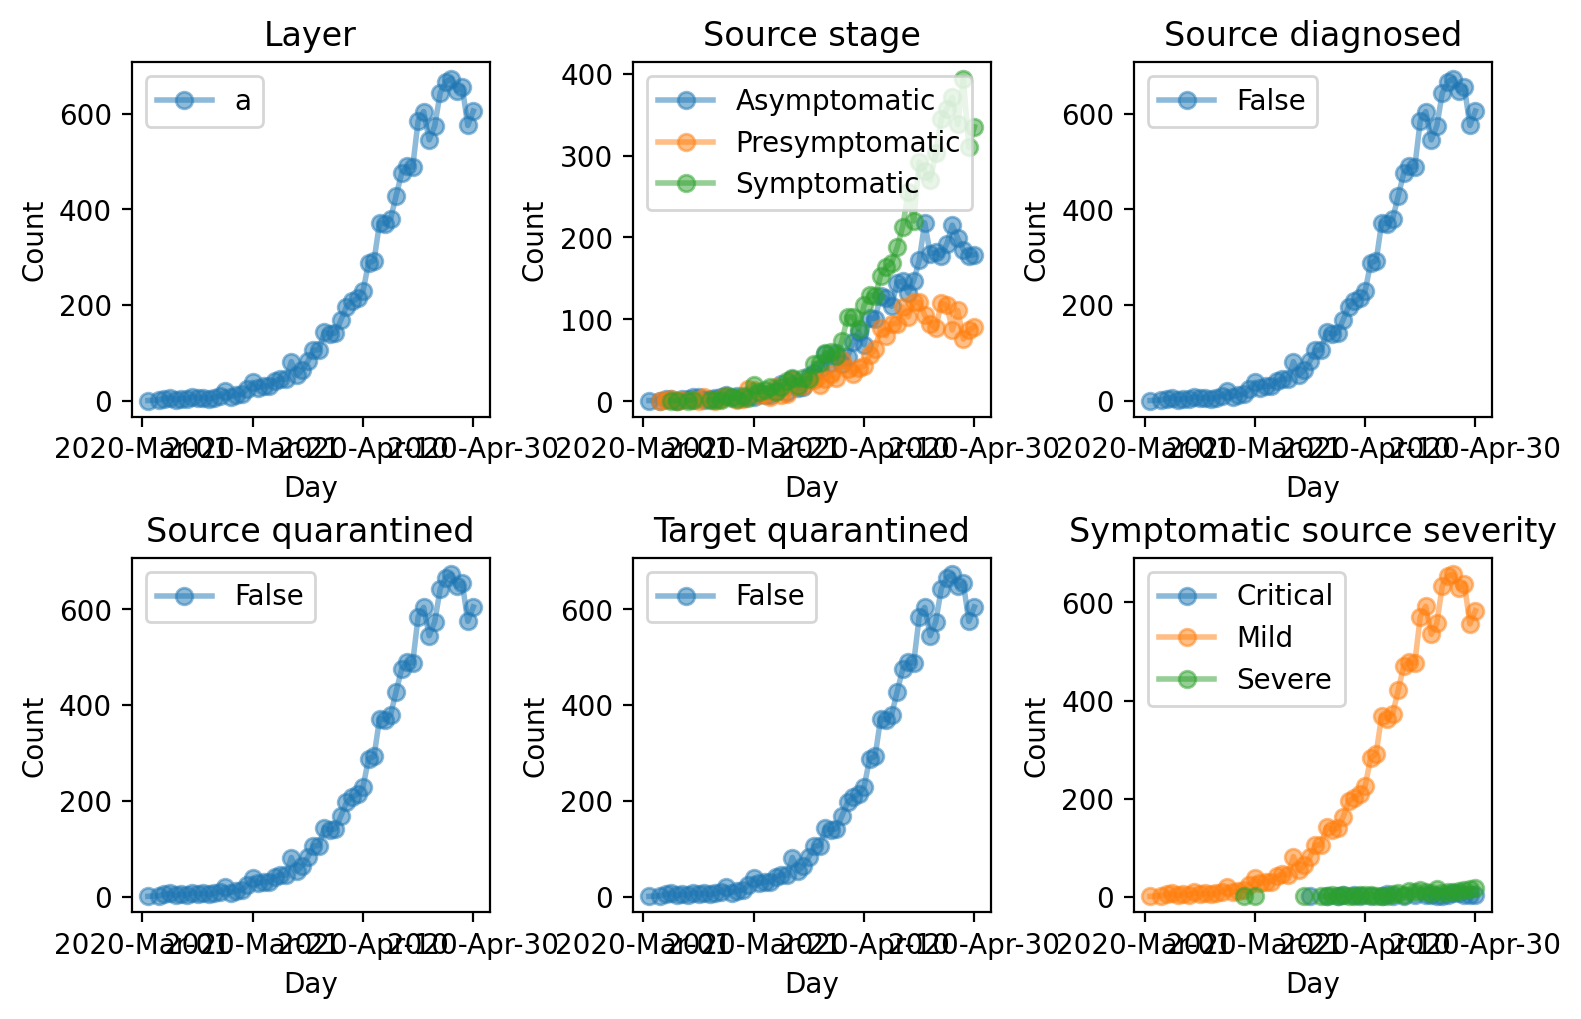

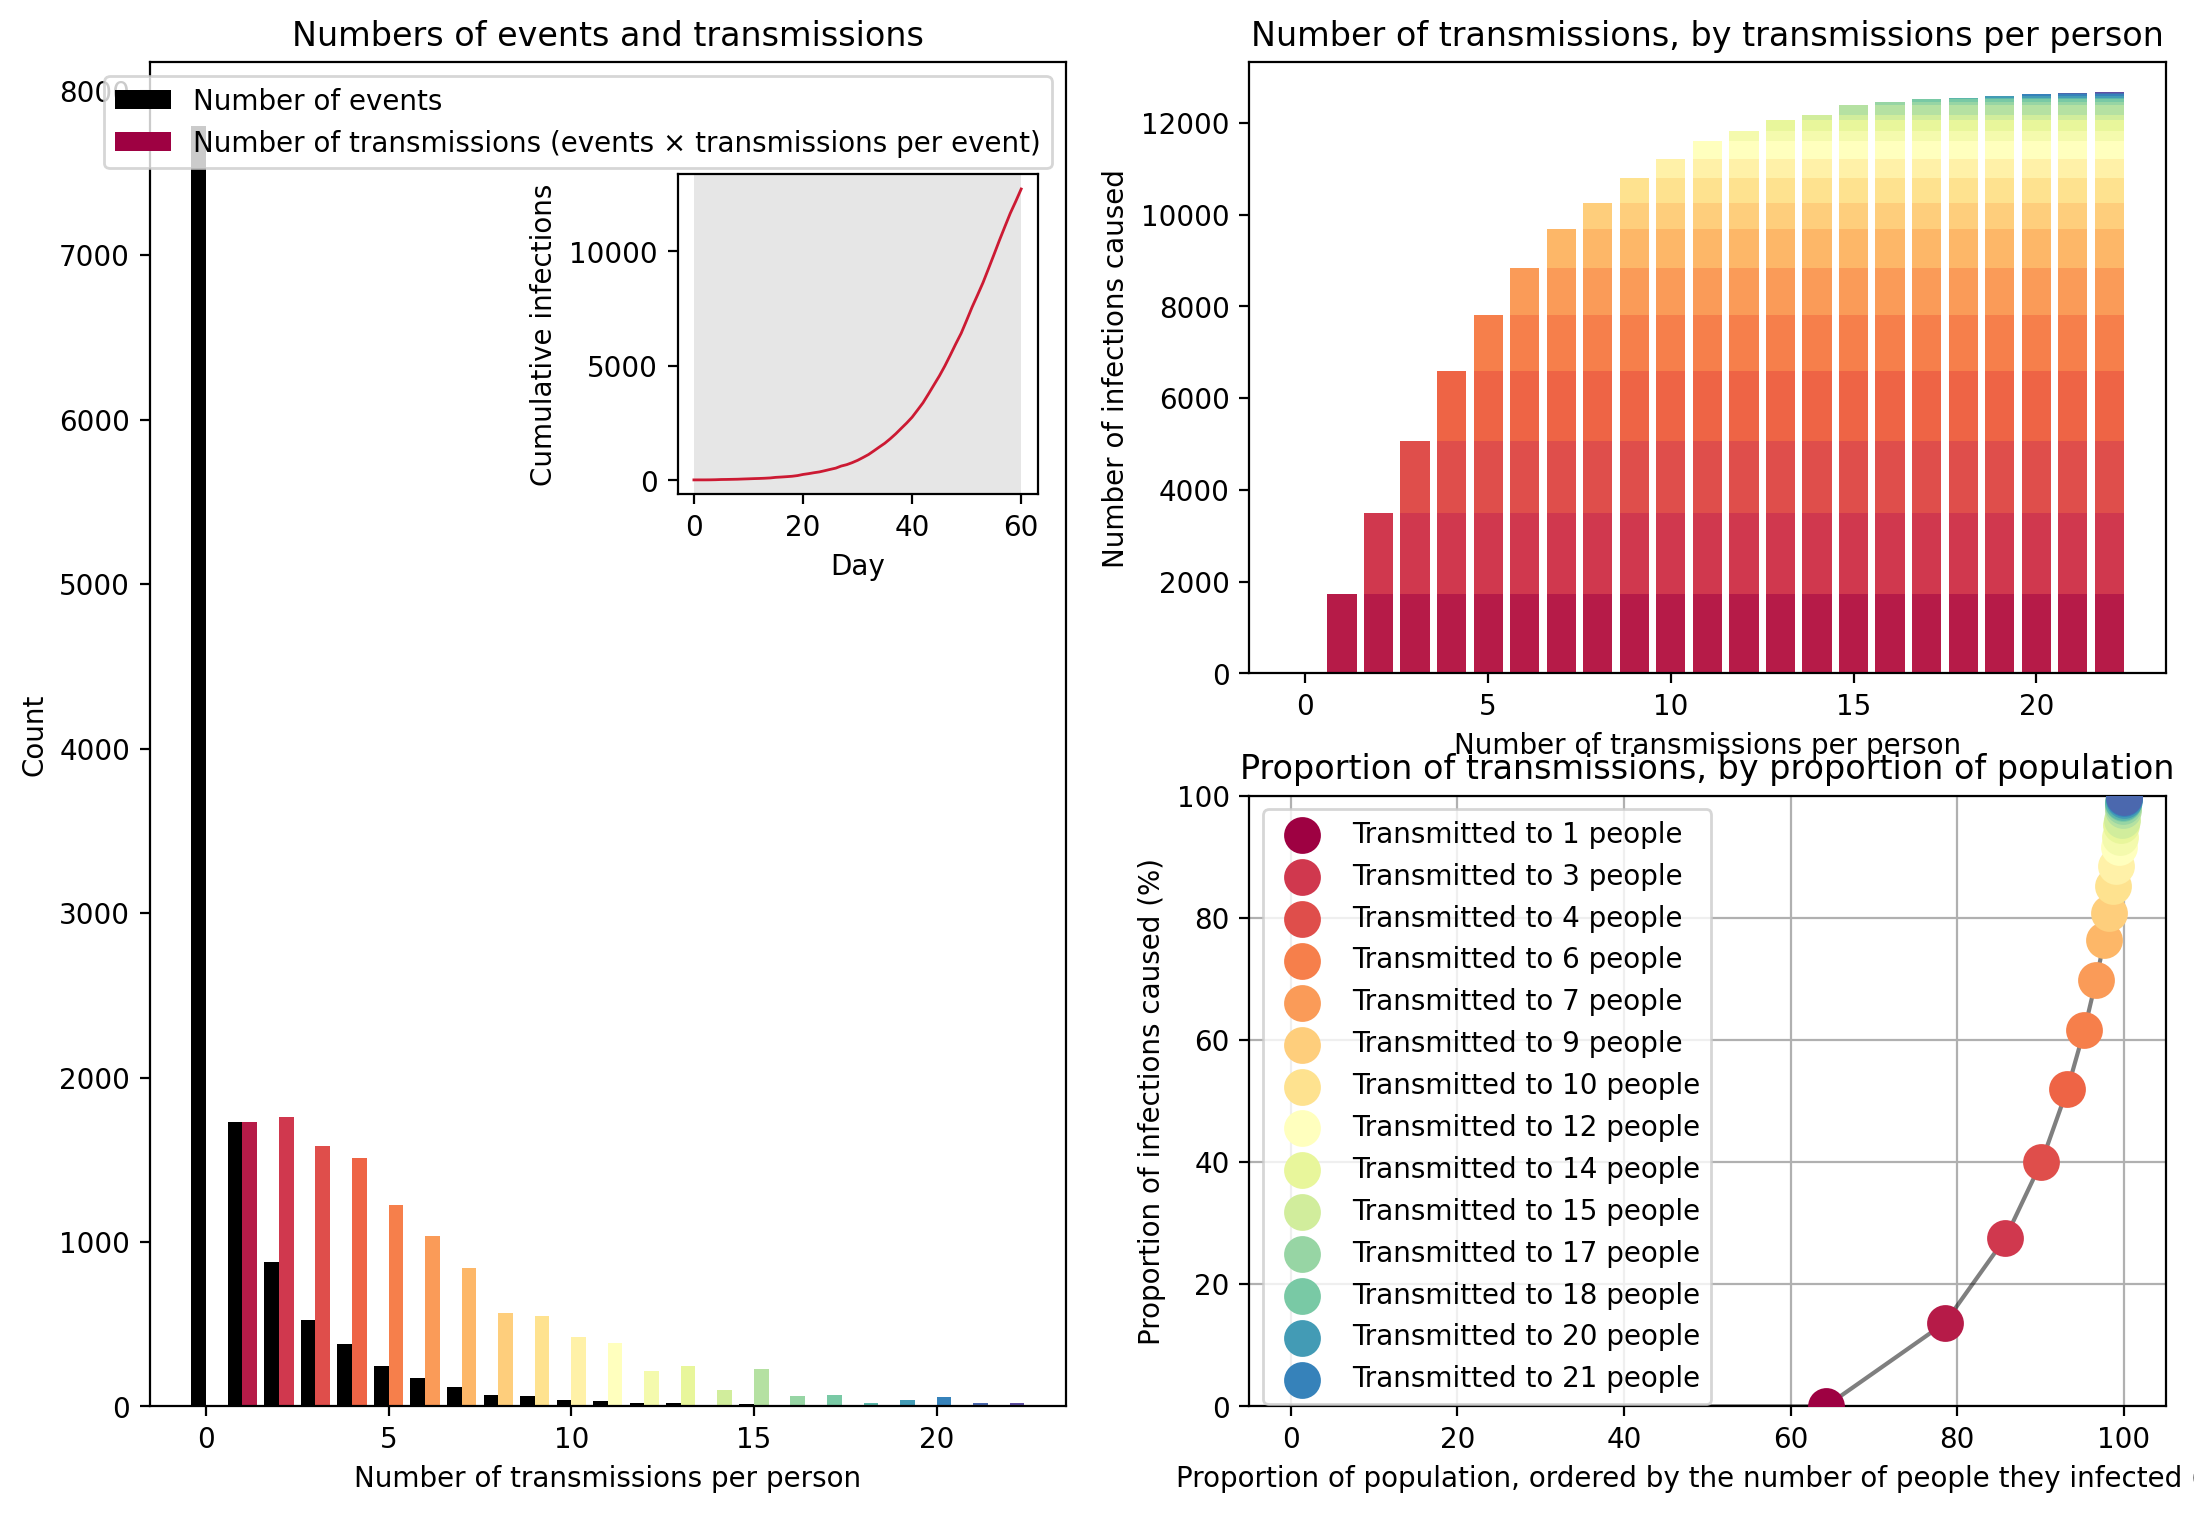

In [35]:
# sim = cv.Sim().run()
# sim.run()
tt = sim.make_transtree()
tt.plot()
tt.plot_histograms()

In [19]:
import csv

with open("test_C.csv") as f: #####, newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
data = data[1:]
for i in data:
    i[2] = int(i[2])
print(data)

[['1', '3', 1], ['2', '3', 1]]


In [20]:
#data = [[1, 5], [3, 2], [7, 8], [4, 1]]

# Sort by the last item of each sublist
sorted_data = sorted(data, key=lambda x: x[-1])

print(sorted_data)

[['1', '3', 1], ['2', '3', 1]]


In [21]:
parents = []
for i in sorted_data:
    if i[0] not in parents:
        parents.append(i[0])
    if i[1] in parents:
        i[1] = i[1]+'_'+str(i[-1])
print(sorted_data)

[['1', '3', 1], ['2', '3', 1]]


In [26]:
from collections import defaultdict

# Step 1: Group by the last two items
grouped = defaultdict(list)
for item in sorted_data:
    key = tuple(item[-2:])  # group by last two elements
    grouped[key].append(item)

# Step 2: Keep only one representative from each group
unique_items = [group[0] for group in grouped.values()]

# Print the cleaned list
for item in unique_items:
    print(item)

sorted_data = unique_items

['1', '3', 1]


In [27]:
import uuid
from collections import defaultdict

def list_to_newick(edge_list):
    # Step 1: Build children map and origin_times, with duplicate handling
    children = defaultdict(list)
    origin_times = {}
    parent_history = set()

    for parent, child, time in edge_list:
        if child in parent_history and child != parent:
            # Duplicate if child is already a parent
            child = f"{child}_dup_{uuid.uuid4().hex[:6]}"
        parent_history.add(parent)
        children[parent].append(child)
        origin_times[(parent, child)] = float(time)

    # Step 2: Identify roots
    all_parents = set(children.keys())
    all_children = {c for clist in children.values() for c in clist}
    roots = list(all_parents - all_children)

    # Step 3: Add dummy root if needed
    if len(roots) > 1:
        dummy_root = "ROOT"
        for r in roots:
            children[dummy_root].append(r)
            origin_times[(dummy_root, r)] = 0.0
        root = dummy_root
    else:
        root = roots[0]

    # Step 4: Recursive Newick generator
    def to_newick(node):
        if node not in children:
            return f"{node}"
        subtrees = [to_newick(child) + f":{origin_times[(node, child)]}"
                    for child in children[node]]
        return f"({','.join(subtrees)}){node}"

    return to_newick(root) + ";"


In [28]:
list_to_newick(sorted_data)

'(3:1.0)1;'

In [29]:
from ete3 import Tree

# Example Newick string
newick_str = list_to_newick(sorted_data)

# Load tree
tree = Tree(newick_str, format=1)

# Show the tree in a GUI window
tree.show()


In [30]:
from ete3 import Tree, TreeStyle, TextFace, NodeStyle

# --- 1. Newick string ---
#newick_str = "((D:1.5)B,(E:1.2)C)A;"
newick_str = list_to_newick(sorted_data)
# --- 2. Load the tree ---
tree = Tree(newick_str, format=1)

# --- 3. Style for all nodes ---
def style_all_nodes(tree):
    for node in tree.traverse():
        # Show label on all nodes
        name_face = TextFace(node.name, fsize=10)
        node.add_face(name_face, column=0, position="branch-right")

        # Node style
        nstyle = NodeStyle()
        nstyle["fgcolor"] = "black"
        nstyle["size"] = 10
        nstyle["shape"] = "circle"

        # Color code: leaves = blue, internal = red
        if node.is_leaf():
            nstyle["bgcolor"] = "lightblue"
        else:
            nstyle["bgcolor"] = "lightcoral"

        node.set_style(nstyle)

# --- 4. Tree Style ---
def get_tree_style():
    ts = TreeStyle()
    ts.show_leaf_name = False  # Prevent auto-labeling
    ts.show_branch_length = True
    ts.show_branch_support = False
    ts.scale = 100
    return ts

# Apply styles
style_all_nodes(tree)
tree.show(tree_style=get_tree_style())


In [31]:
from ete3 import Tree, TreeStyle, TextFace

# --- 1. Newick string ---
#newick_str = "((D:1.5)B,(E:1.2)C)A;"

# --- 2. Load the tree ---
tree = Tree(newick_str, format=1)

# --- 3. Add labels to all nodes ---
for node in tree.traverse():
    name_face = TextFace(node.name, fsize=10)
    node.add_face(name_face, column=0, position="branch-right")

# --- 4. Tree style (no color, no auto leaf names) ---
ts = TreeStyle()
ts.show_leaf_name = False  # We manually show labels
ts.show_branch_length = True
ts.show_branch_support = False
ts.branch_vertical_margin = 10
ts.scale = 100

# --- 5. Show the tree ---
tree.show(tree_style=ts)
